In [1]:
from collections import OrderedDict
from glob import glob
import numpy as np
import pandas as pd
from os.path import join
import re
from sklearn.model_selection import train_test_split
import xarray as xr

import torch
import torch.nn as nn
from torch import Tensor
from torchmetrics.utilities.checks import _check_same_shape
from torchmetrics import Metric
import pytorch_lightning as pl
from torch.optim.lr_scheduler import ExponentialLR, ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset

from pismemulator.metrics import AbsoluteError, absolute_error


/home/andy/miniconda3/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class PDDEmulator(pl.LightningModule):
    def __init__(
        self,
        n_parameters: int,
        n_outputs: int,
        hparams,
        *args,
        **kwargs,
    ):
        super().__init__()
        self.save_hyperparameters(hparams)
        n_layers = self.hparams.n_layers
        n_hidden = self.hparams.n_hidden

        if isinstance(n_hidden, int):
            n_hidden = [n_hidden] * (n_layers - 1)

        # Inputs to hidden layer linear transformation
        self.l_first = nn.Linear(n_parameters, n_hidden[0])
        self.norm_first = nn.LayerNorm(n_hidden[0])
        self.dropout_first = nn.Dropout(p=0.0)

        models = []
        for n in range(n_layers - 2):
            models.append(
                nn.Sequential(
                    OrderedDict(
                        [
                            ("Linear", nn.Linear(n_hidden[n], n_hidden[n + 1])),
                            ("LayerNorm", nn.LayerNorm(n_hidden[n + 1])),
                            ("Dropout", nn.Dropout(p=0.1)),
                        ]
                    )
                )
            )
        self.dnn = nn.ModuleList(models)
        self.l_last = nn.Linear(n_hidden[-1], n_outputs)

        self.train_ae = AbsoluteError()
        self.test_ae = AbsoluteError()

    def forward(self, x, add_mean=False):
        # Pass the input tensor through each of our operations

        a = self.l_first(x)
        a = self.norm_first(a)
        a = self.dropout_first(a)
        z = torch.relu(a)

        for dnn in self.dnn:
            a = dnn(z)
            z = torch.relu(a) + z

        return self.l_last(z)


    @staticmethod
    def add_model_specific_args(parent_parser):
        parser = parent_parser.add_argument_group("NNEmulator")
        parser.add_argument("--batch_size", type=int, default=128)
        parser.add_argument("--n_hidden", default=128)
        parser.add_argument("--learning_rate", type=float, default=0.1)

        return parent_parser

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(), self.hparams.learning_rate, weight_decay=0.0
        )
        # This is an approximation to Doug's version:
        scheduler = {
            "scheduler": ExponentialLR(optimizer, 0.9975, verbose=True),
        }

        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        x, f, o, _ = batch
        f_pred = self.forward(x)
        loss = absolute_error(f_pred, f, o)

        return loss

    def validation_step(self, batch, batch_idx):
        x, f, o, o_0 = batch
        f_pred = self.forward(x)

        self.log("train_loss", self.train_ae(f_pred, f, o))
        self.log("test_loss", self.test_ae(f_pred, f, o_0))

        return {"x": x, "f": f, "f_pred": f_pred, "o": o, "o_0": o_0}

    def validation_epoch_end(self, outputs):

        self.log(
            "train_loss",
            self.train_ae,
            on_step=False,
            on_epoch=True,
            prog_bar=True,
        )
        self.log(
            "test_loss",
            self.test_ae,
            on_step=False,
            on_epoch=True,
            prog_bar=True,
        )


In [3]:
class TorchPDDModel(torch.nn.modules.Module):
    """

    # Copyright (c) 2013--2018, Julien Seguinot <seguinot@vaw.baug.ethz.ch>
    # GNU General Public License v3.0+ (https://www.gnu.org/licenses/gpl-3.0.txt)

    A positive degree day model for glacier surface mass balance

    Return a callable Positive Degree Day (PDD) model instance.

    Model parameters are held as public attributes, and can be set using
    corresponding keyword arguments at initialization time:

    *pdd_factor_snow* : float
        Positive degree-day factor for snow.
    *pdd_factor_ice* : float
        Positive degree-day factor for ice.
    *refreeze_snow* : float
        Refreezing fraction of melted snow.
    *refreeze_ice* : float
        Refreezing fraction of melted ice.
    *temp_snow* : float
        Temperature at which all precipitation falls as snow.
    *temp_rain* : float
        Temperature at which all precipitation falls as rain.
    *interpolate_rule* : [ 'linear' | 'nearest' | 'zero' |
                           'slinear' | 'quadratic' | 'cubic' ]
        Interpolation rule passed to `scipy.interpolate.interp1d`.
    *interpolate_n*: int
        Number of points used in interpolations.
    """

    def __init__(
        self,
        pdd_factor_snow=3,
        pdd_factor_ice=8,
        refreeze_snow=0.0,
        refreeze_ice=0.0,
        temp_snow=0.0,
        temp_rain=2.0,
        *args,
        **kwargs,
    ):
        super().__init__()

        # set pdd model parameters
        self.pdd_factor_snow = pdd_factor_snow
        self.pdd_factor_ice = pdd_factor_ice
        self.refreeze_snow = refreeze_snow
        self.refreeze_ice = refreeze_ice
        self.temp_snow = temp_snow
        self.temp_rain = temp_rain

    def forward(self, temp, prec):
        """Run the positive degree day model.

        Use temperature, precipitation, and standard deviation of temperature
        to compute the number of positive degree days, accumulation and melt
        surface mass fluxes, and the resulting surface mass balance.

        *temp*: array_like
            Input near-surface air temperature in degrees Celcius.
        *prec*: array_like
            Input precipitation rate in meter per year.
        """

        # ensure numpy arrays
        temp = torch.asarray(temp)
        prec = torch.asarray(prec)

        # compute accumulation and pdd
        accu_rate = self.accu_rate(temp, prec)
        inst_pdd = self.inst_pdd(temp)

        # initialize snow depth, melt and refreeze rates
        snow_depth = torch.zeros_like(temp)
        snow_melt_rate = torch.zeros_like(temp)
        ice_melt_rate = torch.zeros_like(temp)
        snow_refreeze_rate = torch.zeros_like(temp)
        ice_refreeze_rate = torch.zeros_like(temp)

        # snow_depth[:-1] = torch.clone(snow_depth[1:])
        snow_depth = snow_depth + accu_rate
        snow_melt_rate, ice_melt_rate = self.melt_rates(snow_depth, inst_pdd)
        snow_depth = snow_depth - snow_melt_rate

        melt_rate = snow_melt_rate + ice_melt_rate
        snow_refreeze_rate = self.refreeze_snow * snow_melt_rate
        ice_refreeze_rate = self.refreeze_ice * ice_melt_rate
        refreeze_rate = snow_refreeze_rate + ice_refreeze_rate
        runoff_rate = melt_rate - refreeze_rate
        inst_smb = accu_rate - runoff_rate

        # output
        return {
            "temp": temp,
            "prec": prec,
            "pdds": inst_pdd,
            "accu_rate": accu_rate,
            "snow_melt_rate": snow_melt_rate,
            "ice_melt_rate": ice_melt_rate,
            "melt_rate": melt_rate,
            "snow_refreeze_rate": snow_refreeze_rate,
            "ice_refreeze_rate": ice_refreeze_rate,
            "refreeze_rate": refreeze_rate,
            "runoff_rate": runoff_rate,
            "smb_rate": inst_smb,
            "snow_depth": snow_depth,
        }


    def inst_pdd(self, temp):
        """Compute instantaneous positive degree days from temperature.

        Use near-surface air temperature to compute
        positive degree days (effective temperature for melt,
        unit degrees C).

        *temp*: array_like
            Near-surface air temperature in degrees Celcius.
        """

        # compute positive part of temperature everywhere
        pdd = torch.greater(temp, 0) * temp

        # convert to degree-days
        return pdd

    def accu_rate(self, temp, prec):
        """Compute accumulation rate from temperature and precipitation.

        The fraction of precipitation that falls as snow decreases linearly
        from one to zero between temperature thresholds defined by the
        `temp_snow` and `temp_rain` attributes.

        *temp*: array_like
            Near-surface air temperature in degrees Celcius.
        *prec*: array_like
            Precipitation rate in meter per year.
        """

        # compute snow fraction as a function of temperature
        reduced_temp = (self.temp_rain - temp) / (self.temp_rain - self.temp_snow)
        snowfrac = torch.clip(reduced_temp, 0, 1)

        # return accumulation rate
        return snowfrac * prec

    def melt_rates(self, snow, pdd):
        """Compute melt rates from snow precipitation and pdd sum.

        Snow melt is computed from the number of positive degree days (*pdd*)
        and the `pdd_factor_snow` model attribute. If all snow is melted and
        some energy (PDD) remains, ice melt is computed using `pdd_factor_ice`.

        *snow*: array_like
            Snow precipitation rate.
        *pdd*: array_like
            Number of positive degree days.
        """

        # parse model parameters for readability
        ddf_snow = self.pdd_factor_snow / 1e3
        ddf_ice = self.pdd_factor_ice / 1e3

        # compute a potential snow melt
        pot_snow_melt = ddf_snow * pdd

        # effective snow melt can't exceed amount of snow
        snow_melt = torch.minimum(snow, pot_snow_melt)

        # ice melt is proportional to excess snow melt
        ice_melt = (pot_snow_melt - snow_melt) * ddf_ice / ddf_snow

        # return melt rates
        return (snow_melt, ice_melt)


In [4]:
from SALib.sample import saltelli
from pyDOE import lhs
from scipy.stats.distributions import truncnorm, gamma, uniform, randint
method = "lhs"
n_prior_samples = 10000
np.random.seed(2)

distributions = {
    "T": uniform(loc=-20, scale=40),
    "P": uniform(loc=0, scale=1), 
    "f_snow": uniform(
        loc=2.0, scale=4.0
    ),  # uniform between 2 and 6
    "f_ice": uniform(
        loc=3.0, scale=9
    ),  # uniform between 3 and 12
    "refreeze": uniform(loc=0, scale=1.0),  # uniform between 0 and 1
}
# Names of all the variables
keys = [x for x in distributions.keys()]

# Describe the Problem
problem = {"num_vars": len(keys), "names": keys, "bounds": [[0, 1]] * len(keys)}

# Generate uniform samples (i.e. one unit hypercube)
if method == "saltelli":
    unif_sample = saltelli.sample(problem, n_prior_samples, calc_second_order=False)
elif method == "lhs":
    unif_sample = lhs(len(keys), n_prior_samples)
else:
    print(f"Method {method} not available")

# To hold the transformed variables
dist_sample = np.zeros_like(unif_sample)

# Now transform the unit hypercube to the prescribed distributions
# For each variable, transform with the inverse of the CDF (inv(CDF)=ppf)
for i, key in enumerate(keys):
    dist_sample[:, i] = distributions[key].ppf(unif_sample[:, i])

# Save to CSV file using Pandas DataFrame and to_csv method
header = keys
# Convert to Pandas dataframe, append column headers, output as csv
df = pd.DataFrame(data=dist_sample, columns=header)


In [5]:
    X = []
    Y = []
    for k, row in df.iterrows():   
        m_f_snow = row["f_snow"]
        m_f_ice = row["f_ice"]
        m_refreeze = row["refreeze"]
        m_T = np.copy(row["T"])
        m_P = np.copy(row["P"])

        pdd = TorchPDDModel(
            pdd_factor_snow=m_f_snow,
            pdd_factor_ice=m_f_ice,
            refreeze_snow=m_refreeze,
            refreeze_ice=m_refreeze,
        )
        result = pdd(m_T, m_P)

        M_train = result["melt_rate"]
        A_train = result["accu_rate"]
        R_train = result["refreeze_rate"]
        B_train = result["smb_rate"]
        m_Y = torch.vstack((M_train, A_train, R_train,)).T
        Y.append(m_Y)
        X.append(torch.from_numpy(np.hstack((m_P, m_T, m_f_snow, m_f_ice, m_refreeze))))

    X_train = torch.vstack(X).type(torch.FloatTensor)
    Y_train = torch.vstack(Y).type(torch.FloatTensor)
    n_samples, n_parameters = X_train.shape
    n_outputs = Y_train.shape[1]


In [6]:
# Normalize
X_train_mean = X_train.mean(axis=0)
X_train_std = X_train.std(axis=0)
X_train_norm = (X_train - X_train_mean) / X_train_std


In [7]:
print(X_train_norm.max())

tensor(1.7319)


In [8]:
print(X_train.shape, Y_train.shape)

torch.Size([10000, 5]) torch.Size([10000, 3])


In [9]:
    import os
    from scipy.stats import dirichlet

    model_index = 0
    torch.manual_seed(0)
    pl.seed_everything(0)
    np.random.seed(model_index)
    emulator_dir = "pddemulator"

    if not os.path.isdir(emulator_dir):
        os.makedirs(emulator_dir)
        os.makedirs(os.path.join(emulator_dir, "emulator"))


Global seed set to 0


In [10]:
# Copyright (C) 2021 Andy Aschwanden, Douglas C Brinkerhoff
#
# This file is part of pism-emulator.
#
# PISM-EMULATOR is free software; you can redistribute it and/or modify it under the
# terms of the GNU General Public License as published by the Free Software
# Foundation; either version 3 of the License, or (at your option) any later
# version.
#
# PISM-EMULATOR is distributed in the hope that it will be useful, but WITHOUT ANY
# WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS
# FOR A PARTICULAR PURPOSE.  See the GNU General Public License for more
# details.
#
# You should have received a copy of the GNU General Public License
# along with PISM; if not, write to the Free Software
# Foundation, Inc., 51 Franklin St, Fifth Floor, Boston, MA  02110-1301  USA

import torch
from torch import Tensor
from torchmetrics.utilities.checks import _check_same_shape
from torchmetrics import Metric


def _absolute_error_update(
    preds: Tensor, target: Tensor, omegas: Tensor) -> Tensor:
    _check_same_shape(preds, target)
    diff = torch.abs(preds - target)
    sum_abs_error = torch.sum(diff * diff, axis=1)
    absolute_error = torch.sum(sum_abs_error * omegas.squeeze())
    return absolute_error


def _absolute_error_compute(absolute_error) -> Tensor:
    return absolute_error


def absolute_error(
    preds: Tensor, target: Tensor, omegas: Tensor
) -> Tensor:
    """
    Computes squared absolute error
    Args:
        preds: estimated labels
        target: ground truth labels
        omegas: weights
        area: area of each cell
    Return:
        Tensor with absolute error
    Example:
        >>> x = torch.tensor([[0, 1, 2, 3], [1, 2, 3, 4]]).T
        >>> y = torch.tensor([[0, 1, 2, 1], [2, 3, 4, 4]]).T
        >>> o = torch.tensor([0.25, 0.25, 0.3, 0.2])
        >>> a = torch.tensor([0.25, 0.25])
        >>> absolute_error(x, y, o, a)
        tensor(0.4000)
    """
    sum_abs_error = _absolute_error_update(preds, target, omegas)
    return _absolute_error_compute(sum_abs_error)


class AbsoluteError(Metric):
    def __init__(self, compute_on_step: bool = True, dist_sync_on_step=False):
        # call `self.add_state`for every internal state that is needed for the metrics computations
        # dist_reduce_fx indicates the function that should be used to reduce
        # state from multiple processes
        super().__init__(
            compute_on_step=compute_on_step, dist_sync_on_step=dist_sync_on_step
        )

        self.add_state("sum_abs_error", default=torch.tensor(0.0), dist_reduce_fx="sum")

    def update(self, preds: Tensor, target: Tensor, omegas: Tensor):
        """
        Update state with predictions and targets, and area.
        Args:
            preds: Predictions from model
            target: Ground truth values
            omegas: Weights
            area: Area of each cell
        """
        sum_abs_error = _absolute_error_update(preds, target, omegas)
        self.sum_abs_error += sum_abs_error

    def compute(self):
        """
        Computes absolute error over state.
        """
        return _absolute_error_compute(self.sum_abs_error)

    @property
    def is_differentiable(self):
        return True


In [11]:
class PDDDataModule(pl.LightningDataModule):
    def __init__(
        self,
        X,
        Y,
        omegas,
        omegas_0,
        batch_size: int = 128,
        train_size: float = 0.9,
        num_workers: int = 0,
    ):
        super().__init__()
        self.X = X
        self.Y = Y
        self.omegas = omegas
        self.omegas_0 = omegas_0
        self.batch_size = batch_size
        self.train_size = train_size
        self.num_workers = num_workers

    def setup(self, stage: str = None):

        all_data = TensorDataset(self.X, self.Y, self.omegas, self.omegas_0)
        self.all_data = all_data

        training_data, val_data = train_test_split(
            all_data, train_size=self.train_size, random_state=0
        )
        self.training_data = training_data
        self.test_data = training_data

        self.val_data = val_data
        train_all_loader = DataLoader(
            dataset=all_data,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=True,
        )
        self.train_all_loader = train_all_loader
        val_all_loader = DataLoader(
            dataset=all_data,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True,
        )
        self.val_all_loader = val_all_loader
        train_loader = DataLoader(
            dataset=training_data,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=True,
        )
        self.train_loader = train_loader
        self.test_loader = train_loader
        val_loader = DataLoader(
            dataset=val_data,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
        )
        self.val_loader = val_loader

    def prepare_data(self, **kwargs):
        pass
    
    def train_dataloader(self):
        return self.train_loader

    def validation_dataloader(self):
        return self.val_loader


In [12]:
    print(f"Training model {model_index}")
    omegas = torch.Tensor(dirichlet.rvs(np.ones(n_prior_samples))).T
    omegas = omegas.type(torch.FloatTensor)
    omegas_0 = torch.ones_like(omegas) / len(omegas)
    area = torch.ones_like(omegas)
    train_size = 1.0
    num_workers = 8
    hparams = {"n_layers": 5, "n_hidden": 128, "batch_size": 128, "learning_rate": 0.01}
    
    if train_size == 1.0:
        data_loader = PDDDataModule(X_train_norm, Y_train, omegas, omegas_0, num_workers=num_workers)
    else:
        data_loader = PDDDataModule(
            X_train_norm, Y_train, omegas, omegas_0, train_size=train_size, num_workers=num_workers
        )

    data_loader.setup()
    e = PDDEmulator(
        n_parameters,
        n_outputs,
        hparams,
    )
    trainer = pl.Trainer(
        auto_lr_find=True,
        max_epochs=2000,
        gpus=1,
#        deterministic=True,
        num_sanity_val_steps=0,
    )
    if train_size == 1.0:
        train_loader = data_loader.train_all_loader
        val_loader = data_loader.val_all_loader
    else:
        train_loader = data_loader.train_loader
        val_loader = data_loader.val_loader

        
    # lr_finder = trainer.tuner.lr_find(e, train_loader, val_loader)
    # fig = lr_finder.plot(suggest=True) # Plot
    # fig.show()
    trainer.fit(e, train_loader, val_loader)
    torch.save(e.state_dict(), f"{emulator_dir}/emulator/emulator_{model_index}.h5")


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Training model 0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params
------------------------------------------------
0 | l_first       | Linear        | 768   
1 | norm_first    | LayerNorm     | 256   
2 | dropout_first | Dropout       | 0     
3 | dnn           | ModuleList    | 50.3 K
4 | l_last        | Linear        | 387   
5 | train_ae      | AbsoluteError | 0     
6 | test_ae       | AbsoluteError | 0     
------------------------------------------------
51.7 K    Trainable params
0         Non-trainable params
51.7 K    Total params
0.207     Total estimated model params size (MB)


Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 0:  50%|████████████████████████████████████████▌                                        | 79/158 [00:01<00:01, 56.39it/s, loss=0.000871, v_num=23]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|█████████████████████▌                     | 79/158 [00:00<00:00, 139.03it/s, loss=0.000493, v_num=23, train_loss=0.0257, test_loss=0.0255]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|█████████████████████▌                     | 79/158 [00:00<00:00, 139.47it/s, loss=0.000397, v_num=23, train_loss=0.0268, test_loss=0.0268]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|██████████████████████                      | 79/158 [00:00<00:00, 141.32it/s, loss=0.000254, v_num=23, train_loss=0.030, test_loss=0.0301]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|█████████████████████▌                     | 79/158 [00:00<00:00, 139.78it/s, loss=0.000177, v_num=23, train_loss=0.0138, test_loss=0.0139]
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|███████████

Validating: 0it [00:00, ?it/s]
Epoch 10:  50%|████████████████████                    | 79/158 [00:00<00:00, 138.20it/s, loss=5.11e-05, v_num=23, train_loss=0.00861, test_loss=0.00862]
Validating: 0it [00:00, ?it/s]
Epoch 11:  50%|████████████████████▌                    | 79/158 [00:00<00:00, 138.56it/s, loss=4.65e-05, v_num=23, train_loss=0.0032, test_loss=0.00325]
Validating: 0it [00:00, ?it/s]
Epoch 12:  50%|████████████████████▌                    | 79/158 [00:00<00:00, 141.56it/s, loss=4.6e-05, v_num=23, train_loss=0.00235, test_loss=0.00239]
Validating: 0it [00:00, ?it/s]
Epoch 13:  50%|████████████████████▌                    | 79/158 [00:00<00:00, 139.59it/s, loss=3.4e-05, v_num=23, train_loss=0.00603, test_loss=0.00616]
Validating: 0it [00:00, ?it/s]
Epoch 14:  50%|████████████████████                    | 79/158 [00:00<00:00, 139.68it/s, loss=2.41e-05, v_num=23, train_loss=0.00209, test_loss=0.00212]
Validating: 0it [00:00, ?it/s]
Epoch 15:  50%|████████████████████▌        

Epoch 19:  50%|█████████████████████                     | 79/158 [00:00<00:00, 138.65it/s, loss=1.76e-05, v_num=23, train_loss=0.0109, test_loss=0.0109]
Validating: 0it [00:00, ?it/s]
Epoch 20:  50%|████████████████████                    | 79/158 [00:00<00:00, 140.64it/s, loss=1.63e-05, v_num=23, train_loss=0.00321, test_loss=0.00323]
Validating: 0it [00:00, ?it/s]
Epoch 21:  50%|████████████████████                    | 79/158 [00:00<00:00, 142.52it/s, loss=1.57e-05, v_num=23, train_loss=0.00143, test_loss=0.00144]
Validating: 0it [00:00, ?it/s]
Epoch 22:  50%|████████████████████                    | 79/158 [00:00<00:00, 137.82it/s, loss=2.27e-05, v_num=23, train_loss=0.00125, test_loss=0.00129]
Validating: 0it [00:00, ?it/s]
Epoch 23:  50%|████████████████████                    | 79/158 [00:00<00:00, 141.19it/s, loss=1.55e-05, v_num=23, train_loss=0.00304, test_loss=0.00306]
Validating: 0it [00:00, ?it/s]
Epoch 24:  50%|████████████████████▌                    | 79/158 [00:00<00:

Epoch 28:  50%|█████████████████████                     | 79/158 [00:00<00:00, 138.32it/s, loss=1.91e-05, v_num=23, train_loss=0.0215, test_loss=0.0216]
Validating: 0it [00:00, ?it/s]
Epoch 29:  50%|████████████████████                    | 79/158 [00:00<00:00, 137.66it/s, loss=1.99e-05, v_num=23, train_loss=0.00323, test_loss=0.00323]
Validating: 0it [00:00, ?it/s]
Epoch 30:  50%|████████████████████▌                    | 79/158 [00:00<00:00, 137.74it/s, loss=1.66e-05, v_num=23, train_loss=0.0066, test_loss=0.00662]
Validating: 0it [00:00, ?it/s]
Epoch 31:  50%|████████████████████                    | 79/158 [00:00<00:00, 140.54it/s, loss=1.54e-05, v_num=23, train_loss=0.00784, test_loss=0.00783]
Validating: 0it [00:00, ?it/s]
Epoch 32:  50%|████████████████████                    | 79/158 [00:00<00:00, 137.82it/s, loss=1.65e-05, v_num=23, train_loss=0.00183, test_loss=0.00184]
Validating: 0it [00:00, ?it/s]
Epoch 33:  50%|████████████████████                    | 79/158 [00:00<00:0

Epoch 38:  50%|████████████████████                    | 79/158 [00:00<00:00, 139.25it/s, loss=8.16e-06, v_num=23, train_loss=0.00434, test_loss=0.00437]
Validating: 0it [00:00, ?it/s]
Epoch 39:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.83it/s, loss=1.2e-05, v_num=23, train_loss=0.000661, test_loss=0.000671]
Validating: 0it [00:00, ?it/s]
Epoch 40:  50%|████████████████████▌                    | 79/158 [00:00<00:00, 136.78it/s, loss=1.19e-05, v_num=23, train_loss=0.0029, test_loss=0.00292]
Validating: 0it [00:00, ?it/s]
Epoch 41:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 140.16it/s, loss=5.61e-06, v_num=23, train_loss=0.00055, test_loss=0.000578]
Validating: 0it [00:00, ?it/s]
Epoch 42:  50%|███████████████████                   | 79/158 [00:00<00:00, 139.29it/s, loss=8.19e-06, v_num=23, train_loss=0.000874, test_loss=0.000891]
Validating: 0it [00:00, ?it/s]
Epoch 43:  50%|████████████████████                    | 79/158 [00:00<00:0

Epoch 47:  50%|████████████████████                    | 79/158 [00:00<00:00, 137.74it/s, loss=8.65e-06, v_num=23, train_loss=0.00101, test_loss=0.00103]
Validating: 0it [00:00, ?it/s]
Epoch 48:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 139.52it/s, loss=8.2e-06, v_num=23, train_loss=0.000509, test_loss=0.000516]
Validating: 0it [00:00, ?it/s]
Epoch 49:  50%|████████████████████                    | 79/158 [00:00<00:00, 138.24it/s, loss=1.52e-05, v_num=23, train_loss=0.00186, test_loss=0.00187]
Validating: 0it [00:00, ?it/s]
Epoch 50:  50%|████████████████████                    | 79/158 [00:00<00:00, 138.69it/s, loss=9.71e-06, v_num=23, train_loss=0.00363, test_loss=0.00363]
Validating: 0it [00:00, ?it/s]
Epoch 51:  50%|█████████████████████                     | 79/158 [00:00<00:00, 138.60it/s, loss=8.15e-06, v_num=23, train_loss=0.00099, test_loss=0.001]
Validating: 0it [00:00, ?it/s]
Epoch 52:  50%|███████████████████                   | 79/158 [00:00<00:00,

Epoch 57:  50%|████████████████████                    | 79/158 [00:00<00:00, 139.13it/s, loss=3.99e-06, v_num=23, train_loss=0.00159, test_loss=0.00159]
Validating: 0it [00:00, ?it/s]
Epoch 58:  50%|███████████████████                   | 79/158 [00:00<00:00, 139.89it/s, loss=3.83e-06, v_num=23, train_loss=0.000473, test_loss=0.000476]
Validating: 0it [00:00, ?it/s]
Epoch 59:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.06it/s, loss=5.63e-06, v_num=23, train_loss=0.000565, test_loss=0.000572]
Validating: 0it [00:00, ?it/s]
Epoch 60:  50%|███████████████████                   | 79/158 [00:00<00:00, 141.65it/s, loss=4.49e-06, v_num=23, train_loss=0.000299, test_loss=0.000302]
Validating: 0it [00:00, ?it/s]
Epoch 61:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.79it/s, loss=5.18e-06, v_num=23, train_loss=0.000515, test_loss=0.000525]
Validating: 0it [00:00, ?it/s]
Epoch 62:  50%|███████████████████                   | 79/158 [00:00<00:00,

Epoch 66:  50%|████████████████████                    | 79/158 [00:00<00:00, 141.22it/s, loss=5.11e-06, v_num=23, train_loss=0.0005, test_loss=0.000506]
Validating: 0it [00:00, ?it/s]
Epoch 67:  50%|████████████████████                    | 79/158 [00:00<00:00, 137.08it/s, loss=4.06e-06, v_num=23, train_loss=0.00126, test_loss=0.00127]
Validating: 0it [00:00, ?it/s]
Epoch 68:  50%|███████████████████                   | 79/158 [00:00<00:00, 141.23it/s, loss=3.72e-06, v_num=23, train_loss=0.000243, test_loss=0.000254]
Validating: 0it [00:00, ?it/s]
Epoch 69:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.74it/s, loss=1.1e-05, v_num=23, train_loss=0.000747, test_loss=0.000755]
Validating: 0it [00:00, ?it/s]
Epoch 70:  50%|████████████████████                    | 79/158 [00:00<00:00, 137.81it/s, loss=3.71e-06, v_num=23, train_loss=0.00112, test_loss=0.00112]
Validating: 0it [00:00, ?it/s]
Epoch 71:  50%|███████████████████                   | 79/158 [00:00<00:00,

Epoch 75:  50%|███████████████████                   | 79/158 [00:00<00:00, 114.10it/s, loss=5.67e-06, v_num=23, train_loss=0.000334, test_loss=0.000335]
Validating: 0it [00:00, ?it/s]
Epoch 76:  50%|███████████████████                   | 79/158 [00:00<00:00, 113.26it/s, loss=3.52e-06, v_num=23, train_loss=0.000417, test_loss=0.000422]
Validating: 0it [00:00, ?it/s]
Epoch 77:  50%|███████████████████                   | 79/158 [00:00<00:00, 113.18it/s, loss=2.82e-06, v_num=23, train_loss=0.000274, test_loss=0.000282]
Validating: 0it [00:00, ?it/s]
Epoch 78:  50%|███████████████████▌                   | 79/158 [00:01<00:01, 78.90it/s, loss=3.32e-06, v_num=23, train_loss=0.000173, test_loss=0.000182]
Validating: 0it [00:00, ?it/s]
Epoch 79:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 99.51it/s, loss=4.82e-06, v_num=23, train_loss=0.000474, test_loss=0.000487]
Validating: 0it [00:00, ?it/s]
Epoch 80:  50%|███████████████████▌                   | 79/158 [00:00<00:00

Epoch 84:  50%|████████████████████                    | 79/158 [00:00<00:00, 138.32it/s, loss=4.42e-06, v_num=23, train_loss=0.00319, test_loss=0.00319]
Validating: 0it [00:00, ?it/s]
Epoch 85:  50%|████████████████████                    | 79/158 [00:00<00:00, 138.26it/s, loss=2.61e-06, v_num=23, train_loss=0.00105, test_loss=0.00103]
Validating: 0it [00:00, ?it/s]
Epoch 86:  50%|███████████████████                   | 79/158 [00:00<00:00, 141.97it/s, loss=2.52e-06, v_num=23, train_loss=0.000236, test_loss=0.000242]
Validating: 0it [00:00, ?it/s]
Epoch 87:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.34it/s, loss=1.76e-06, v_num=23, train_loss=0.000271, test_loss=0.000273]
Validating: 0it [00:00, ?it/s]
Epoch 88:  50%|███████████████████                   | 79/158 [00:00<00:00, 139.00it/s, loss=3.44e-06, v_num=23, train_loss=0.000185, test_loss=0.000199]
Validating: 0it [00:00, ?it/s]
Epoch 89:  50%|███████████████████                   | 79/158 [00:00<00:00,

Epoch 93:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.47it/s, loss=4.64e-06, v_num=23, train_loss=0.000188, test_loss=0.00019]
Validating: 0it [00:00, ?it/s]
Epoch 94:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.33it/s, loss=1.89e-06, v_num=23, train_loss=0.000641, test_loss=0.000644]
Validating: 0it [00:00, ?it/s]
Epoch 95:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.75it/s, loss=2.28e-06, v_num=23, train_loss=0.00016, test_loss=0.000158]
Validating: 0it [00:00, ?it/s]
Epoch 96:  50%|███████████████████                   | 79/158 [00:00<00:00, 140.41it/s, loss=1.74e-06, v_num=23, train_loss=0.000192, test_loss=0.000194]
Validating: 0it [00:00, ?it/s]
Epoch 97:  50%|████████████████████                    | 79/158 [00:00<00:00, 138.20it/s, loss=2.3e-06, v_num=23, train_loss=0.000134, test_loss=0.00014]
Validating: 0it [00:00, ?it/s]
Epoch 98:  50%|███████████████████                   | 79/158 [00:00<00:00,

Epoch 103:  50%|██████████████████▌                  | 79/158 [00:00<00:00, 138.69it/s, loss=1.56e-06, v_num=23, train_loss=0.000254, test_loss=0.000255]
Validating: 0it [00:00, ?it/s]
Epoch 104:  50%|██████████████████▌                  | 79/158 [00:00<00:00, 135.82it/s, loss=1.09e-06, v_num=23, train_loss=0.000235, test_loss=0.000236]
Validating: 0it [00:00, ?it/s]
Epoch 105:  50%|██████████████████▌                  | 79/158 [00:00<00:00, 138.22it/s, loss=4.52e-06, v_num=23, train_loss=0.000135, test_loss=0.000139]
Validating: 0it [00:00, ?it/s]
Epoch 106:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.76it/s, loss=2.21e-06, v_num=23, train_loss=0.00043, test_loss=0.000436]
Validating: 0it [00:00, ?it/s]
Epoch 107:  50%|██████████████████▌                  | 79/158 [00:00<00:00, 138.37it/s, loss=1.42e-06, v_num=23, train_loss=0.000527, test_loss=0.000536]
Validating: 0it [00:00, ?it/s]
Epoch 108:  50%|███████████████████▌                   | 79/158 [00:00<00:0

Epoch 112:  50%|██████████████████▌                  | 79/158 [00:00<00:00, 136.38it/s, loss=1.51e-06, v_num=23, train_loss=0.000241, test_loss=0.000246]
Validating: 0it [00:00, ?it/s]
Epoch 113:  50%|██████████████████▌                  | 79/158 [00:00<00:00, 139.35it/s, loss=2.74e-06, v_num=23, train_loss=0.000145, test_loss=0.000151]
Validating: 0it [00:00, ?it/s]
Epoch 114:  50%|██████████████████▌                  | 79/158 [00:00<00:00, 137.45it/s, loss=1.28e-06, v_num=23, train_loss=0.000423, test_loss=0.000445]
Validating: 0it [00:00, ?it/s]
Epoch 115:  50%|██████████████████▌                  | 79/158 [00:00<00:00, 139.12it/s, loss=1.26e-06, v_num=23, train_loss=0.000173, test_loss=0.000179]
Validating: 0it [00:00, ?it/s]
Epoch 116:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.73it/s, loss=2.68e-06, v_num=23, train_loss=0.000157, test_loss=0.00016]
Validating: 0it [00:00, ?it/s]
Epoch 117:  50%|██████████████████▌                  | 79/158 [00:00<00:00,

Epoch 122:  50%|██████████████████▌                  | 79/158 [00:00<00:00, 140.76it/s, loss=1.59e-06, v_num=23, train_loss=0.000261, test_loss=0.000264]
Validating: 0it [00:00, ?it/s]
Epoch 123:  50%|██████████████████▌                  | 79/158 [00:00<00:00, 138.03it/s, loss=3.31e-06, v_num=23, train_loss=0.000208, test_loss=0.000208]
Validating: 0it [00:00, ?it/s]
Epoch 124:  50%|██████████████████▌                  | 79/158 [00:00<00:00, 138.05it/s, loss=1.25e-06, v_num=23, train_loss=0.000448, test_loss=0.000455]
Validating: 0it [00:00, ?it/s]
Epoch 125:  50%|████████████████████                    | 79/158 [00:00<00:00, 137.90it/s, loss=1.2e-06, v_num=23, train_loss=7.43e-5, test_loss=7.47e-5]
Validating: 0it [00:00, ?it/s]
Epoch 126:  50%|██████████████████▌                  | 79/158 [00:00<00:00, 139.54it/s, loss=1.49e-06, v_num=23, train_loss=0.000133, test_loss=0.000138]
Validating: 0it [00:00, ?it/s]
Epoch 127:  50%|██████████████████▌                  | 79/158 [00:00<00:00,

Epoch 131:  50%|██████████████████▌                  | 79/158 [00:00<00:00, 137.31it/s, loss=1.65e-06, v_num=23, train_loss=0.000136, test_loss=0.000137]
Validating: 0it [00:00, ?it/s]
Epoch 132:  50%|████████████████████                    | 79/158 [00:00<00:00, 139.99it/s, loss=9.2e-07, v_num=23, train_loss=9.44e-5, test_loss=0.00011]
Validating: 0it [00:00, ?it/s]
Epoch 133:  50%|████████████████████                    | 79/158 [00:00<00:00, 140.19it/s, loss=1.21e-06, v_num=23, train_loss=7.9e-5, test_loss=7.98e-5]
Validating: 0it [00:00, ?it/s]
Epoch 134:  50%|██████████████████▌                  | 79/158 [00:00<00:00, 137.06it/s, loss=8.88e-07, v_num=23, train_loss=0.000371, test_loss=0.000372]
Validating: 0it [00:00, ?it/s]
Epoch 135:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.53it/s, loss=1.13e-06, v_num=23, train_loss=7.75e-5, test_loss=7.67e-5]
Validating: 0it [00:00, ?it/s]
Epoch 136:  50%|███████████████████                   | 79/158 [00:00<00:00

Epoch 140:  50%|██████████████████▌                  | 79/158 [00:00<00:00, 140.40it/s, loss=1.23e-06, v_num=23, train_loss=0.000249, test_loss=0.000251]
Validating: 0it [00:00, ?it/s]
Epoch 141:  50%|██████████████████▌                  | 79/158 [00:00<00:00, 140.87it/s, loss=7.93e-07, v_num=23, train_loss=0.000136, test_loss=0.000139]
Validating: 0it [00:00, ?it/s]
Epoch 142:  50%|████████████████████                    | 79/158 [00:00<00:00, 141.68it/s, loss=1e-06, v_num=23, train_loss=0.000125, test_loss=0.000125]
Validating: 0it [00:00, ?it/s]
Epoch 143:  50%|████████████████████                    | 79/158 [00:00<00:00, 138.27it/s, loss=9.58e-07, v_num=23, train_loss=9.83e-5, test_loss=0.0001]
Validating: 0it [00:00, ?it/s]
Epoch 144:  50%|███████████████████                   | 79/158 [00:00<00:00, 133.70it/s, loss=1.41e-06, v_num=23, train_loss=0.000381, test_loss=0.00038]
Validating: 0it [00:00, ?it/s]
Epoch 145:  50%|██████████████████▌                  | 79/158 [00:00<00:00,

Epoch 150:  50%|██████████████████▌                  | 79/158 [00:00<00:00, 138.51it/s, loss=5.85e-07, v_num=23, train_loss=0.000116, test_loss=0.000115]
Validating: 0it [00:00, ?it/s]
Epoch 151:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 141.00it/s, loss=1.15e-06, v_num=23, train_loss=4.77e-5, test_loss=4.81e-5]
Validating: 0it [00:00, ?it/s]
Epoch 152:  50%|███████████████████                   | 79/158 [00:00<00:00, 139.06it/s, loss=7.01e-07, v_num=23, train_loss=0.000118, test_loss=0.00012]
Validating: 0it [00:00, ?it/s]
Epoch 153:  50%|██████████████████▌                  | 79/158 [00:00<00:00, 142.06it/s, loss=7.12e-07, v_num=23, train_loss=0.000154, test_loss=0.000156]
Validating: 0it [00:00, ?it/s]
Epoch 154:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 140.20it/s, loss=7.86e-07, v_num=23, train_loss=0.00011, test_loss=0.00011]
Validating: 0it [00:00, ?it/s]
Epoch 155:  50%|██████████████████▌                  | 79/158 [00:00<00:00,

Epoch 159:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.80it/s, loss=1.26e-06, v_num=23, train_loss=0.000168, test_loss=0.00017]
Validating: 0it [00:00, ?it/s]
Epoch 160:  50%|███████████████████                   | 79/158 [00:00<00:00, 136.04it/s, loss=2.9e-06, v_num=23, train_loss=0.000137, test_loss=0.000138]
Validating: 0it [00:00, ?it/s]
Epoch 161:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.35it/s, loss=1.2e-06, v_num=23, train_loss=0.000334, test_loss=0.00033]
Validating: 0it [00:00, ?it/s]
Epoch 162:  50%|██████████████████▌                  | 79/158 [00:00<00:00, 139.24it/s, loss=2.66e-06, v_num=23, train_loss=0.000145, test_loss=0.000146]
Validating: 0it [00:00, ?it/s]
Epoch 163:  50%|██████████████████▌                  | 79/158 [00:00<00:00, 137.01it/s, loss=8.22e-07, v_num=23, train_loss=0.000483, test_loss=0.000481]
Validating: 0it [00:00, ?it/s]
Epoch 164:  50%|██████████████████▌                  | 79/158 [00:00<00:00,

Epoch 169:  50%|██████████████████▌                  | 79/158 [00:00<00:00, 139.58it/s, loss=9.68e-07, v_num=23, train_loss=0.000107, test_loss=0.000108]
Validating: 0it [00:00, ?it/s]
Epoch 170:  50%|██████████████████▌                  | 79/158 [00:00<00:00, 138.40it/s, loss=4.49e-07, v_num=23, train_loss=0.000123, test_loss=0.000125]
Validating: 0it [00:00, ?it/s]
Epoch 171:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.28it/s, loss=4.59e-07, v_num=23, train_loss=3.74e-5, test_loss=3.84e-5]
Validating: 0it [00:00, ?it/s]
Epoch 172:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.69it/s, loss=1.06e-06, v_num=23, train_loss=4.36e-5, test_loss=4.41e-5]
Validating: 0it [00:00, ?it/s]
Epoch 173:  50%|██████████████████▌                  | 79/158 [00:00<00:00, 141.36it/s, loss=1.61e-06, v_num=23, train_loss=0.000155, test_loss=0.000155]
Validating: 0it [00:00, ?it/s]
Epoch 174:  50%|██████████████████▌                  | 79/158 [00:00<00:00,

Epoch 178:  50%|██████████████████▌                  | 79/158 [00:00<00:00, 138.30it/s, loss=1.68e-06, v_num=23, train_loss=0.000453, test_loss=0.000456]
Validating: 0it [00:00, ?it/s]
Epoch 179:  50%|██████████████████▌                  | 79/158 [00:00<00:00, 136.97it/s, loss=1.01e-06, v_num=23, train_loss=0.000157, test_loss=0.000161]
Validating: 0it [00:00, ?it/s]
Epoch 180:  50%|██████████████████▌                  | 79/158 [00:00<00:00, 137.27it/s, loss=7.12e-07, v_num=23, train_loss=0.000133, test_loss=0.000135]
Validating: 0it [00:00, ?it/s]
Epoch 181:  50%|██████████████████▌                  | 79/158 [00:00<00:00, 137.72it/s, loss=1.72e-06, v_num=23, train_loss=0.000115, test_loss=0.000113]
Validating: 0it [00:00, ?it/s]
Epoch 182:  50%|██████████████████▌                  | 79/158 [00:00<00:00, 139.90it/s, loss=1.61e-06, v_num=23, train_loss=0.000207, test_loss=0.000213]
Validating: 0it [00:00, ?it/s]
Epoch 183:  50%|████████████████████                    | 79/158 [00:00<00:

Epoch 187:  50%|██████████████████▌                  | 79/158 [00:00<00:00, 139.21it/s, loss=8.17e-07, v_num=23, train_loss=0.000138, test_loss=0.000135]
Validating: 0it [00:00, ?it/s]
Epoch 188:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.93it/s, loss=5.34e-07, v_num=23, train_loss=9.36e-5, test_loss=9.29e-5]
Validating: 0it [00:00, ?it/s]
Epoch 189:  50%|████████████████████                    | 79/158 [00:00<00:00, 140.95it/s, loss=5.82e-07, v_num=23, train_loss=4.1e-5, test_loss=4.12e-5]
Validating: 0it [00:00, ?it/s]
Epoch 190:  50%|███████████████████                   | 79/158 [00:00<00:00, 139.38it/s, loss=1.47e-06, v_num=23, train_loss=0.000118, test_loss=0.00012]
Validating: 0it [00:00, ?it/s]
Epoch 191:  50%|██████████████████▌                  | 79/158 [00:00<00:00, 138.06it/s, loss=1.16e-06, v_num=23, train_loss=0.000321, test_loss=0.000324]
Validating: 0it [00:00, ?it/s]
Epoch 192:  50%|██████████████████▌                  | 79/158 [00:00<00:00,

Epoch 197:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.99it/s, loss=4.3e-07, v_num=23, train_loss=0.000145, test_loss=0.000147]
Validating: 0it [00:00, ?it/s]
Epoch 198:  50%|████████████████████                    | 79/158 [00:00<00:00, 141.03it/s, loss=7.04e-07, v_num=23, train_loss=4.1e-5, test_loss=4.12e-5]
Validating: 0it [00:00, ?it/s]
Epoch 199:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 141.85it/s, loss=5.81e-07, v_num=23, train_loss=8.02e-5, test_loss=8.06e-5]
Validating: 0it [00:00, ?it/s]
Epoch 200:  50%|██████████████████▌                  | 79/158 [00:00<00:00, 139.06it/s, loss=1.56e-06, v_num=23, train_loss=0.000139, test_loss=0.000138]
Validating: 0it [00:00, ?it/s]
Epoch 201:  50%|██████████████████▌                  | 79/158 [00:00<00:00, 139.61it/s, loss=7.92e-07, v_num=23, train_loss=0.000189, test_loss=0.000187]
Validating: 0it [00:00, ?it/s]
Epoch 202:  50%|███████████████████                   | 79/158 [00:00<00:00

Epoch 206:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.97it/s, loss=4.58e-07, v_num=23, train_loss=5.28e-5, test_loss=5.32e-5]
Validating: 0it [00:00, ?it/s]
Epoch 207:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 136.85it/s, loss=5.91e-07, v_num=23, train_loss=7.31e-5, test_loss=7.41e-5]
Validating: 0it [00:00, ?it/s]
Epoch 208:  50%|██████████████████▌                  | 79/158 [00:00<00:00, 140.36it/s, loss=8.12e-07, v_num=23, train_loss=0.000159, test_loss=0.000159]
Validating: 0it [00:00, ?it/s]
Epoch 209:  50%|██████████████████▌                  | 79/158 [00:00<00:00, 138.27it/s, loss=8.26e-07, v_num=23, train_loss=0.000105, test_loss=0.000106]
Validating: 0it [00:00, ?it/s]
Epoch 210:  50%|██████████████████▌                  | 79/158 [00:00<00:00, 138.01it/s, loss=7.06e-07, v_num=23, train_loss=0.000126, test_loss=0.000126]
Validating: 0it [00:00, ?it/s]
Epoch 211:  50%|███████████████████▌                   | 79/158 [00:00<00:0

Epoch 215:  50%|██████████████████▌                  | 79/158 [00:00<00:00, 138.35it/s, loss=1.38e-06, v_num=23, train_loss=0.000244, test_loss=0.000244]
Validating: 0it [00:00, ?it/s]
Epoch 216:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 135.93it/s, loss=4.89e-07, v_num=23, train_loss=0.000199, test_loss=0.0002]
Validating: 0it [00:00, ?it/s]
Epoch 217:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 139.83it/s, loss=4.82e-07, v_num=23, train_loss=3.67e-5, test_loss=3.71e-5]
Validating: 0it [00:00, ?it/s]
Epoch 218:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 139.17it/s, loss=1.04e-06, v_num=23, train_loss=3.54e-5, test_loss=3.62e-5]
Validating: 0it [00:00, ?it/s]
Epoch 219:  50%|██████████████████▌                  | 79/158 [00:00<00:00, 138.03it/s, loss=1.07e-06, v_num=23, train_loss=0.000274, test_loss=0.000277]
Validating: 0it [00:00, ?it/s]
Epoch 220:  50%|███████████████████▌                   | 79/158 [00:00<00:0

Epoch 225:  50%|████████████████████                    | 79/158 [00:00<00:00, 138.34it/s, loss=1.18e-06, v_num=23, train_loss=8.1e-5, test_loss=8.42e-5]
Validating: 0it [00:00, ?it/s]
Epoch 226:  50%|██████████████████▌                  | 79/158 [00:00<00:00, 138.28it/s, loss=6.68e-07, v_num=23, train_loss=0.000208, test_loss=0.000211]
Validating: 0it [00:00, ?it/s]
Epoch 227:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.48it/s, loss=8.51e-07, v_num=23, train_loss=6.52e-5, test_loss=6.51e-5]
Validating: 0it [00:00, ?it/s]
Epoch 228:  50%|████████████████████                    | 79/158 [00:00<00:00, 138.21it/s, loss=1.1e-06, v_num=23, train_loss=9.52e-5, test_loss=9.59e-5]
Validating: 0it [00:00, ?it/s]
Epoch 229:  50%|██████████████████▌                  | 79/158 [00:00<00:00, 137.13it/s, loss=6.63e-07, v_num=23, train_loss=0.000136, test_loss=0.000136]
Validating: 0it [00:00, ?it/s]
Epoch 230:  50%|██████████████████▌                  | 79/158 [00:00<00:00,

Epoch 234:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 139.58it/s, loss=5.87e-07, v_num=23, train_loss=6.99e-5, test_loss=6.93e-5]
Validating: 0it [00:00, ?it/s]
Epoch 235:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 141.72it/s, loss=7.86e-07, v_num=23, train_loss=4.49e-5, test_loss=4.69e-5]
Validating: 0it [00:00, ?it/s]
Epoch 236:  50%|████████████████████                    | 79/158 [00:00<00:00, 138.41it/s, loss=7.49e-07, v_num=23, train_loss=4.59e-5, test_loss=4.7e-5]
Validating: 0it [00:00, ?it/s]
Epoch 237:  50%|██████████████████▌                  | 79/158 [00:00<00:00, 141.18it/s, loss=1.31e-06, v_num=23, train_loss=0.000314, test_loss=0.000315]
Validating: 0it [00:00, ?it/s]
Epoch 238:  50%|██████████████████▌                  | 79/158 [00:00<00:00, 137.89it/s, loss=5.71e-07, v_num=23, train_loss=0.000147, test_loss=0.000148]
Validating: 0it [00:00, ?it/s]
Epoch 239:  50%|███████████████████▌                   | 79/158 [00:00<00:0

Epoch 244:  50%|████████████████████▌                    | 79/158 [00:00<00:00, 137.23it/s, loss=5.44e-07, v_num=23, train_loss=4.5e-5, test_loss=4.6e-5]
Validating: 0it [00:00, ?it/s]
Epoch 245:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.67it/s, loss=4.61e-07, v_num=23, train_loss=4.18e-5, test_loss=4.28e-5]
Validating: 0it [00:00, ?it/s]
Epoch 246:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.85it/s, loss=3.64e-07, v_num=23, train_loss=5.79e-5, test_loss=5.83e-5]
Validating: 0it [00:00, ?it/s]
Epoch 247:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.48it/s, loss=5.83e-07, v_num=23, train_loss=5.63e-5, test_loss=5.77e-5]
Validating: 0it [00:00, ?it/s]
Epoch 248:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.22it/s, loss=8.73e-07, v_num=23, train_loss=8.01e-5, test_loss=8.14e-5]
Validating: 0it [00:00, ?it/s]
Epoch 249:  50%|██████████████████▌                  | 79/158 [00:00<00:00,

Epoch 253:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 139.02it/s, loss=7.99e-07, v_num=23, train_loss=4.95e-5, test_loss=4.89e-5]
Validating: 0it [00:00, ?it/s]
Epoch 254:  50%|██████████████████▌                  | 79/158 [00:00<00:00, 138.81it/s, loss=1.07e-06, v_num=23, train_loss=0.000106, test_loss=0.000107]
Validating: 0it [00:00, ?it/s]
Epoch 255:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.78it/s, loss=6.5e-07, v_num=23, train_loss=0.000153, test_loss=0.000154]
Validating: 0it [00:00, ?it/s]
Epoch 256:  50%|██████████████████▌                  | 79/158 [00:00<00:00, 137.72it/s, loss=4.55e-07, v_num=23, train_loss=0.000113, test_loss=0.000115]
Validating: 0it [00:00, ?it/s]
Epoch 257:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.63it/s, loss=6.77e-07, v_num=23, train_loss=8.79e-5, test_loss=8.87e-5]
Validating: 0it [00:00, ?it/s]
Epoch 258:  50%|███████████████████▌                   | 79/158 [00:00<00:0

Epoch 262:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 136.60it/s, loss=1.28e-06, v_num=23, train_loss=9.42e-5, test_loss=9.74e-5]
Validating: 0it [00:00, ?it/s]
Epoch 263:  50%|██████████████████▌                  | 79/158 [00:00<00:00, 140.18it/s, loss=1.34e-06, v_num=23, train_loss=0.000113, test_loss=0.000114]
Validating: 0it [00:00, ?it/s]
Epoch 264:  50%|██████████████████▌                  | 79/158 [00:00<00:00, 139.92it/s, loss=6.52e-07, v_num=23, train_loss=0.000159, test_loss=0.000158]
Validating: 0it [00:00, ?it/s]
Epoch 265:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 139.92it/s, loss=6.09e-07, v_num=23, train_loss=8.17e-5, test_loss=8.62e-5]
Validating: 0it [00:00, ?it/s]
Epoch 266:  50%|███████████████████                   | 79/158 [00:00<00:00, 139.86it/s, loss=5.4e-07, v_num=23, train_loss=0.000114, test_loss=0.000114]
Validating: 0it [00:00, ?it/s]
Epoch 267:  50%|███████████████████▌                   | 79/158 [00:00<00:0

Epoch 272:  50%|████████████████████                    | 79/158 [00:00<00:00, 138.43it/s, loss=6.56e-07, v_num=23, train_loss=3.2e-5, test_loss=3.35e-5]
Validating: 0it [00:00, ?it/s]
Epoch 273:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.43it/s, loss=7.34e-07, v_num=23, train_loss=6.53e-5, test_loss=6.56e-5]
Validating: 0it [00:00, ?it/s]
Epoch 274:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 140.14it/s, loss=4.56e-07, v_num=23, train_loss=6.75e-5, test_loss=6.79e-5]
Validating: 0it [00:00, ?it/s]
Epoch 275:  50%|████████████████████▌                    | 79/158 [00:00<00:00, 138.67it/s, loss=6.98e-07, v_num=23, train_loss=6.1e-5, test_loss=6.1e-5]
Validating: 0it [00:00, ?it/s]
Epoch 276:  50%|██████████████████▌                  | 79/158 [00:00<00:00, 140.93it/s, loss=7.94e-07, v_num=23, train_loss=0.000161, test_loss=0.000162]
Validating: 0it [00:00, ?it/s]
Epoch 277:  50%|███████████████████▌                   | 79/158 [00:00<00:0

Epoch 281:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.78it/s, loss=5.64e-07, v_num=23, train_loss=6.64e-5, test_loss=6.81e-5]
Validating: 0it [00:00, ?it/s]
Epoch 282:  50%|█████████████████████                     | 79/158 [00:00<00:00, 137.88it/s, loss=1e-06, v_num=23, train_loss=5.54e-5, test_loss=5.46e-5]
Validating: 0it [00:00, ?it/s]
Epoch 283:  50%|██████████████████▌                  | 79/158 [00:00<00:00, 137.32it/s, loss=1.02e-06, v_num=23, train_loss=0.000215, test_loss=0.000215]
Validating: 0it [00:00, ?it/s]
Epoch 284:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.64it/s, loss=6.89e-07, v_num=23, train_loss=8.61e-5, test_loss=8.67e-5]
Validating: 0it [00:00, ?it/s]
Epoch 285:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.50it/s, loss=5.02e-07, v_num=23, train_loss=0.00013, test_loss=0.000133]
Validating: 0it [00:00, ?it/s]
Epoch 286:  50%|████████████████████                    | 79/158 [00:00<00:

Epoch 291:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.19it/s, loss=5.15e-07, v_num=23, train_loss=4.41e-5, test_loss=4.26e-5]
Validating: 0it [00:00, ?it/s]
Epoch 292:  50%|██████████████████▌                  | 79/158 [00:00<00:00, 137.61it/s, loss=5.76e-07, v_num=23, train_loss=0.000122, test_loss=0.000122]
Validating: 0it [00:00, ?it/s]
Epoch 293:  50%|██████████████████▌                  | 79/158 [00:00<00:00, 138.93it/s, loss=7.32e-07, v_num=23, train_loss=0.000113, test_loss=0.000115]
Validating: 0it [00:00, ?it/s]
Epoch 294:  50%|████████████████████                    | 79/158 [00:00<00:00, 137.43it/s, loss=5.6e-07, v_num=23, train_loss=7.98e-5, test_loss=8.08e-5]
Validating: 0it [00:00, ?it/s]
Epoch 295:  50%|████████████████████                    | 79/158 [00:00<00:00, 137.68it/s, loss=6.89e-07, v_num=23, train_loss=7.8e-5, test_loss=8.04e-5]
Validating: 0it [00:00, ?it/s]
Epoch 296:  50%|███████████████████▌                   | 79/158 [00:00<00:0

Epoch 300:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.72it/s, loss=5.03e-07, v_num=23, train_loss=6.08e-5, test_loss=6.06e-5]
Validating: 0it [00:00, ?it/s]
Epoch 301:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.17it/s, loss=3.94e-07, v_num=23, train_loss=6.63e-5, test_loss=6.46e-5]
Validating: 0it [00:00, ?it/s]
Epoch 302:  50%|██████████████████▌                  | 79/158 [00:00<00:00, 136.70it/s, loss=3.48e-07, v_num=23, train_loss=0.000118, test_loss=0.000117]
Validating: 0it [00:00, ?it/s]
Epoch 303:  50%|████████████████████                    | 79/158 [00:00<00:00, 138.78it/s, loss=3.6e-07, v_num=23, train_loss=3.28e-5, test_loss=3.31e-5]
Validating: 0it [00:00, ?it/s]
Epoch 304:  50%|████████████████████                    | 79/158 [00:00<00:00, 139.63it/s, loss=7.95e-07, v_num=23, train_loss=4.58e-5, test_loss=4.6e-5]
Validating: 0it [00:00, ?it/s]
Epoch 305:  50%|████████████████████                    | 79/158 [00:00<00:

Epoch 309:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.67it/s, loss=3.57e-07, v_num=23, train_loss=7.56e-5, test_loss=7.68e-5]
Validating: 0it [00:00, ?it/s]
Epoch 310:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.58it/s, loss=3.63e-07, v_num=23, train_loss=5.16e-5, test_loss=5.24e-5]
Validating: 0it [00:00, ?it/s]
Epoch 311:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.12it/s, loss=7.99e-07, v_num=23, train_loss=2.36e-5, test_loss=2.41e-5]
Validating: 0it [00:00, ?it/s]
Epoch 312:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.12it/s, loss=9.74e-07, v_num=23, train_loss=7.66e-5, test_loss=7.45e-5]
Validating: 0it [00:00, ?it/s]
Epoch 313:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.11it/s, loss=8.81e-07, v_num=23, train_loss=9.31e-5, test_loss=9.28e-5]
Validating: 0it [00:00, ?it/s]
Epoch 314:  50%|███████████████████▌                   | 79/158 [00:00<00:0

Epoch 319:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 140.83it/s, loss=3.72e-07, v_num=23, train_loss=9.16e-5, test_loss=9.36e-5]
Validating: 0it [00:00, ?it/s]
Epoch 320:  50%|████████████████████                    | 79/158 [00:00<00:00, 137.00it/s, loss=3.76e-07, v_num=23, train_loss=4.45e-5, test_loss=4.5e-5]
Validating: 0it [00:00, ?it/s]
Epoch 321:  50%|████████████████████▌                    | 79/158 [00:00<00:00, 136.99it/s, loss=3.49e-07, v_num=23, train_loss=3.2e-5, test_loss=3.2e-5]
Validating: 0it [00:00, ?it/s]
Epoch 322:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.19it/s, loss=3.89e-07, v_num=23, train_loss=4.29e-5, test_loss=4.33e-5]
Validating: 0it [00:00, ?it/s]
Epoch 323:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.61it/s, loss=8.38e-07, v_num=23, train_loss=7.91e-5, test_loss=7.82e-5]
Validating: 0it [00:00, ?it/s]
Epoch 324:  50%|██████████████████▌                  | 79/158 [00:00<00:00,

Epoch 328:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 140.31it/s, loss=3.05e-07, v_num=23, train_loss=5.45e-5, test_loss=5.51e-5]
Validating: 0it [00:00, ?it/s]
Epoch 329:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.89it/s, loss=4.62e-07, v_num=23, train_loss=3.36e-5, test_loss=3.45e-5]
Validating: 0it [00:00, ?it/s]
Epoch 330:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.92it/s, loss=3.82e-07, v_num=23, train_loss=3.65e-5, test_loss=3.71e-5]
Validating: 0it [00:00, ?it/s]
Epoch 331:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 140.79it/s, loss=3.48e-07, v_num=23, train_loss=5.58e-5, test_loss=5.61e-5]
Validating: 0it [00:00, ?it/s]
Epoch 332:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 140.02it/s, loss=3.65e-07, v_num=23, train_loss=4.03e-5, test_loss=4.01e-5]
Validating: 0it [00:00, ?it/s]
Epoch 333:  50%|███████████████████▌                   | 79/158 [00:00<00:0

Epoch 338:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.88it/s, loss=4.37e-07, v_num=23, train_loss=5.43e-5, test_loss=5.41e-5]
Validating: 0it [00:00, ?it/s]
Epoch 339:  50%|█████████████████████                     | 79/158 [00:00<00:00, 138.08it/s, loss=2.69e-07, v_num=23, train_loss=4e-5, test_loss=4.11e-5]
Validating: 0it [00:00, ?it/s]
Epoch 340:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 140.99it/s, loss=3.34e-07, v_num=23, train_loss=3.03e-5, test_loss=3.16e-5]
Validating: 0it [00:00, ?it/s]
Epoch 341:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.92it/s, loss=2.74e-07, v_num=23, train_loss=3.53e-5, test_loss=3.63e-5]
Validating: 0it [00:00, ?it/s]
Epoch 342:  50%|████████████████████                    | 79/158 [00:00<00:00, 140.59it/s, loss=4.64e-07, v_num=23, train_loss=4.88e-5, test_loss=4.9e-5]
Validating: 0it [00:00, ?it/s]
Epoch 343:  50%|███████████████████▌                   | 79/158 [00:00<00:0

Epoch 347:  50%|██████████████████▌                  | 79/158 [00:00<00:00, 138.53it/s, loss=4.59e-07, v_num=23, train_loss=0.000121, test_loss=0.000123]
Validating: 0it [00:00, ?it/s]
Epoch 348:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 136.97it/s, loss=6.15e-07, v_num=23, train_loss=4.55e-5, test_loss=4.71e-5]
Validating: 0it [00:00, ?it/s]
Epoch 349:  50%|████████████████████                    | 79/158 [00:00<00:00, 139.62it/s, loss=3.45e-07, v_num=23, train_loss=5.6e-5, test_loss=5.52e-5]
Validating: 0it [00:00, ?it/s]
Epoch 350:  50%|█████████████████████                     | 79/158 [00:00<00:00, 138.45it/s, loss=3.17e-07, v_num=23, train_loss=4e-5, test_loss=4.16e-5]
Validating: 0it [00:00, ?it/s]
Epoch 351:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 141.72it/s, loss=5.13e-07, v_num=23, train_loss=3.67e-5, test_loss=3.72e-5]
Validating: 0it [00:00, ?it/s]
Epoch 352:  50%|████████████████████                    | 79/158 [00:00<00:

Epoch 356:  50%|████████████████████                    | 79/158 [00:00<00:00, 138.16it/s, loss=3.06e-07, v_num=23, train_loss=6.06e-5, test_loss=6.1e-5]
Validating: 0it [00:00, ?it/s]
Epoch 357:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 140.37it/s, loss=3.34e-07, v_num=23, train_loss=3.04e-5, test_loss=3.05e-5]
Validating: 0it [00:00, ?it/s]
Epoch 358:  50%|████████████████████▌                    | 79/158 [00:00<00:00, 139.11it/s, loss=4.5e-07, v_num=23, train_loss=3.25e-5, test_loss=3.3e-5]
Validating: 0it [00:00, ?it/s]
Epoch 359:  50%|██████████████████▌                  | 79/158 [00:00<00:00, 137.50it/s, loss=3.91e-07, v_num=23, train_loss=0.000118, test_loss=0.000118]
Validating: 0it [00:00, ?it/s]
Epoch 360:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 139.80it/s, loss=3.94e-07, v_num=23, train_loss=4.81e-5, test_loss=4.94e-5]
Validating: 0it [00:00, ?it/s]
Epoch 361:  50%|███████████████████▌                   | 79/158 [00:00<00:0

Epoch 366:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 139.06it/s, loss=3.84e-07, v_num=23, train_loss=4.39e-5, test_loss=4.47e-5]
Validating: 0it [00:00, ?it/s]
Epoch 367:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 139.15it/s, loss=5.37e-07, v_num=23, train_loss=4.92e-5, test_loss=4.96e-5]
Validating: 0it [00:00, ?it/s]
Epoch 368:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.49it/s, loss=3.99e-07, v_num=23, train_loss=8.96e-5, test_loss=8.78e-5]
Validating: 0it [00:00, ?it/s]
Epoch 369:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.59it/s, loss=2.59e-07, v_num=23, train_loss=3.74e-5, test_loss=3.73e-5]
Validating: 0it [00:00, ?it/s]
Epoch 370:  50%|████████████████████                    | 79/158 [00:00<00:00, 138.44it/s, loss=5.24e-07, v_num=23, train_loss=2.1e-5, test_loss=2.18e-5]
Validating: 0it [00:00, ?it/s]
Epoch 371:  50%|███████████████████▌                   | 79/158 [00:00<00:0

Epoch 375:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.13it/s, loss=6.48e-07, v_num=23, train_loss=4.62e-5, test_loss=4.81e-5]
Validating: 0it [00:00, ?it/s]
Epoch 376:  50%|██████████████████▌                  | 79/158 [00:00<00:00, 138.54it/s, loss=3.84e-07, v_num=23, train_loss=0.000179, test_loss=0.000181]
Validating: 0it [00:00, ?it/s]
Epoch 377:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 141.35it/s, loss=4.64e-07, v_num=23, train_loss=5.21e-5, test_loss=5.53e-5]
Validating: 0it [00:00, ?it/s]
Epoch 378:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 141.93it/s, loss=4.58e-07, v_num=23, train_loss=4.44e-5, test_loss=4.36e-5]
Validating: 0it [00:00, ?it/s]
Epoch 379:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.82it/s, loss=3.48e-07, v_num=23, train_loss=5.57e-5, test_loss=5.82e-5]
Validating: 0it [00:00, ?it/s]
Epoch 380:  50%|███████████████████▌                   | 79/158 [00:00<00:0

Epoch 385:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 139.07it/s, loss=5.82e-07, v_num=23, train_loss=3.95e-5, test_loss=3.96e-5]
Validating: 0it [00:00, ?it/s]
Epoch 386:  50%|████████████████████                    | 79/158 [00:00<00:00, 140.07it/s, loss=3.1e-07, v_num=23, train_loss=7.19e-5, test_loss=7.31e-5]
Validating: 0it [00:00, ?it/s]
Epoch 387:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 141.39it/s, loss=3.06e-07, v_num=23, train_loss=3.19e-5, test_loss=3.28e-5]
Validating: 0it [00:00, ?it/s]
Epoch 388:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.10it/s, loss=3.55e-07, v_num=23, train_loss=3.57e-5, test_loss=3.71e-5]
Validating: 0it [00:00, ?it/s]
Epoch 389:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 140.62it/s, loss=4.02e-07, v_num=23, train_loss=4.37e-5, test_loss=4.59e-5]
Validating: 0it [00:00, ?it/s]
Epoch 390:  50%|███████████████████▌                   | 79/158 [00:00<00:0

Epoch 394:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 139.85it/s, loss=3.29e-07, v_num=23, train_loss=2.84e-5, test_loss=2.91e-5]
Validating: 0it [00:00, ?it/s]
Epoch 395:  50%|████████████████████                    | 79/158 [00:00<00:00, 138.85it/s, loss=5.9e-07, v_num=23, train_loss=5.68e-5, test_loss=5.64e-5]
Validating: 0it [00:00, ?it/s]
Epoch 396:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.35it/s, loss=3.15e-07, v_num=23, train_loss=7.65e-5, test_loss=7.54e-5]
Validating: 0it [00:00, ?it/s]
Epoch 397:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.23it/s, loss=5.15e-07, v_num=23, train_loss=3.22e-5, test_loss=3.27e-5]
Validating: 0it [00:00, ?it/s]
Epoch 398:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 139.02it/s, loss=3.23e-07, v_num=23, train_loss=2.47e-5, test_loss=2.53e-5]
Validating: 0it [00:00, ?it/s]
Epoch 399:  50%|███████████████████▌                   | 79/158 [00:00<00:0

Epoch 403:  50%|████████████████████                    | 79/158 [00:00<00:00, 140.95it/s, loss=4.77e-07, v_num=23, train_loss=3.18e-5, test_loss=3.3e-5]
Validating: 0it [00:00, ?it/s]
Epoch 404:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.69it/s, loss=7.23e-07, v_num=23, train_loss=9.13e-5, test_loss=9.05e-5]
Validating: 0it [00:00, ?it/s]
Epoch 405:  50%|████████████████████                    | 79/158 [00:00<00:00, 140.30it/s, loss=3.69e-07, v_num=23, train_loss=7.42e-5, test_loss=7.4e-5]
Validating: 0it [00:00, ?it/s]
Epoch 406:  50%|████████████████████                    | 79/158 [00:00<00:00, 140.49it/s, loss=3.31e-07, v_num=23, train_loss=3.6e-5, test_loss=3.89e-5]
Validating: 0it [00:00, ?it/s]
Epoch 407:  50%|████████████████████                    | 79/158 [00:00<00:00, 137.78it/s, loss=2.48e-07, v_num=23, train_loss=2.7e-5, test_loss=2.75e-5]
Validating: 0it [00:00, ?it/s]
Epoch 408:  50%|█████████████████████                     | 79/158 [00:00<0

Epoch 413:  50%|████████████████████                    | 79/158 [00:00<00:00, 137.99it/s, loss=3.41e-07, v_num=23, train_loss=4.84e-5, test_loss=4.9e-5]
Validating: 0it [00:00, ?it/s]
Epoch 414:  50%|████████████████████                    | 79/158 [00:00<00:00, 141.50it/s, loss=3.35e-07, v_num=23, train_loss=5.7e-5, test_loss=5.75e-5]
Validating: 0it [00:00, ?it/s]
Epoch 415:  50%|████████████████████                    | 79/158 [00:00<00:00, 138.04it/s, loss=2.76e-07, v_num=23, train_loss=3.24e-5, test_loss=3.3e-5]
Validating: 0it [00:00, ?it/s]
Epoch 416:  50%|████████████████████                    | 79/158 [00:00<00:00, 137.08it/s, loss=2.3e-07, v_num=23, train_loss=2.73e-5, test_loss=2.74e-5]
Validating: 0it [00:00, ?it/s]
Epoch 417:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.73it/s, loss=2.99e-07, v_num=23, train_loss=3.86e-5, test_loss=3.86e-5]
Validating: 0it [00:00, ?it/s]
Epoch 418:  50%|████████████████████                    | 79/158 [00:00<00:

Epoch 422:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.00it/s, loss=2.12e-07, v_num=23, train_loss=2.13e-5, test_loss=2.18e-5]
Validating: 0it [00:00, ?it/s]
Epoch 423:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.99it/s, loss=3.36e-07, v_num=23, train_loss=4.08e-5, test_loss=4.23e-5]
Validating: 0it [00:00, ?it/s]
Epoch 424:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 139.45it/s, loss=3.02e-07, v_num=23, train_loss=4.72e-5, test_loss=4.73e-5]
Validating: 0it [00:00, ?it/s]
Epoch 425:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.56it/s, loss=5.81e-07, v_num=23, train_loss=2.23e-5, test_loss=2.29e-5]
Validating: 0it [00:00, ?it/s]
Epoch 426:  50%|████████████████████                    | 79/158 [00:00<00:00, 138.88it/s, loss=3.99e-07, v_num=23, train_loss=8.5e-5, test_loss=8.53e-5]
Validating: 0it [00:00, ?it/s]
Epoch 427:  50%|███████████████████▌                   | 79/158 [00:00<00:0

Epoch 432:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.14it/s, loss=2.26e-07, v_num=23, train_loss=2.71e-5, test_loss=2.83e-5]
Validating: 0it [00:00, ?it/s]
Epoch 433:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.71it/s, loss=5.32e-07, v_num=23, train_loss=2.87e-5, test_loss=2.95e-5]
Validating: 0it [00:00, ?it/s]
Epoch 434:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 140.04it/s, loss=2.74e-07, v_num=23, train_loss=7.09e-5, test_loss=7.13e-5]
Validating: 0it [00:00, ?it/s]
Epoch 435:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.16it/s, loss=2.15e-07, v_num=23, train_loss=2.28e-5, test_loss=2.34e-5]
Validating: 0it [00:00, ?it/s]
Epoch 436:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.25it/s, loss=2.77e-07, v_num=23, train_loss=2.09e-5, test_loss=2.17e-5]
Validating: 0it [00:00, ?it/s]
Epoch 437:  50%|███████████████████▌                   | 79/158 [00:00<00:0

Epoch 441:  50%|████████████████████                    | 79/158 [00:00<00:00, 139.47it/s, loss=2.39e-07, v_num=23, train_loss=8.3e-5, test_loss=8.32e-5]
Validating: 0it [00:00, ?it/s]
Epoch 442:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 140.54it/s, loss=4.68e-07, v_num=23, train_loss=2.63e-5, test_loss=2.69e-5]
Validating: 0it [00:00, ?it/s]
Epoch 443:  50%|█████████████████████                     | 79/158 [00:00<00:00, 138.00it/s, loss=6.27e-07, v_num=23, train_loss=6e-5, test_loss=6.08e-5]
Validating: 0it [00:00, ?it/s]
Epoch 444:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 139.07it/s, loss=2.57e-07, v_num=23, train_loss=6.11e-5, test_loss=5.92e-5]
Validating: 0it [00:00, ?it/s]
Epoch 445:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 139.67it/s, loss=2.19e-07, v_num=23, train_loss=3.22e-5, test_loss=3.39e-5]
Validating: 0it [00:00, ?it/s]
Epoch 446:  50%|███████████████████▌                   | 79/158 [00:00<00:0

Epoch 450:  50%|████████████████████                    | 79/158 [00:00<00:00, 107.82it/s, loss=3.62e-07, v_num=23, train_loss=3.67e-5, test_loss=3.8e-5]
Validating: 0it [00:00, ?it/s]
Epoch 451:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 139.01it/s, loss=2.38e-07, v_num=23, train_loss=3.84e-5, test_loss=3.86e-5]
Validating: 0it [00:00, ?it/s]
Epoch 452:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 139.96it/s, loss=3.66e-07, v_num=23, train_loss=2.69e-5, test_loss=2.77e-5]
Validating: 0it [00:00, ?it/s]
Epoch 453:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 140.03it/s, loss=3.58e-07, v_num=23, train_loss=2.64e-5, test_loss=2.76e-5]
Validating: 0it [00:00, ?it/s]
Epoch 454:  50%|████████████████████                    | 79/158 [00:00<00:00, 140.04it/s, loss=2.72e-07, v_num=23, train_loss=2.9e-5, test_loss=2.97e-5]
Validating: 0it [00:00, ?it/s]
Epoch 455:  50%|███████████████████▌                   | 79/158 [00:00<00:0

Epoch 459:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.44it/s, loss=3.08e-07, v_num=23, train_loss=4.41e-5, test_loss=4.48e-5]
Validating: 0it [00:00, ?it/s]
Epoch 460:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.75it/s, loss=2.88e-07, v_num=23, train_loss=2.58e-5, test_loss=2.66e-5]
Validating: 0it [00:00, ?it/s]
Epoch 461:  50%|████████████████████                    | 79/158 [00:00<00:00, 139.03it/s, loss=2.1e-07, v_num=23, train_loss=3.41e-5, test_loss=3.47e-5]
Validating: 0it [00:00, ?it/s]
Epoch 462:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.87it/s, loss=2.83e-07, v_num=23, train_loss=2.05e-5, test_loss=2.11e-5]
Validating: 0it [00:00, ?it/s]
Epoch 463:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 140.21it/s, loss=3.57e-07, v_num=23, train_loss=4.65e-5, test_loss=4.71e-5]
Validating: 0it [00:00, ?it/s]
Epoch 464:  50%|███████████████████▌                   | 79/158 [00:00<00:0

Epoch 468:  50%|█████████████████████                     | 79/158 [00:00<00:00, 137.58it/s, loss=1.87e-07, v_num=23, train_loss=3.92e-5, test_loss=4e-5]
Validating: 0it [00:00, ?it/s]
Epoch 469:  50%|████████████████████                    | 79/158 [00:00<00:00, 138.05it/s, loss=3.5e-07, v_num=23, train_loss=2.93e-5, test_loss=2.98e-5]
Validating: 0it [00:00, ?it/s]
Epoch 470:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.55it/s, loss=3.88e-07, v_num=23, train_loss=8.24e-5, test_loss=8.29e-5]
Validating: 0it [00:00, ?it/s]
Epoch 471:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.46it/s, loss=1.94e-07, v_num=23, train_loss=5.42e-5, test_loss=5.45e-5]
Validating: 0it [00:00, ?it/s]
Epoch 472:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 141.15it/s, loss=3.43e-07, v_num=23, train_loss=2.69e-5, test_loss=2.75e-5]
Validating: 0it [00:00, ?it/s]
Epoch 473:  50%|███████████████████▌                   | 79/158 [00:00<00:0

Epoch 477:  50%|████████████████████                    | 79/158 [00:00<00:00, 137.59it/s, loss=2.62e-07, v_num=23, train_loss=4.3e-5, test_loss=4.35e-5]
Validating: 0it [00:00, ?it/s]
Epoch 478:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.41it/s, loss=3.19e-07, v_num=23, train_loss=4.12e-5, test_loss=4.19e-5]
Validating: 0it [00:00, ?it/s]
Epoch 479:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.89it/s, loss=3.51e-07, v_num=23, train_loss=2.53e-5, test_loss=2.62e-5]
Validating: 0it [00:00, ?it/s]
Epoch 480:  50%|████████████████████                    | 79/158 [00:00<00:00, 141.05it/s, loss=3.92e-07, v_num=23, train_loss=4.8e-5, test_loss=4.87e-5]
Validating: 0it [00:00, ?it/s]
Epoch 481:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.10it/s, loss=2.89e-07, v_num=23, train_loss=7.03e-5, test_loss=7.15e-5]
Validating: 0it [00:00, ?it/s]
Epoch 482:  50%|███████████████████▌                   | 79/158 [00:00<00:0

Epoch 487:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 139.42it/s, loss=9.93e-07, v_num=23, train_loss=2.63e-5, test_loss=2.76e-5]
Validating: 0it [00:00, ?it/s]
Epoch 488:  50%|██████████████████▌                  | 79/158 [00:00<00:00, 138.00it/s, loss=3.93e-07, v_num=23, train_loss=0.000151, test_loss=0.000153]
Validating: 0it [00:00, ?it/s]
Epoch 489:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.62it/s, loss=3.08e-07, v_num=23, train_loss=5.86e-5, test_loss=5.78e-5]
Validating: 0it [00:00, ?it/s]
Epoch 490:  50%|████████████████████                    | 79/158 [00:00<00:00, 142.18it/s, loss=2.45e-07, v_num=23, train_loss=3.79e-5, test_loss=3.9e-5]
Validating: 0it [00:00, ?it/s]
Epoch 491:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.66it/s, loss=2.17e-07, v_num=23, train_loss=2.61e-5, test_loss=2.73e-5]
Validating: 0it [00:00, ?it/s]
Epoch 492:  50%|███████████████████▌                   | 79/158 [00:00<00:0

Epoch 496:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.04it/s, loss=2.23e-07, v_num=23, train_loss=2.45e-5, test_loss=2.52e-5]
Validating: 0it [00:00, ?it/s]
Epoch 497:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.90it/s, loss=1.88e-07, v_num=23, train_loss=2.12e-5, test_loss=2.24e-5]
Validating: 0it [00:00, ?it/s]
Epoch 498:  50%|█████████████████████                     | 79/158 [00:00<00:00, 140.21it/s, loss=1.79e-07, v_num=23, train_loss=2e-5, test_loss=2.13e-5]
Validating: 0it [00:00, ?it/s]
Epoch 499:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.15it/s, loss=2.09e-07, v_num=23, train_loss=2.35e-5, test_loss=2.42e-5]
Validating: 0it [00:00, ?it/s]
Epoch 500:  50%|████████████████████▌                    | 79/158 [00:00<00:00, 137.28it/s, loss=2.1e-07, v_num=23, train_loss=2.8e-5, test_loss=2.85e-5]
Validating: 0it [00:00, ?it/s]
Epoch 501:  50%|███████████████████▌                   | 79/158 [00:00<00:0

Epoch 506:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.14it/s, loss=2.71e-07, v_num=23, train_loss=2.32e-5, test_loss=2.38e-5]
Validating: 0it [00:00, ?it/s]
Epoch 507:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.95it/s, loss=1.97e-07, v_num=23, train_loss=2.36e-5, test_loss=2.47e-5]
Validating: 0it [00:00, ?it/s]
Epoch 508:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.96it/s, loss=2.52e-07, v_num=23, train_loss=1.48e-5, test_loss=1.53e-5]
Validating: 0it [00:00, ?it/s]
Epoch 509:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 140.55it/s, loss=2.32e-07, v_num=23, train_loss=2.51e-5, test_loss=2.57e-5]
Validating: 0it [00:00, ?it/s]
Epoch 510:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 140.62it/s, loss=2.03e-07, v_num=23, train_loss=2.09e-5, test_loss=2.07e-5]
Validating: 0it [00:00, ?it/s]
Epoch 511:  50%|███████████████████▌                   | 79/158 [00:00<00:0

Epoch 515:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.55it/s, loss=2.93e-07, v_num=23, train_loss=2.55e-5, test_loss=2.63e-5]
Validating: 0it [00:00, ?it/s]
Epoch 516:  50%|████████████████████                    | 79/158 [00:00<00:00, 138.43it/s, loss=2.19e-07, v_num=23, train_loss=4.37e-5, test_loss=4.5e-5]
Validating: 0it [00:00, ?it/s]
Epoch 517:  50%|████████████████████                    | 79/158 [00:00<00:00, 139.29it/s, loss=3.59e-07, v_num=23, train_loss=2.04e-5, test_loss=2.1e-5]
Validating: 0it [00:00, ?it/s]
Epoch 518:  50%|████████████████████                    | 79/158 [00:00<00:00, 138.97it/s, loss=3.1e-07, v_num=23, train_loss=6.28e-5, test_loss=6.29e-5]
Validating: 0it [00:00, ?it/s]
Epoch 519:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.11it/s, loss=3.36e-07, v_num=23, train_loss=4.02e-5, test_loss=4.11e-5]
Validating: 0it [00:00, ?it/s]
Epoch 520:  50%|███████████████████▌                   | 79/158 [00:00<00:0

Epoch 524:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.85it/s, loss=2.69e-07, v_num=23, train_loss=2.49e-5, test_loss=2.52e-5]
Validating: 0it [00:00, ?it/s]
Epoch 525:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.74it/s, loss=2.29e-07, v_num=23, train_loss=4.02e-5, test_loss=4.04e-5]
Validating: 0it [00:00, ?it/s]
Epoch 526:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 136.59it/s, loss=2.19e-07, v_num=23, train_loss=2.92e-5, test_loss=3.01e-5]
Validating: 0it [00:00, ?it/s]
Epoch 527:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.40it/s, loss=1.68e-07, v_num=23, train_loss=2.24e-5, test_loss=2.26e-5]
Validating: 0it [00:00, ?it/s]
Epoch 528:  50%|████████████████████                    | 79/158 [00:00<00:00, 137.36it/s, loss=2.1e-07, v_num=23, train_loss=1.71e-5, test_loss=1.77e-5]
Validating: 0it [00:00, ?it/s]
Epoch 529:  50%|███████████████████▌                   | 79/158 [00:00<00:0

Epoch 534:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.73it/s, loss=3.12e-07, v_num=23, train_loss=2.44e-5, test_loss=2.55e-5]
Validating: 0it [00:00, ?it/s]
Epoch 535:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.73it/s, loss=2.58e-07, v_num=23, train_loss=3.97e-5, test_loss=4.06e-5]
Validating: 0it [00:00, ?it/s]
Epoch 536:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.12it/s, loss=2.86e-07, v_num=23, train_loss=2.54e-5, test_loss=2.57e-5]
Validating: 0it [00:00, ?it/s]
Epoch 537:  50%|████████████████████                    | 79/158 [00:00<00:00, 142.73it/s, loss=1.9e-07, v_num=23, train_loss=5.02e-5, test_loss=5.17e-5]
Validating: 0it [00:00, ?it/s]
Epoch 538:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 141.35it/s, loss=2.51e-07, v_num=23, train_loss=2.95e-5, test_loss=2.99e-5]
Validating: 0it [00:00, ?it/s]
Epoch 539:  50%|███████████████████▌                   | 79/158 [00:00<00:0

Epoch 543:  50%|████████████████████                    | 79/158 [00:00<00:00, 138.20it/s, loss=1.97e-07, v_num=23, train_loss=3.46e-5, test_loss=3.5e-5]
Validating: 0it [00:00, ?it/s]
Epoch 544:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.53it/s, loss=2.27e-07, v_num=23, train_loss=1.95e-5, test_loss=2.01e-5]
Validating: 0it [00:00, ?it/s]
Epoch 545:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 139.60it/s, loss=2.37e-07, v_num=23, train_loss=2.27e-5, test_loss=2.34e-5]
Validating: 0it [00:00, ?it/s]
Epoch 546:  50%|████████████████████                    | 79/158 [00:00<00:00, 138.12it/s, loss=1.74e-07, v_num=23, train_loss=1.84e-5, test_loss=1.9e-5]
Validating: 0it [00:00, ?it/s]
Epoch 547:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.75it/s, loss=1.96e-07, v_num=23, train_loss=1.93e-5, test_loss=2.02e-5]
Validating: 0it [00:00, ?it/s]
Epoch 548:  50%|████████████████████                    | 79/158 [00:00<00:

Epoch 553:  50%|████████████████████▌                    | 79/158 [00:00<00:00, 139.15it/s, loss=2.6e-07, v_num=23, train_loss=3.23e-5, test_loss=3.3e-5]
Validating: 0it [00:00, ?it/s]
Epoch 554:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.64it/s, loss=2.76e-07, v_num=23, train_loss=3.05e-5, test_loss=3.14e-5]
Validating: 0it [00:00, ?it/s]
Epoch 555:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.15it/s, loss=2.13e-07, v_num=23, train_loss=3.84e-5, test_loss=3.94e-5]
Validating: 0it [00:00, ?it/s]
Epoch 556:  50%|█████████████████████                     | 79/158 [00:00<00:00, 140.22it/s, loss=2e-07, v_num=23, train_loss=2.75e-5, test_loss=2.94e-5]
Validating: 0it [00:00, ?it/s]
Epoch 557:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.47it/s, loss=2.04e-07, v_num=23, train_loss=2.84e-5, test_loss=2.92e-5]
Validating: 0it [00:00, ?it/s]
Epoch 558:  50%|████████████████████                    | 79/158 [00:00<00:

Epoch 562:  50%|████████████████████                    | 79/158 [00:00<00:00, 138.82it/s, loss=1.78e-07, v_num=23, train_loss=1.36e-5, test_loss=1.4e-5]
Validating: 0it [00:00, ?it/s]
Epoch 563:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.58it/s, loss=1.92e-07, v_num=23, train_loss=2.61e-5, test_loss=2.69e-5]
Validating: 0it [00:00, ?it/s]
Epoch 564:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.30it/s, loss=2.15e-07, v_num=23, train_loss=2.86e-5, test_loss=3.04e-5]
Validating: 0it [00:00, ?it/s]
Epoch 565:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.66it/s, loss=1.71e-07, v_num=23, train_loss=1.52e-5, test_loss=1.57e-5]
Validating: 0it [00:00, ?it/s]
Epoch 566:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.19it/s, loss=1.84e-07, v_num=23, train_loss=2.57e-5, test_loss=2.63e-5]
Validating: 0it [00:00, ?it/s]
Epoch 567:  50%|███████████████████▌                   | 79/158 [00:00<00:0

Epoch 571:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 139.63it/s, loss=1.47e-07, v_num=23, train_loss=5.16e-5, test_loss=5.29e-5]
Validating: 0it [00:00, ?it/s]
Epoch 572:  50%|████████████████████                    | 79/158 [00:00<00:00, 138.08it/s, loss=3.1e-07, v_num=23, train_loss=2.31e-5, test_loss=2.39e-5]
Validating: 0it [00:00, ?it/s]
Epoch 573:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.74it/s, loss=2.23e-07, v_num=23, train_loss=4.07e-5, test_loss=4.16e-5]
Validating: 0it [00:00, ?it/s]
Epoch 574:  50%|████████████████████                    | 79/158 [00:00<00:00, 138.18it/s, loss=2.46e-07, v_num=23, train_loss=3.7e-5, test_loss=3.74e-5]
Validating: 0it [00:00, ?it/s]
Epoch 575:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.15it/s, loss=2.47e-07, v_num=23, train_loss=3.67e-5, test_loss=3.77e-5]
Validating: 0it [00:00, ?it/s]
Epoch 576:  50%|███████████████████▌                   | 79/158 [00:00<00:0

Epoch 581:  50%|█████████████████████                     | 79/158 [00:00<00:00, 134.58it/s, loss=3e-07, v_num=23, train_loss=4.12e-5, test_loss=4.29e-5]
Validating: 0it [00:00, ?it/s]
Epoch 582:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.92it/s, loss=2.59e-07, v_num=23, train_loss=5.16e-5, test_loss=5.17e-5]
Validating: 0it [00:00, ?it/s]
Epoch 583:  50%|████████████████████                    | 79/158 [00:00<00:00, 140.30it/s, loss=2.07e-07, v_num=23, train_loss=2.02e-5, test_loss=2.1e-5]
Validating: 0it [00:00, ?it/s]
Epoch 584:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.24it/s, loss=2.31e-07, v_num=23, train_loss=2.15e-5, test_loss=2.22e-5]
Validating: 0it [00:00, ?it/s]
Epoch 585:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 139.70it/s, loss=2.68e-07, v_num=23, train_loss=2.75e-5, test_loss=2.84e-5]
Validating: 0it [00:00, ?it/s]
Epoch 586:  50%|████████████████████                    | 79/158 [00:00<00:

Epoch 590:  50%|████████████████████▌                    | 79/158 [00:00<00:00, 137.70it/s, loss=2.3e-07, v_num=23, train_loss=3.19e-5, test_loss=3.3e-5]
Validating: 0it [00:00, ?it/s]
Epoch 591:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 139.10it/s, loss=1.64e-07, v_num=23, train_loss=2.18e-5, test_loss=2.28e-5]
Validating: 0it [00:00, ?it/s]
Epoch 592:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 139.08it/s, loss=1.88e-07, v_num=23, train_loss=1.99e-5, test_loss=2.05e-5]
Validating: 0it [00:00, ?it/s]
Epoch 593:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.49it/s, loss=2.24e-07, v_num=23, train_loss=3.16e-5, test_loss=3.18e-5]
Validating: 0it [00:00, ?it/s]
Epoch 594:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.70it/s, loss=1.86e-07, v_num=23, train_loss=2.32e-5, test_loss=2.32e-5]
Validating: 0it [00:00, ?it/s]
Epoch 595:  50%|███████████████████▌                   | 79/158 [00:00<00:0

Epoch 599:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 139.49it/s, loss=2.59e-07, v_num=23, train_loss=2.05e-5, test_loss=2.13e-5]
Validating: 0it [00:00, ?it/s]
Epoch 600:  50%|████████████████████                    | 79/158 [00:00<00:00, 138.18it/s, loss=1.9e-07, v_num=23, train_loss=2.61e-5, test_loss=2.56e-5]
Validating: 0it [00:00, ?it/s]
Epoch 601:  50%|████████████████████                    | 79/158 [00:00<00:00, 137.93it/s, loss=1.56e-07, v_num=23, train_loss=1.6e-5, test_loss=1.62e-5]
Validating: 0it [00:00, ?it/s]
Epoch 602:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 139.16it/s, loss=2.39e-07, v_num=23, train_loss=1.71e-5, test_loss=1.78e-5]
Validating: 0it [00:00, ?it/s]
Epoch 603:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 141.93it/s, loss=1.95e-07, v_num=23, train_loss=2.82e-5, test_loss=2.91e-5]
Validating: 0it [00:00, ?it/s]
Epoch 604:  50%|████████████████████                    | 79/158 [00:00<00:

Epoch 609:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.76it/s, loss=1.79e-07, v_num=23, train_loss=2.24e-5, test_loss=2.31e-5]
Validating: 0it [00:00, ?it/s]
Epoch 610:  50%|████████████████████▌                    | 79/158 [00:00<00:00, 136.91it/s, loss=1.59e-07, v_num=23, train_loss=2.4e-5, test_loss=2.5e-5]
Validating: 0it [00:00, ?it/s]
Epoch 611:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.45it/s, loss=1.52e-07, v_num=23, train_loss=1.72e-5, test_loss=1.84e-5]
Validating: 0it [00:00, ?it/s]
Epoch 612:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.91it/s, loss=3.17e-07, v_num=23, train_loss=1.67e-5, test_loss=1.75e-5]
Validating: 0it [00:00, ?it/s]
Epoch 613:  50%|████████████████████                    | 79/158 [00:00<00:00, 137.13it/s, loss=2.87e-07, v_num=23, train_loss=2.1e-5, test_loss=2.18e-5]
Validating: 0it [00:00, ?it/s]
Epoch 614:  50%|███████████████████▌                   | 79/158 [00:00<00:0

Epoch 618:  50%|████████████████████                    | 79/158 [00:00<00:00, 139.51it/s, loss=2.18e-07, v_num=23, train_loss=2.74e-5, test_loss=2.8e-5]
Validating: 0it [00:00, ?it/s]
Epoch 619:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.50it/s, loss=1.61e-07, v_num=23, train_loss=2.57e-5, test_loss=2.62e-5]
Validating: 0it [00:00, ?it/s]
Epoch 620:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.53it/s, loss=1.49e-07, v_num=23, train_loss=2.52e-5, test_loss=2.58e-5]
Validating: 0it [00:00, ?it/s]
Epoch 621:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 140.52it/s, loss=1.99e-07, v_num=23, train_loss=1.77e-5, test_loss=1.88e-5]
Validating: 0it [00:00, ?it/s]
Epoch 622:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.26it/s, loss=2.76e-07, v_num=23, train_loss=2.31e-5, test_loss=2.36e-5]
Validating: 0it [00:00, ?it/s]
Epoch 623:  50%|███████████████████▌                   | 79/158 [00:00<00:0

Epoch 628:  50%|████████████████████                    | 79/158 [00:00<00:00, 138.99it/s, loss=2.49e-07, v_num=23, train_loss=1.7e-5, test_loss=1.76e-5]
Validating: 0it [00:00, ?it/s]
Epoch 629:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 141.50it/s, loss=2.17e-07, v_num=23, train_loss=3.05e-5, test_loss=3.07e-5]
Validating: 0it [00:00, ?it/s]
Epoch 630:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.42it/s, loss=1.82e-07, v_num=23, train_loss=2.41e-5, test_loss=2.48e-5]
Validating: 0it [00:00, ?it/s]
Epoch 631:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.00it/s, loss=1.77e-07, v_num=23, train_loss=2.43e-5, test_loss=2.44e-5]
Validating: 0it [00:00, ?it/s]
Epoch 632:  50%|████████████████████                    | 79/158 [00:00<00:00, 138.31it/s, loss=2.1e-07, v_num=23, train_loss=2.11e-5, test_loss=2.21e-5]
Validating: 0it [00:00, ?it/s]
Epoch 633:  50%|███████████████████▌                   | 79/158 [00:00<00:0

Epoch 637:  50%|████████████████████                    | 79/158 [00:00<00:00, 139.03it/s, loss=3.35e-07, v_num=23, train_loss=2.3e-5, test_loss=2.36e-5]
Validating: 0it [00:00, ?it/s]
Epoch 638:  50%|████████████████████                    | 79/158 [00:00<00:00, 139.56it/s, loss=2.06e-07, v_num=23, train_loss=1.9e-5, test_loss=2.02e-5]
Validating: 0it [00:00, ?it/s]
Epoch 639:  50%|████████████████████                    | 79/158 [00:00<00:00, 138.66it/s, loss=1.53e-07, v_num=23, train_loss=1.82e-5, test_loss=1.9e-5]
Validating: 0it [00:00, ?it/s]
Epoch 640:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.37it/s, loss=2.21e-07, v_num=23, train_loss=2.81e-5, test_loss=2.88e-5]
Validating: 0it [00:00, ?it/s]
Epoch 641:  50%|████████████████████                    | 79/158 [00:00<00:00, 136.89it/s, loss=1.9e-07, v_num=23, train_loss=2.96e-5, test_loss=3.06e-5]
Validating: 0it [00:00, ?it/s]
Epoch 642:  50%|███████████████████▌                   | 79/158 [00:00<00:0

Epoch 646:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 141.67it/s, loss=1.74e-07, v_num=23, train_loss=2.34e-5, test_loss=2.44e-5]
Validating: 0it [00:00, ?it/s]
Epoch 647:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.92it/s, loss=1.97e-07, v_num=23, train_loss=1.49e-5, test_loss=1.51e-5]
Validating: 0it [00:00, ?it/s]
Epoch 648:  50%|████████████████████                    | 79/158 [00:00<00:00, 137.89it/s, loss=1.66e-07, v_num=23, train_loss=1.24e-5, test_loss=1.3e-5]
Validating: 0it [00:00, ?it/s]
Epoch 649:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 139.17it/s, loss=1.54e-07, v_num=23, train_loss=1.91e-5, test_loss=1.96e-5]
Validating: 0it [00:00, ?it/s]
Epoch 650:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 139.25it/s, loss=1.67e-07, v_num=23, train_loss=1.82e-5, test_loss=1.88e-5]
Validating: 0it [00:00, ?it/s]
Epoch 651:  50%|████████████████████                    | 79/158 [00:00<00:

Epoch 656:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 139.14it/s, loss=1.44e-07, v_num=23, train_loss=1.98e-5, test_loss=2.03e-5]
Validating: 0it [00:00, ?it/s]
Epoch 657:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.76it/s, loss=1.69e-07, v_num=23, train_loss=1.76e-5, test_loss=1.81e-5]
Validating: 0it [00:00, ?it/s]
Epoch 658:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 140.62it/s, loss=1.66e-07, v_num=23, train_loss=2.39e-5, test_loss=2.41e-5]
Validating: 0it [00:00, ?it/s]
Epoch 659:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 139.92it/s, loss=1.64e-07, v_num=23, train_loss=1.55e-5, test_loss=1.61e-5]
Validating: 0it [00:00, ?it/s]
Epoch 660:  50%|████████████████████                    | 79/158 [00:00<00:00, 136.62it/s, loss=1.28e-07, v_num=23, train_loss=1.55e-5, test_loss=1.6e-5]
Validating: 0it [00:00, ?it/s]
Epoch 661:  50%|███████████████████▌                   | 79/158 [00:00<00:0

Epoch 665:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.16it/s, loss=2.62e-07, v_num=23, train_loss=2.48e-5, test_loss=2.56e-5]
Validating: 0it [00:00, ?it/s]
Epoch 666:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 142.04it/s, loss=1.74e-07, v_num=23, train_loss=2.72e-5, test_loss=2.78e-5]
Validating: 0it [00:00, ?it/s]
Epoch 667:  50%|████████████████████                    | 79/158 [00:00<00:00, 138.19it/s, loss=1.54e-07, v_num=23, train_loss=1.65e-5, test_loss=1.8e-5]
Validating: 0it [00:00, ?it/s]
Epoch 668:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.80it/s, loss=3.24e-07, v_num=23, train_loss=2.18e-5, test_loss=2.25e-5]
Validating: 0it [00:00, ?it/s]
Epoch 669:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 139.22it/s, loss=1.79e-07, v_num=23, train_loss=2.19e-5, test_loss=2.28e-5]
Validating: 0it [00:00, ?it/s]
Epoch 670:  50%|████████████████████                    | 79/158 [00:00<00:

Epoch 675:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.63it/s, loss=1.86e-07, v_num=23, train_loss=4.74e-5, test_loss=4.85e-5]
Validating: 0it [00:00, ?it/s]
Epoch 676:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.28it/s, loss=1.43e-07, v_num=23, train_loss=1.65e-5, test_loss=1.71e-5]
Validating: 0it [00:00, ?it/s]
Epoch 677:  50%|█████████████████████                     | 79/158 [00:00<00:00, 136.87it/s, loss=1.52e-07, v_num=23, train_loss=2e-5, test_loss=2.05e-5]
Validating: 0it [00:00, ?it/s]
Epoch 678:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 139.06it/s, loss=1.96e-07, v_num=23, train_loss=1.98e-5, test_loss=2.04e-5]
Validating: 0it [00:00, ?it/s]
Epoch 679:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.40it/s, loss=1.31e-07, v_num=23, train_loss=1.76e-5, test_loss=1.88e-5]
Validating: 0it [00:00, ?it/s]
Epoch 680:  50%|███████████████████▌                   | 79/158 [00:00<00:0

Epoch 684:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 141.33it/s, loss=1.88e-07, v_num=23, train_loss=1.68e-5, test_loss=1.75e-5]
Validating: 0it [00:00, ?it/s]
Epoch 685:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 140.28it/s, loss=1.46e-07, v_num=23, train_loss=1.65e-5, test_loss=1.75e-5]
Validating: 0it [00:00, ?it/s]
Epoch 686:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 135.71it/s, loss=1.59e-07, v_num=23, train_loss=1.76e-5, test_loss=1.86e-5]
Validating: 0it [00:00, ?it/s]
Epoch 687:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 136.65it/s, loss=2.49e-07, v_num=23, train_loss=1.98e-5, test_loss=2.03e-5]
Validating: 0it [00:00, ?it/s]
Epoch 688:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 140.92it/s, loss=1.37e-07, v_num=23, train_loss=2.76e-5, test_loss=2.82e-5]
Validating: 0it [00:00, ?it/s]
Epoch 689:  50%|███████████████████▌                   | 79/158 [00:00<00:0

Epoch 693:  50%|████████████████████                    | 79/158 [00:00<00:00, 140.36it/s, loss=1.5e-07, v_num=23, train_loss=3.07e-5, test_loss=3.15e-5]
Validating: 0it [00:00, ?it/s]
Epoch 694:  50%|████████████████████                    | 79/158 [00:00<00:00, 136.74it/s, loss=1.37e-07, v_num=23, train_loss=1.7e-5, test_loss=1.75e-5]
Validating: 0it [00:00, ?it/s]
Epoch 695:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 140.13it/s, loss=1.48e-07, v_num=23, train_loss=1.35e-5, test_loss=1.44e-5]
Validating: 0it [00:00, ?it/s]
Epoch 696:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 140.70it/s, loss=1.26e-07, v_num=23, train_loss=1.55e-5, test_loss=1.61e-5]
Validating: 0it [00:00, ?it/s]
Epoch 697:  50%|████████████████████                    | 79/158 [00:00<00:00, 141.70it/s, loss=1.79e-07, v_num=23, train_loss=1.35e-5, test_loss=1.4e-5]
Validating: 0it [00:00, ?it/s]
Epoch 698:  50%|███████████████████▌                   | 79/158 [00:00<00:0

Epoch 703:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 141.13it/s, loss=2.52e-07, v_num=23, train_loss=2.03e-5, test_loss=2.11e-5]
Validating: 0it [00:00, ?it/s]
Epoch 704:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.15it/s, loss=1.98e-07, v_num=23, train_loss=2.66e-5, test_loss=2.71e-5]
Validating: 0it [00:00, ?it/s]
Epoch 705:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.57it/s, loss=1.72e-07, v_num=23, train_loss=1.66e-5, test_loss=1.74e-5]
Validating: 0it [00:00, ?it/s]
Epoch 706:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 139.43it/s, loss=3.48e-07, v_num=23, train_loss=1.48e-5, test_loss=1.54e-5]
Validating: 0it [00:00, ?it/s]
Epoch 707:  50%|████████████████████                    | 79/158 [00:00<00:00, 140.88it/s, loss=1.75e-07, v_num=23, train_loss=3.7e-5, test_loss=3.83e-5]
Validating: 0it [00:00, ?it/s]
Epoch 708:  50%|████████████████████                    | 79/158 [00:00<00:

Epoch 712:  50%|████████████████████                    | 79/158 [00:00<00:00, 138.18it/s, loss=1.3e-07, v_num=23, train_loss=1.36e-5, test_loss=1.44e-5]
Validating: 0it [00:00, ?it/s]
Epoch 713:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.45it/s, loss=1.96e-07, v_num=23, train_loss=1.33e-5, test_loss=1.42e-5]
Validating: 0it [00:00, ?it/s]
Epoch 714:  50%|█████████████████████                     | 79/158 [00:00<00:00, 138.97it/s, loss=2e-07, v_num=23, train_loss=1.89e-5, test_loss=2.03e-5]
Validating: 0it [00:00, ?it/s]
Epoch 715:  50%|████████████████████                    | 79/158 [00:00<00:00, 137.51it/s, loss=2.02e-07, v_num=23, train_loss=2.01e-5, test_loss=2.1e-5]
Validating: 0it [00:00, ?it/s]
Epoch 716:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.44it/s, loss=1.55e-07, v_num=23, train_loss=1.92e-5, test_loss=2.01e-5]
Validating: 0it [00:00, ?it/s]
Epoch 717:  50%|███████████████████▌                   | 79/158 [00:00<00:0

Epoch 722:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 136.70it/s, loss=1.74e-07, v_num=23, train_loss=2.42e-5, test_loss=2.43e-5]
Validating: 0it [00:00, ?it/s]
Epoch 723:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 139.02it/s, loss=1.53e-07, v_num=23, train_loss=2.39e-5, test_loss=2.43e-5]
Validating: 0it [00:00, ?it/s]
Epoch 724:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.85it/s, loss=1.42e-07, v_num=23, train_loss=1.67e-5, test_loss=1.72e-5]
Validating: 0it [00:00, ?it/s]
Epoch 725:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.73it/s, loss=1.34e-07, v_num=23, train_loss=1.69e-5, test_loss=1.73e-5]
Validating: 0it [00:00, ?it/s]
Epoch 726:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 136.23it/s, loss=1.55e-07, v_num=23, train_loss=1.37e-5, test_loss=1.44e-5]
Validating: 0it [00:00, ?it/s]
Epoch 727:  50%|████████████████████                    | 79/158 [00:00<00:

Epoch 731:  50%|████████████████████                    | 79/158 [00:00<00:00, 138.28it/s, loss=1.24e-07, v_num=23, train_loss=2.06e-5, test_loss=2.1e-5]
Validating: 0it [00:00, ?it/s]
Epoch 732:  50%|████████████████████                    | 79/158 [00:00<00:00, 141.15it/s, loss=1.81e-07, v_num=23, train_loss=2.01e-5, test_loss=2.1e-5]
Validating: 0it [00:00, ?it/s]
Epoch 733:  50%|████████████████████                    | 79/158 [00:00<00:00, 138.99it/s, loss=1.91e-07, v_num=23, train_loss=2.41e-5, test_loss=2.5e-5]
Validating: 0it [00:00, ?it/s]
Epoch 734:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.60it/s, loss=1.31e-07, v_num=23, train_loss=1.52e-5, test_loss=1.59e-5]
Validating: 0it [00:00, ?it/s]
Epoch 735:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.70it/s, loss=1.31e-07, v_num=23, train_loss=1.28e-5, test_loss=1.36e-5]
Validating: 0it [00:00, ?it/s]
Epoch 736:  50%|███████████████████▌                   | 79/158 [00:00<00:0

Epoch 740:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 141.36it/s, loss=1.89e-07, v_num=23, train_loss=2.58e-5, test_loss=2.65e-5]
Validating: 0it [00:00, ?it/s]
Epoch 741:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.56it/s, loss=1.43e-07, v_num=23, train_loss=1.94e-5, test_loss=2.08e-5]
Validating: 0it [00:00, ?it/s]
Epoch 742:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.74it/s, loss=1.39e-07, v_num=23, train_loss=2.79e-5, test_loss=2.88e-5]
Validating: 0it [00:00, ?it/s]
Epoch 743:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.61it/s, loss=1.19e-07, v_num=23, train_loss=1.68e-5, test_loss=1.77e-5]
Validating: 0it [00:00, ?it/s]
Epoch 744:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.94it/s, loss=1.42e-07, v_num=23, train_loss=1.62e-5, test_loss=1.67e-5]
Validating: 0it [00:00, ?it/s]
Epoch 745:  50%|███████████████████▌                   | 79/158 [00:00<00:0

Epoch 750:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.67it/s, loss=1.92e-07, v_num=23, train_loss=3.84e-5, test_loss=3.89e-5]
Validating: 0it [00:00, ?it/s]
Epoch 751:  50%|████████████████████▌                    | 79/158 [00:00<00:00, 138.57it/s, loss=1.4e-07, v_num=23, train_loss=1.4e-5, test_loss=1.47e-5]
Validating: 0it [00:00, ?it/s]
Epoch 752:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 139.49it/s, loss=1.31e-07, v_num=23, train_loss=1.93e-5, test_loss=1.99e-5]
Validating: 0it [00:00, ?it/s]
Epoch 753:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 140.35it/s, loss=1.77e-07, v_num=23, train_loss=1.55e-5, test_loss=1.59e-5]
Validating: 0it [00:00, ?it/s]
Epoch 754:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.97it/s, loss=1.27e-07, v_num=23, train_loss=1.54e-5, test_loss=1.66e-5]
Validating: 0it [00:00, ?it/s]
Epoch 755:  50%|███████████████████▌                   | 79/158 [00:00<00:0

Epoch 759:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 139.80it/s, loss=1.31e-07, v_num=23, train_loss=2.02e-5, test_loss=2.07e-5]
Validating: 0it [00:00, ?it/s]
Epoch 760:  50%|████████████████████                    | 79/158 [00:00<00:00, 138.78it/s, loss=1.57e-07, v_num=23, train_loss=1.56e-5, test_loss=1.6e-5]
Validating: 0it [00:00, ?it/s]
Epoch 761:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 139.14it/s, loss=2.04e-07, v_num=23, train_loss=1.77e-5, test_loss=1.78e-5]
Validating: 0it [00:00, ?it/s]
Epoch 762:  50%|████████████████████                    | 79/158 [00:00<00:00, 139.46it/s, loss=1.61e-07, v_num=23, train_loss=2.51e-5, test_loss=2.6e-5]
Validating: 0it [00:00, ?it/s]
Epoch 763:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 142.32it/s, loss=1.56e-07, v_num=23, train_loss=1.27e-5, test_loss=1.33e-5]
Validating: 0it [00:00, ?it/s]
Epoch 764:  50%|███████████████████▌                   | 79/158 [00:00<00:0

Epoch 769:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 142.00it/s, loss=1.31e-07, v_num=23, train_loss=1.62e-5, test_loss=1.69e-5]
Validating: 0it [00:00, ?it/s]
Epoch 770:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 139.78it/s, loss=1.32e-07, v_num=23, train_loss=1.35e-5, test_loss=1.42e-5]
Validating: 0it [00:00, ?it/s]
Epoch 771:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 139.22it/s, loss=1.49e-07, v_num=23, train_loss=2.36e-5, test_loss=2.42e-5]
Validating: 0it [00:00, ?it/s]
Epoch 772:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 139.98it/s, loss=1.35e-07, v_num=23, train_loss=1.38e-5, test_loss=1.44e-5]
Validating: 0it [00:00, ?it/s]
Epoch 773:  50%|████████████████████                    | 79/158 [00:00<00:00, 137.84it/s, loss=1.81e-07, v_num=23, train_loss=1.7e-5, test_loss=1.77e-5]
Validating: 0it [00:00, ?it/s]
Epoch 774:  50%|█████████████████████                     | 79/158 [00:00<0

Epoch 778:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.81it/s, loss=1.95e-07, v_num=23, train_loss=1.23e-5, test_loss=1.29e-5]
Validating: 0it [00:00, ?it/s]
Epoch 779:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.68it/s, loss=1.58e-07, v_num=23, train_loss=2.07e-5, test_loss=2.15e-5]
Validating: 0it [00:00, ?it/s]
Epoch 780:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.27it/s, loss=1.81e-07, v_num=23, train_loss=1.59e-5, test_loss=1.62e-5]
Validating: 0it [00:00, ?it/s]
Epoch 781:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 141.01it/s, loss=2.18e-07, v_num=23, train_loss=1.42e-5, test_loss=1.47e-5]
Validating: 0it [00:00, ?it/s]
Epoch 782:  50%|████████████████████                    | 79/158 [00:00<00:00, 137.74it/s, loss=1.33e-07, v_num=23, train_loss=1.75e-5, test_loss=1.8e-5]
Validating: 0it [00:00, ?it/s]
Epoch 783:  50%|███████████████████▌                   | 79/158 [00:00<00:0

Epoch 787:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 140.90it/s, loss=1.37e-07, v_num=23, train_loss=1.41e-5, test_loss=1.47e-5]
Validating: 0it [00:00, ?it/s]
Epoch 788:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 139.04it/s, loss=1.45e-07, v_num=23, train_loss=1.29e-5, test_loss=1.35e-5]
Validating: 0it [00:00, ?it/s]
Epoch 789:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.08it/s, loss=1.11e-07, v_num=23, train_loss=1.43e-5, test_loss=1.53e-5]
Validating: 0it [00:00, ?it/s]
Epoch 790:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 139.88it/s, loss=1.45e-07, v_num=23, train_loss=1.38e-5, test_loss=1.46e-5]
Validating: 0it [00:00, ?it/s]
Epoch 791:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 140.88it/s, loss=1.76e-07, v_num=23, train_loss=1.92e-5, test_loss=1.98e-5]
Validating: 0it [00:00, ?it/s]
Epoch 792:  50%|████████████████████                    | 79/158 [00:00<00:

Epoch 797:  50%|████████████████████▌                    | 79/158 [00:00<00:00, 138.33it/s, loss=1.5e-07, v_num=23, train_loss=1.2e-5, test_loss=1.25e-5]
Validating: 0it [00:00, ?it/s]
Epoch 798:  50%|████████████████████                    | 79/158 [00:00<00:00, 141.66it/s, loss=1.19e-07, v_num=23, train_loss=3.1e-5, test_loss=3.15e-5]
Validating: 0it [00:00, ?it/s]
Epoch 799:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 142.31it/s, loss=1.67e-07, v_num=23, train_loss=1.08e-5, test_loss=1.15e-5]
Validating: 0it [00:00, ?it/s]
Epoch 800:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.42it/s, loss=1.36e-07, v_num=23, train_loss=2.86e-5, test_loss=2.87e-5]
Validating: 0it [00:00, ?it/s]
Epoch 801:  50%|████████████████████                    | 79/158 [00:00<00:00, 137.94it/s, loss=1.1e-07, v_num=23, train_loss=1.65e-5, test_loss=1.71e-5]
Validating: 0it [00:00, ?it/s]
Epoch 802:  50%|███████████████████▌                   | 79/158 [00:00<00:0

Epoch 806:  50%|████████████████████                    | 79/158 [00:00<00:00, 138.89it/s, loss=1.29e-07, v_num=23, train_loss=1.03e-5, test_loss=1.1e-5]
Validating: 0it [00:00, ?it/s]
Epoch 807:  50%|████████████████████                    | 79/158 [00:00<00:00, 138.86it/s, loss=1.27e-07, v_num=23, train_loss=1.1e-5, test_loss=1.17e-5]
Validating: 0it [00:00, ?it/s]
Epoch 808:  50%|████████████████████                    | 79/158 [00:00<00:00, 141.46it/s, loss=1.5e-07, v_num=23, train_loss=1.02e-5, test_loss=1.06e-5]
Validating: 0it [00:00, ?it/s]
Epoch 809:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.73it/s, loss=1.48e-07, v_num=23, train_loss=1.25e-5, test_loss=1.33e-5]
Validating: 0it [00:00, ?it/s]
Epoch 810:  50%|████████████████████                    | 79/158 [00:00<00:00, 138.89it/s, loss=1.32e-07, v_num=23, train_loss=1.4e-5, test_loss=1.47e-5]
Validating: 0it [00:00, ?it/s]
Epoch 811:  50%|███████████████████▌                   | 79/158 [00:00<00:0

Epoch 816:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 139.66it/s, loss=1.56e-07, v_num=23, train_loss=1.69e-5, test_loss=1.81e-5]
Validating: 0it [00:00, ?it/s]
Epoch 817:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.91it/s, loss=1.61e-07, v_num=23, train_loss=1.17e-5, test_loss=1.28e-5]
Validating: 0it [00:00, ?it/s]
Epoch 818:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.83it/s, loss=1.45e-07, v_num=23, train_loss=1.86e-5, test_loss=1.93e-5]
Validating: 0it [00:00, ?it/s]
Epoch 819:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 113.94it/s, loss=1.27e-07, v_num=23, train_loss=1.03e-5, test_loss=1.13e-5]
Validating: 0it [00:00, ?it/s]
Epoch 820:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 111.63it/s, loss=1.06e-07, v_num=23, train_loss=1.25e-5, test_loss=1.29e-5]
Validating: 0it [00:00, ?it/s]
Epoch 821:  50%|████████████████████                    | 79/158 [00:00<00:

Epoch 824:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 118.60it/s, loss=1.32e-07, v_num=23, train_loss=2.39e-5, test_loss=2.47e-5]
Validating: 0it [00:00, ?it/s]
Epoch 825:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 112.57it/s, loss=1.26e-07, v_num=23, train_loss=1.52e-5, test_loss=1.63e-5]
Validating: 0it [00:00, ?it/s]
Epoch 826:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 113.40it/s, loss=1.53e-07, v_num=23, train_loss=1.56e-5, test_loss=1.61e-5]
Validating: 0it [00:00, ?it/s]
Epoch 827:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 114.39it/s, loss=1.31e-07, v_num=23, train_loss=1.38e-5, test_loss=1.44e-5]
Validating: 0it [00:00, ?it/s]
Epoch 828:  50%|████████████████████                    | 79/158 [00:00<00:00, 109.29it/s, loss=1.3e-07, v_num=23, train_loss=1.44e-5, test_loss=1.54e-5]
Validating: 0it [00:00, ?it/s]
Epoch 829:  50%|███████████████████▌                   | 79/158 [00:00<00:0

Epoch 832:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 136.94it/s, loss=1.16e-07, v_num=23, train_loss=2.28e-5, test_loss=2.31e-5]
Validating: 0it [00:00, ?it/s]
Epoch 833:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.57it/s, loss=1.62e-07, v_num=23, train_loss=1.26e-5, test_loss=1.32e-5]
Validating: 0it [00:00, ?it/s]
Epoch 834:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 141.03it/s, loss=1.22e-07, v_num=23, train_loss=1.35e-5, test_loss=1.41e-5]
Validating: 0it [00:00, ?it/s]
Epoch 835:  50%|████████████████████                    | 79/158 [00:00<00:00, 138.90it/s, loss=1.31e-07, v_num=23, train_loss=1.3e-5, test_loss=1.35e-5]
Validating: 0it [00:00, ?it/s]
Epoch 836:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.92it/s, loss=1.36e-07, v_num=23, train_loss=1.08e-5, test_loss=1.14e-5]
Validating: 0it [00:00, ?it/s]
Epoch 837:  50%|████████████████████                    | 79/158 [00:00<00:

Epoch 842:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.11it/s, loss=1.34e-07, v_num=23, train_loss=1.04e-5, test_loss=1.11e-5]
Validating: 0it [00:00, ?it/s]
Epoch 843:  50%|████████████████████                    | 79/158 [00:00<00:00, 140.89it/s, loss=1.15e-07, v_num=23, train_loss=1.25e-5, test_loss=1.3e-5]
Validating: 0it [00:00, ?it/s]
Epoch 844:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.91it/s, loss=1.07e-07, v_num=23, train_loss=1.75e-5, test_loss=1.79e-5]
Validating: 0it [00:00, ?it/s]
Epoch 845:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 140.13it/s, loss=1.22e-07, v_num=23, train_loss=1.41e-5, test_loss=1.45e-5]
Validating: 0it [00:00, ?it/s]
Epoch 846:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 139.34it/s, loss=1.19e-07, v_num=23, train_loss=1.41e-5, test_loss=1.47e-5]
Validating: 0it [00:00, ?it/s]
Epoch 847:  50%|███████████████████▌                   | 79/158 [00:00<00:0

Epoch 851:  50%|████████████████████                    | 79/158 [00:00<00:00, 138.15it/s, loss=1.74e-07, v_num=23, train_loss=1.61e-5, test_loss=1.7e-5]
Validating: 0it [00:00, ?it/s]
Epoch 852:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.29it/s, loss=1.53e-07, v_num=23, train_loss=1.84e-5, test_loss=1.91e-5]
Validating: 0it [00:00, ?it/s]
Epoch 853:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.84it/s, loss=1.12e-07, v_num=23, train_loss=1.23e-5, test_loss=1.25e-5]
Validating: 0it [00:00, ?it/s]
Epoch 854:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 139.66it/s, loss=1.23e-07, v_num=23, train_loss=1.26e-5, test_loss=1.32e-5]
Validating: 0it [00:00, ?it/s]
Epoch 855:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.02it/s, loss=1.37e-07, v_num=23, train_loss=2.33e-5, test_loss=2.42e-5]
Validating: 0it [00:00, ?it/s]
Epoch 856:  50%|████████████████████                    | 79/158 [00:00<00:

Epoch 861:  50%|████████████████████                    | 79/158 [00:00<00:00, 139.13it/s, loss=1.08e-07, v_num=23, train_loss=1.05e-5, test_loss=1.1e-5]
Validating: 0it [00:00, ?it/s]
Epoch 862:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.60it/s, loss=1.06e-07, v_num=23, train_loss=1.01e-5, test_loss=1.06e-5]
Validating: 0it [00:00, ?it/s]
Epoch 863:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 136.55it/s, loss=1.15e-07, v_num=23, train_loss=1.69e-5, test_loss=1.77e-5]
Validating: 0it [00:00, ?it/s]
Epoch 864:  50%|████████████████████                    | 79/158 [00:00<00:00, 139.28it/s, loss=1.26e-07, v_num=23, train_loss=1.2e-5, test_loss=1.26e-5]
Validating: 0it [00:00, ?it/s]
Epoch 865:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.47it/s, loss=1.13e-07, v_num=23, train_loss=1.04e-5, test_loss=1.11e-5]
Validating: 0it [00:00, ?it/s]
Epoch 866:  50%|████████████████████                    | 79/158 [00:00<00:

Epoch 870:  50%|████████████████████                    | 79/158 [00:00<00:00, 137.98it/s, loss=1.7e-07, v_num=23, train_loss=1.36e-5, test_loss=1.41e-5]
Validating: 0it [00:00, ?it/s]
Epoch 871:  50%|████████████████████                    | 79/158 [00:00<00:00, 138.78it/s, loss=1.25e-07, v_num=23, train_loss=1.63e-5, test_loss=1.7e-5]
Validating: 0it [00:00, ?it/s]
Epoch 872:  50%|█████████████████████                     | 79/158 [00:00<00:00, 138.33it/s, loss=1e-07, v_num=23, train_loss=1.33e-5, test_loss=1.41e-5]
Validating: 0it [00:00, ?it/s]
Epoch 873:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.68it/s, loss=1.18e-07, v_num=23, train_loss=1.05e-5, test_loss=1.12e-5]
Validating: 0it [00:00, ?it/s]
Epoch 874:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.59it/s, loss=1.37e-07, v_num=23, train_loss=1.21e-5, test_loss=1.26e-5]
Validating: 0it [00:00, ?it/s]
Epoch 875:  50%|███████████████████▌                   | 79/158 [00:00<00:0

Epoch 879:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.48it/s, loss=1.27e-07, v_num=23, train_loss=1.14e-5, test_loss=1.23e-5]
Validating: 0it [00:00, ?it/s]
Epoch 880:  50%|████████████████████                    | 79/158 [00:00<00:00, 140.17it/s, loss=1.18e-07, v_num=23, train_loss=1.55e-5, test_loss=1.6e-5]
Validating: 0it [00:00, ?it/s]
Epoch 881:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.96it/s, loss=1.11e-07, v_num=23, train_loss=1.35e-5, test_loss=1.41e-5]
Validating: 0it [00:00, ?it/s]
Epoch 882:  50%|████████████████████                    | 79/158 [00:00<00:00, 136.91it/s, loss=9.36e-08, v_num=23, train_loss=1.58e-5, test_loss=1.6e-5]
Validating: 0it [00:00, ?it/s]
Epoch 883:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.21it/s, loss=1.16e-07, v_num=23, train_loss=1.12e-5, test_loss=1.17e-5]
Validating: 0it [00:00, ?it/s]
Epoch 884:  50%|███████████████████▌                   | 79/158 [00:00<00:0

Epoch 889:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 141.07it/s, loss=1.54e-07, v_num=23, train_loss=1.03e-5, test_loss=1.07e-5]
Validating: 0it [00:00, ?it/s]
Epoch 890:  50%|████████████████████                    | 79/158 [00:00<00:00, 140.72it/s, loss=1.7e-07, v_num=23, train_loss=1.47e-5, test_loss=1.54e-5]
Validating: 0it [00:00, ?it/s]
Epoch 891:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 139.52it/s, loss=1.64e-07, v_num=23, train_loss=1.92e-5, test_loss=1.94e-5]
Validating: 0it [00:00, ?it/s]
Epoch 892:  50%|████████████████████                    | 79/158 [00:00<00:00, 138.36it/s, loss=9.96e-08, v_num=23, train_loss=1.8e-5, test_loss=1.86e-5]
Validating: 0it [00:00, ?it/s]
Epoch 893:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.76it/s, loss=1.13e-07, v_num=23, train_loss=9.47e-6, test_loss=9.91e-6]
Validating: 0it [00:00, ?it/s]
Epoch 894:  50%|████████████████████                    | 79/158 [00:00<00:

Epoch 898:  50%|████████████████████                    | 79/158 [00:00<00:00, 138.39it/s, loss=1.31e-07, v_num=23, train_loss=1.04e-5, test_loss=1.1e-5]
Validating: 0it [00:00, ?it/s]
Epoch 899:  50%|████████████████████                    | 79/158 [00:00<00:00, 138.64it/s, loss=1.06e-07, v_num=23, train_loss=1.3e-5, test_loss=1.37e-5]
Validating: 0it [00:00, ?it/s]
Epoch 900:  50%|████████████████████▌                    | 79/158 [00:00<00:00, 138.06it/s, loss=1.3e-07, v_num=23, train_loss=1.1e-5, test_loss=1.16e-5]
Validating: 0it [00:00, ?it/s]
Epoch 901:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.63it/s, loss=1.24e-07, v_num=23, train_loss=1.68e-5, test_loss=1.76e-5]
Validating: 0it [00:00, ?it/s]
Epoch 902:  50%|█████████████████████                     | 79/158 [00:00<00:00, 140.52it/s, loss=1.15e-07, v_num=23, train_loss=2e-5, test_loss=2.03e-5]
Validating: 0it [00:00, ?it/s]
Epoch 903:  50%|███████████████████▌                   | 79/158 [00:00<00:0

Epoch 908:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.69it/s, loss=1.25e-07, v_num=23, train_loss=1.66e-5, test_loss=1.74e-5]
Validating: 0it [00:00, ?it/s]
Epoch 909:  50%|█████████████████████                     | 79/158 [00:00<00:00, 136.45it/s, loss=1e-07, v_num=23, train_loss=1.26e-5, test_loss=1.36e-5]
Validating: 0it [00:00, ?it/s]
Epoch 910:  50%|████████████████████                    | 79/158 [00:00<00:00, 138.08it/s, loss=1.02e-07, v_num=23, train_loss=1.2e-5, test_loss=1.27e-5]
Validating: 0it [00:00, ?it/s]
Epoch 911:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.61it/s, loss=1.26e-07, v_num=23, train_loss=1.22e-5, test_loss=1.29e-5]
Validating: 0it [00:00, ?it/s]
Epoch 912:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.19it/s, loss=1.13e-07, v_num=23, train_loss=1.28e-5, test_loss=1.32e-5]
Validating: 0it [00:00, ?it/s]
Epoch 913:  50%|███████████████████▌                   | 79/158 [00:00<00:0

Epoch 917:  50%|████████████████████                    | 79/158 [00:00<00:00, 138.40it/s, loss=1.18e-07, v_num=23, train_loss=1.2e-5, test_loss=1.28e-5]
Validating: 0it [00:00, ?it/s]
Epoch 918:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 141.39it/s, loss=9.97e-08, v_num=23, train_loss=1.69e-5, test_loss=1.76e-5]
Validating: 0it [00:00, ?it/s]
Epoch 919:  50%|████████████████████                    | 79/158 [00:00<00:00, 140.80it/s, loss=9.54e-08, v_num=23, train_loss=1.24e-5, test_loss=1.3e-5]
Validating: 0it [00:00, ?it/s]
Epoch 920:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.80it/s, loss=1.35e-07, v_num=23, train_loss=1.08e-5, test_loss=1.15e-5]
Validating: 0it [00:00, ?it/s]
Epoch 921:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 139.98it/s, loss=1.44e-07, v_num=23, train_loss=1.45e-5, test_loss=1.52e-5]
Validating: 0it [00:00, ?it/s]
Epoch 922:  50%|███████████████████▌                   | 79/158 [00:00<00:0

Epoch 926:  50%|████████████████████                    | 79/158 [00:00<00:00, 138.75it/s, loss=1.47e-07, v_num=23, train_loss=1.2e-5, test_loss=1.25e-5]
Validating: 0it [00:00, ?it/s]
Epoch 927:  50%|████████████████████                    | 79/158 [00:00<00:00, 136.93it/s, loss=9.5e-08, v_num=23, train_loss=2.01e-5, test_loss=2.07e-5]
Validating: 0it [00:00, ?it/s]
Epoch 928:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 140.01it/s, loss=1.24e-07, v_num=23, train_loss=9.87e-6, test_loss=1.05e-5]
Validating: 0it [00:00, ?it/s]
Epoch 929:  50%|████████████████████                    | 79/158 [00:00<00:00, 138.30it/s, loss=1.14e-07, v_num=23, train_loss=1.1e-5, test_loss=1.14e-5]
Validating: 0it [00:00, ?it/s]
Epoch 930:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 140.85it/s, loss=1.27e-07, v_num=23, train_loss=1.95e-5, test_loss=2.01e-5]
Validating: 0it [00:00, ?it/s]
Epoch 931:  50%|███████████████████▌                   | 79/158 [00:00<00:0

Epoch 936:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 140.75it/s, loss=1.57e-07, v_num=23, train_loss=1.83e-5, test_loss=1.88e-5]
Validating: 0it [00:00, ?it/s]
Epoch 937:  50%|████████████████████                    | 79/158 [00:00<00:00, 138.57it/s, loss=1.11e-07, v_num=23, train_loss=1.7e-5, test_loss=1.73e-5]
Validating: 0it [00:00, ?it/s]
Epoch 938:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.27it/s, loss=1.15e-07, v_num=23, train_loss=1.15e-5, test_loss=1.21e-5]
Validating: 0it [00:00, ?it/s]
Epoch 939:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 141.49it/s, loss=1.16e-07, v_num=23, train_loss=1.12e-5, test_loss=1.18e-5]
Validating: 0it [00:00, ?it/s]
Epoch 940:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 139.84it/s, loss=1.03e-07, v_num=23, train_loss=1.08e-5, test_loss=1.16e-5]
Validating: 0it [00:00, ?it/s]
Epoch 941:  50%|███████████████████▌                   | 79/158 [00:00<00:0

Epoch 945:  50%|████████████████████                    | 79/158 [00:00<00:00, 139.13it/s, loss=1.16e-07, v_num=23, train_loss=1.2e-5, test_loss=1.29e-5]
Validating: 0it [00:00, ?it/s]
Epoch 946:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.10it/s, loss=1.24e-07, v_num=23, train_loss=1.21e-5, test_loss=1.28e-5]
Validating: 0it [00:00, ?it/s]
Epoch 947:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.71it/s, loss=1.41e-07, v_num=23, train_loss=1.72e-5, test_loss=1.77e-5]
Validating: 0it [00:00, ?it/s]
Epoch 948:  50%|████████████████████                    | 79/158 [00:00<00:00, 138.36it/s, loss=1.1e-07, v_num=23, train_loss=1.59e-5, test_loss=1.69e-5]
Validating: 0it [00:00, ?it/s]
Epoch 949:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 141.32it/s, loss=1.08e-07, v_num=23, train_loss=1.19e-5, test_loss=1.23e-5]
Validating: 0it [00:00, ?it/s]
Epoch 950:  50%|███████████████████▌                   | 79/158 [00:00<00:0

Epoch 955:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 140.71it/s, loss=9.81e-08, v_num=23, train_loss=1.11e-5, test_loss=1.17e-5]
Validating: 0it [00:00, ?it/s]
Epoch 956:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.34it/s, loss=1.15e-07, v_num=23, train_loss=1.13e-5, test_loss=1.18e-5]
Validating: 0it [00:00, ?it/s]
Epoch 957:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.81it/s, loss=1.14e-07, v_num=23, train_loss=9.97e-6, test_loss=1.06e-5]
Validating: 0it [00:00, ?it/s]
Epoch 958:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 141.31it/s, loss=1.09e-07, v_num=23, train_loss=1.05e-5, test_loss=1.11e-5]
Validating: 0it [00:00, ?it/s]
Epoch 959:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 139.20it/s, loss=1.28e-07, v_num=23, train_loss=1.15e-5, test_loss=1.21e-5]
Validating: 0it [00:00, ?it/s]
Epoch 960:  50%|████████████████████                    | 79/158 [00:00<00:

Epoch 964:  50%|████████████████████                    | 79/158 [00:00<00:00, 137.60it/s, loss=1.15e-07, v_num=23, train_loss=1.3e-5, test_loss=1.33e-5]
Validating: 0it [00:00, ?it/s]
Epoch 965:  50%|████████████████████                    | 79/158 [00:00<00:00, 140.53it/s, loss=9.93e-08, v_num=23, train_loss=1.52e-5, test_loss=1.6e-5]
Validating: 0it [00:00, ?it/s]
Epoch 966:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 140.73it/s, loss=1.12e-07, v_num=23, train_loss=1.44e-5, test_loss=1.51e-5]
Validating: 0it [00:00, ?it/s]
Epoch 967:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.35it/s, loss=1.08e-07, v_num=23, train_loss=1.29e-5, test_loss=1.36e-5]
Validating: 0it [00:00, ?it/s]
Epoch 968:  50%|████████████████████                    | 79/158 [00:00<00:00, 137.37it/s, loss=9.95e-08, v_num=23, train_loss=1.14e-5, test_loss=1.2e-5]
Validating: 0it [00:00, ?it/s]
Epoch 969:  50%|███████████████████▌                   | 79/158 [00:00<00:0

Epoch 973:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.35it/s, loss=1.85e-07, v_num=23, train_loss=1.24e-5, test_loss=1.27e-5]
Validating: 0it [00:00, ?it/s]
Epoch 974:  50%|████████████████████                    | 79/158 [00:00<00:00, 140.04it/s, loss=9.22e-08, v_num=23, train_loss=2.3e-5, test_loss=2.35e-5]
Validating: 0it [00:00, ?it/s]
Epoch 975:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.69it/s, loss=1.09e-07, v_num=23, train_loss=1.03e-5, test_loss=1.09e-5]
Validating: 0it [00:00, ?it/s]
Epoch 976:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 136.75it/s, loss=1.08e-07, v_num=23, train_loss=1.21e-5, test_loss=1.27e-5]
Validating: 0it [00:00, ?it/s]
Epoch 977:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.10it/s, loss=1.04e-07, v_num=23, train_loss=9.76e-6, test_loss=1.05e-5]
Validating: 0it [00:00, ?it/s]
Epoch 978:  50%|███████████████████▌                   | 79/158 [00:00<00:0

Epoch 983:  50%|█████████████████████                     | 79/158 [00:00<00:00, 136.56it/s, loss=1e-07, v_num=23, train_loss=1.11e-5, test_loss=1.16e-5]
Validating: 0it [00:00, ?it/s]
Epoch 984:  50%|█████████████████████                     | 79/158 [00:00<00:00, 138.03it/s, loss=1.03e-07, v_num=23, train_loss=1e-5, test_loss=1.08e-5]
Validating: 0it [00:00, ?it/s]
Epoch 985:  50%|█████████████████████▌                     | 79/158 [00:00<00:00, 140.42it/s, loss=1.76e-07, v_num=23, train_loss=1e-5, test_loss=1.1e-5]
Validating: 0it [00:00, ?it/s]
Epoch 986:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.03it/s, loss=9.84e-08, v_num=23, train_loss=1.01e-5, test_loss=1.09e-5]
Validating: 0it [00:00, ?it/s]
Epoch 987:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 139.38it/s, loss=1.69e-07, v_num=23, train_loss=1.04e-5, test_loss=1.12e-5]
Validating: 0it [00:00, ?it/s]
Epoch 988:  50%|███████████████████▌                   | 79/158 [00:00<00:0

Epoch 992:  50%|████████████████████                    | 79/158 [00:00<00:00, 140.56it/s, loss=1.19e-07, v_num=23, train_loss=1.64e-5, test_loss=1.7e-5]
Validating: 0it [00:00, ?it/s]
Epoch 993:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 140.45it/s, loss=1.09e-07, v_num=23, train_loss=9.21e-6, test_loss=9.88e-6]
Validating: 0it [00:00, ?it/s]
Epoch 994:  50%|████████████████████                    | 79/158 [00:00<00:00, 137.04it/s, loss=1.07e-07, v_num=23, train_loss=9.6e-6, test_loss=1.03e-5]
Validating: 0it [00:00, ?it/s]
Epoch 995:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.56it/s, loss=1.01e-07, v_num=23, train_loss=9.21e-6, test_loss=9.72e-6]
Validating: 0it [00:00, ?it/s]
Epoch 996:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.32it/s, loss=1.21e-07, v_num=23, train_loss=1.05e-5, test_loss=1.11e-5]
Validating: 0it [00:00, ?it/s]
Epoch 997:  50%|███████████████████▌                   | 79/158 [00:00<00:0

Epoch 1001:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.49it/s, loss=9.46e-08, v_num=23, train_loss=9.6e-6, test_loss=1.01e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1002:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.82it/s, loss=9.74e-08, v_num=23, train_loss=1.18e-5, test_loss=1.23e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1003:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.37it/s, loss=1.35e-07, v_num=23, train_loss=1.1e-5, test_loss=1.15e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1004:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.79it/s, loss=9.61e-08, v_num=23, train_loss=1.12e-5, test_loss=1.15e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1005:  50%|███████████████████                   | 79/158 [00:00<00:00, 140.77it/s, loss=1.03e-07, v_num=23, train_loss=1.12e-5, test_loss=1.19e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1006:  50%|███████████████████                   | 79/158 [00:00<00:0

Epoch 1011:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.59it/s, loss=1.16e-07, v_num=23, train_loss=1.61e-5, test_loss=1.72e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1012:  50%|███████████████████                   | 79/158 [00:00<00:00, 136.90it/s, loss=1.48e-07, v_num=23, train_loss=9.13e-6, test_loss=9.77e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1013:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.29it/s, loss=1.35e-07, v_num=23, train_loss=1.26e-5, test_loss=1.34e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1014:  50%|███████████████████                   | 79/158 [00:00<00:00, 140.44it/s, loss=1.03e-07, v_num=23, train_loss=1.32e-5, test_loss=1.37e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1015:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.54it/s, loss=9.79e-08, v_num=23, train_loss=8.7e-6, test_loss=9.13e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1016:  50%|████████████████████▌                    | 79/158 [00:00<0

Epoch 1020:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.31it/s, loss=1.27e-07, v_num=23, train_loss=1.39e-5, test_loss=1.46e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1021:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.21it/s, loss=9.24e-08, v_num=23, train_loss=1.69e-5, test_loss=1.76e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1022:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.51it/s, loss=9.33e-08, v_num=23, train_loss=1.04e-5, test_loss=1.09e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1023:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.79it/s, loss=9.33e-08, v_num=23, train_loss=9.85e-6, test_loss=1.03e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1024:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.03it/s, loss=9.53e-08, v_num=23, train_loss=9.42e-6, test_loss=9.99e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1025:  50%|███████████████████                   | 79/158 [00:00<00:0

Epoch 1030:  50%|███████████████████                   | 79/158 [00:00<00:00, 140.05it/s, loss=1.05e-07, v_num=23, train_loss=9.96e-6, test_loss=1.06e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1031:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 141.62it/s, loss=9.1e-08, v_num=23, train_loss=9.83e-6, test_loss=1.05e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1032:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.18it/s, loss=9.54e-08, v_num=23, train_loss=9.71e-6, test_loss=1.02e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1033:  50%|███████████████████                   | 79/158 [00:00<00:00, 141.54it/s, loss=1.23e-07, v_num=23, train_loss=1.22e-5, test_loss=1.28e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1034:  50%|███████████████████                   | 79/158 [00:00<00:00, 139.57it/s, loss=1.31e-07, v_num=23, train_loss=1.05e-5, test_loss=1.12e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1035:  50%|███████████████████                   | 79/158 [00:00<00:0

Epoch 1039:  50%|███████████████████                   | 79/158 [00:00<00:00, 140.52it/s, loss=9.64e-08, v_num=23, train_loss=9.59e-6, test_loss=1.03e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1040:  50%|████████████████████▌                    | 79/158 [00:00<00:00, 137.59it/s, loss=1.28e-07, v_num=23, train_loss=1e-5, test_loss=1.04e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1041:  50%|███████████████████                   | 79/158 [00:00<00:00, 139.75it/s, loss=1.04e-07, v_num=23, train_loss=1.44e-5, test_loss=1.51e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1042:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.38it/s, loss=1.06e-07, v_num=23, train_loss=1.03e-5, test_loss=1.07e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1043:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.43it/s, loss=9.83e-08, v_num=23, train_loss=1.02e-5, test_loss=1.08e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1044:  50%|███████████████████▌                   | 79/158 [00:00<00:

Epoch 1048:  50%|████████████████████▌                    | 79/158 [00:00<00:00, 138.40it/s, loss=8.87e-08, v_num=23, train_loss=9.42e-6, test_loss=1e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1049:  50%|███████████████████                   | 79/158 [00:00<00:00, 140.17it/s, loss=1.03e-07, v_num=23, train_loss=9.33e-6, test_loss=9.83e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1050:  50%|████████████████████▌                    | 79/158 [00:00<00:00, 135.80it/s, loss=1.25e-07, v_num=23, train_loss=9.36e-6, test_loss=1e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1051:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.71it/s, loss=1.02e-07, v_num=23, train_loss=1.17e-5, test_loss=1.23e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1052:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.97it/s, loss=8.42e-08, v_num=23, train_loss=1.59e-5, test_loss=1.62e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1053:  50%|███████████████████▌                   | 79/158 [00:00<00:

Epoch 1058:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.77it/s, loss=8.08e-08, v_num=23, train_loss=9.38e-6, test_loss=1.01e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1059:  50%|███████████████████                   | 79/158 [00:00<00:00, 139.64it/s, loss=9.61e-08, v_num=23, train_loss=8.67e-6, test_loss=9.31e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1060:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.48it/s, loss=1.01e-07, v_num=23, train_loss=9.23e-6, test_loss=9.98e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1061:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.58it/s, loss=8.76e-08, v_num=23, train_loss=1.09e-5, test_loss=1.16e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1062:  50%|████████████████████▌                    | 79/158 [00:00<00:00, 140.95it/s, loss=9.85e-08, v_num=23, train_loss=1e-5, test_loss=1.07e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1063:  50%|███████████████████                   | 79/158 [00:00<00:0

Epoch 1067:  50%|███████████████████                   | 79/158 [00:00<00:00, 140.63it/s, loss=1.15e-07, v_num=23, train_loss=9.91e-6, test_loss=1.04e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1068:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.68it/s, loss=9.51e-08, v_num=23, train_loss=1.16e-5, test_loss=1.2e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1069:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.96it/s, loss=1.13e-07, v_num=23, train_loss=1.05e-5, test_loss=1.12e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1070:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.69it/s, loss=1.07e-07, v_num=23, train_loss=9.25e-6, test_loss=1.01e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1071:  50%|███████████████████                   | 79/158 [00:00<00:00, 140.02it/s, loss=8.85e-08, v_num=23, train_loss=8.41e-6, test_loss=9.07e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1072:  50%|█████████████████████                     | 79/158 [00:00<

Epoch 1077:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.85it/s, loss=1.1e-07, v_num=23, train_loss=9.21e-6, test_loss=9.97e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1078:  50%|███████████████████                   | 79/158 [00:00<00:00, 140.17it/s, loss=1.61e-07, v_num=23, train_loss=1.01e-5, test_loss=1.06e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1079:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 136.20it/s, loss=9.1e-08, v_num=23, train_loss=1.19e-5, test_loss=1.24e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1080:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.59it/s, loss=8.05e-08, v_num=23, train_loss=1.07e-5, test_loss=1.12e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1081:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.85it/s, loss=1.04e-07, v_num=23, train_loss=9.38e-6, test_loss=9.87e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1082:  50%|███████████████████▌                   | 79/158 [00:00<00:

Epoch 1086:  50%|███████████████████                   | 79/158 [00:00<00:00, 139.73it/s, loss=1.21e-07, v_num=23, train_loss=9.38e-6, test_loss=1.01e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1087:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.42it/s, loss=9.25e-08, v_num=23, train_loss=1.01e-5, test_loss=1.05e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1088:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.95it/s, loss=1.02e-07, v_num=23, train_loss=1.31e-5, test_loss=1.38e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1089:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.76it/s, loss=9.31e-08, v_num=23, train_loss=1.08e-5, test_loss=1.14e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1090:  50%|███████████████████                   | 79/158 [00:00<00:00, 136.99it/s, loss=8.74e-08, v_num=23, train_loss=9.51e-6, test_loss=1.01e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1091:  50%|███████████████████▌                   | 79/158 [00:00<00:

Epoch 1095:  50%|███████████████████                   | 79/158 [00:00<00:00, 139.16it/s, loss=1.05e-07, v_num=23, train_loss=9.78e-6, test_loss=1.05e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1096:  50%|███████████████████                   | 79/158 [00:00<00:00, 140.98it/s, loss=9.35e-08, v_num=23, train_loss=9.29e-6, test_loss=9.88e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1097:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.54it/s, loss=8.73e-08, v_num=23, train_loss=8.95e-6, test_loss=9.65e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1098:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.91it/s, loss=8.62e-08, v_num=23, train_loss=1.12e-5, test_loss=1.16e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1099:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.33it/s, loss=9.83e-08, v_num=23, train_loss=1.14e-5, test_loss=1.19e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1100:  50%|███████████████████                   | 79/158 [00:00<00:0

Epoch 1105:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.94it/s, loss=9.57e-08, v_num=23, train_loss=9.27e-6, test_loss=9.98e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1106:  50%|███████████████████                   | 79/158 [00:00<00:00, 141.27it/s, loss=9.08e-08, v_num=23, train_loss=9.58e-6, test_loss=1.02e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1107:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.65it/s, loss=9.53e-08, v_num=23, train_loss=9.58e-6, test_loss=1.01e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1108:  50%|███████████████████                   | 79/158 [00:00<00:00, 139.94it/s, loss=9.82e-08, v_num=23, train_loss=9.55e-6, test_loss=9.96e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1109:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.74it/s, loss=1.02e-07, v_num=23, train_loss=9.72e-6, test_loss=1.05e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1110:  50%|███████████████████                   | 79/158 [00:00<00:0

Epoch 1114:  50%|█████████████████████                     | 79/158 [00:00<00:00, 138.04it/s, loss=1e-07, v_num=23, train_loss=9.6e-6, test_loss=1.03e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1115:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 141.69it/s, loss=1.01e-07, v_num=23, train_loss=1.17e-5, test_loss=1.2e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1116:  50%|███████████████████                   | 79/158 [00:00<00:00, 139.02it/s, loss=8.62e-08, v_num=23, train_loss=1.01e-5, test_loss=1.09e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1117:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.49it/s, loss=9.29e-08, v_num=23, train_loss=8.75e-6, test_loss=9.43e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1118:  50%|███████████████████                   | 79/158 [00:00<00:00, 140.60it/s, loss=9.03e-08, v_num=23, train_loss=1.11e-5, test_loss=1.16e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1119:  50%|███████████████████▌                   | 79/158 [00:00<00:

Epoch 1124:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.37it/s, loss=9.01e-08, v_num=23, train_loss=8.99e-6, test_loss=9.58e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1125:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.28it/s, loss=1.26e-07, v_num=23, train_loss=9.6e-6, test_loss=1.02e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1126:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.53it/s, loss=8.24e-08, v_num=23, train_loss=9.35e-6, test_loss=1.01e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1127:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.47it/s, loss=9.79e-08, v_num=23, train_loss=9.21e-6, test_loss=9.89e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1128:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.77it/s, loss=8.53e-08, v_num=23, train_loss=1.09e-5, test_loss=1.15e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1129:  50%|███████████████████                   | 79/158 [00:00<00:0

Epoch 1133:  50%|███████████████████                   | 79/158 [00:00<00:00, 140.67it/s, loss=8.68e-08, v_num=23, train_loss=8.09e-6, test_loss=8.68e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1134:  50%|███████████████████                   | 79/158 [00:00<00:00, 141.24it/s, loss=9.55e-08, v_num=23, train_loss=1.14e-5, test_loss=1.22e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1135:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.35it/s, loss=1.06e-07, v_num=23, train_loss=8.64e-6, test_loss=9.25e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1136:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.99it/s, loss=8.44e-08, v_num=23, train_loss=1.17e-5, test_loss=1.24e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1137:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.61it/s, loss=1.08e-07, v_num=23, train_loss=9.57e-6, test_loss=1.02e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1138:  50%|███████████████████                   | 79/158 [00:00<00:0

Epoch 1142:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.59it/s, loss=9.5e-08, v_num=23, train_loss=1.03e-5, test_loss=1.08e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1143:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.54it/s, loss=9.77e-08, v_num=23, train_loss=8.67e-6, test_loss=9.27e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1144:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.13it/s, loss=1.34e-07, v_num=23, train_loss=1.07e-5, test_loss=1.13e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1145:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.81it/s, loss=9.69e-08, v_num=23, train_loss=1.01e-5, test_loss=1.09e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1146:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.09it/s, loss=9.75e-08, v_num=23, train_loss=9.83e-6, test_loss=1.05e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1147:  50%|███████████████████                   | 79/158 [00:00<00:0

Epoch 1152:  50%|███████████████████                   | 79/158 [00:00<00:00, 136.42it/s, loss=9.42e-08, v_num=23, train_loss=1.08e-5, test_loss=1.14e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1153:  50%|███████████████████                   | 79/158 [00:00<00:00, 140.98it/s, loss=9.95e-08, v_num=23, train_loss=9.84e-6, test_loss=1.05e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1154:  50%|████████████████████                    | 79/158 [00:00<00:00, 137.93it/s, loss=9.8e-08, v_num=23, train_loss=1.05e-5, test_loss=1.1e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1155:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.97it/s, loss=8.25e-08, v_num=23, train_loss=9.58e-6, test_loss=9.94e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1156:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.38it/s, loss=8.72e-08, v_num=23, train_loss=1.04e-5, test_loss=1.1e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1157:  50%|███████████████████                   | 79/158 [00:00<00:0

Epoch 1161:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.77it/s, loss=9.35e-08, v_num=23, train_loss=8.93e-6, test_loss=9.58e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1162:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.56it/s, loss=8.92e-08, v_num=23, train_loss=8.31e-6, test_loss=8.94e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1163:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.07it/s, loss=8.33e-08, v_num=23, train_loss=8.87e-6, test_loss=9.45e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1164:  50%|███████████████████                   | 79/158 [00:00<00:00, 140.34it/s, loss=8.76e-08, v_num=23, train_loss=9.65e-6, test_loss=1.03e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1165:  50%|███████████████████                   | 79/158 [00:00<00:00, 141.06it/s, loss=9.34e-08, v_num=23, train_loss=1.12e-5, test_loss=1.18e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1166:  50%|███████████████████                   | 79/158 [00:00<00:0

Epoch 1171:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.01it/s, loss=8.87e-08, v_num=23, train_loss=8.74e-6, test_loss=9.39e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1172:  50%|███████████████████                   | 79/158 [00:00<00:00, 136.48it/s, loss=8.59e-08, v_num=23, train_loss=1.04e-5, test_loss=1.08e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1173:  50%|███████████████████                   | 79/158 [00:00<00:00, 134.09it/s, loss=8.14e-08, v_num=23, train_loss=9.46e-6, test_loss=1.01e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1174:  50%|███████████████████                   | 79/158 [00:00<00:00, 141.37it/s, loss=8.48e-08, v_num=23, train_loss=8.73e-6, test_loss=9.42e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1175:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.29it/s, loss=9.18e-08, v_num=23, train_loss=9.96e-6, test_loss=1.06e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1176:  50%|███████████████████                   | 79/158 [00:00<00:0

Epoch 1180:  50%|███████████████████                   | 79/158 [00:00<00:00, 141.70it/s, loss=8.25e-08, v_num=23, train_loss=9.26e-6, test_loss=9.91e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1181:  50%|███████████████████                   | 79/158 [00:00<00:00, 140.68it/s, loss=7.85e-08, v_num=23, train_loss=8.75e-6, test_loss=9.36e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1182:  50%|████████████████████                    | 79/158 [00:00<00:00, 141.49it/s, loss=1.1e-07, v_num=23, train_loss=8.4e-6, test_loss=8.98e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1183:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.07it/s, loss=8.16e-08, v_num=23, train_loss=9.24e-6, test_loss=9.86e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1184:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.31it/s, loss=1.02e-07, v_num=23, train_loss=1.01e-5, test_loss=1.08e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1185:  50%|███████████████████▌                   | 79/158 [00:00<00:

Epoch 1189:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.96it/s, loss=7.82e-08, v_num=23, train_loss=1.03e-5, test_loss=1.09e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1190:  50%|███████████████████                   | 79/158 [00:00<00:00, 140.09it/s, loss=8.36e-08, v_num=23, train_loss=8.82e-6, test_loss=9.45e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1191:  50%|███████████████████                   | 79/158 [00:00<00:00, 141.57it/s, loss=1.03e-07, v_num=23, train_loss=8.92e-6, test_loss=9.62e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1192:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.35it/s, loss=8.2e-08, v_num=23, train_loss=9.87e-6, test_loss=1.03e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1193:  50%|███████████████████                   | 79/158 [00:00<00:00, 139.39it/s, loss=9.41e-08, v_num=23, train_loss=9.34e-6, test_loss=9.89e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1194:  50%|████████████████████▌                    | 79/158 [00:00<0

Epoch 1198:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 139.27it/s, loss=9.25e-08, v_num=23, train_loss=9.2e-6, test_loss=9.92e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1199:  50%|███████████████████                   | 79/158 [00:00<00:00, 139.07it/s, loss=9.24e-08, v_num=23, train_loss=1.06e-5, test_loss=1.14e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1200:  50%|████████████████████▌                    | 79/158 [00:00<00:00, 136.49it/s, loss=8.88e-08, v_num=23, train_loss=9.38e-6, test_loss=1e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1201:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.75it/s, loss=8.64e-08, v_num=23, train_loss=1.08e-5, test_loss=1.15e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1202:  50%|███████████████████                   | 79/158 [00:00<00:00, 117.73it/s, loss=8.26e-08, v_num=23, train_loss=8.51e-6, test_loss=9.08e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1203:  50%|███████████████████                   | 79/158 [00:00<00:0

Epoch 1206:  50%|███████████████████                   | 79/158 [00:00<00:00, 106.46it/s, loss=7.69e-08, v_num=23, train_loss=9.49e-6, test_loss=1.02e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1207:  50%|███████████████████                   | 79/158 [00:00<00:00, 136.74it/s, loss=9.47e-08, v_num=23, train_loss=8.97e-6, test_loss=9.78e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1208:  50%|███████████████████                   | 79/158 [00:00<00:00, 140.06it/s, loss=1.26e-07, v_num=23, train_loss=1.03e-5, test_loss=1.08e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1209:  50%|███████████████████                   | 79/158 [00:00<00:00, 139.29it/s, loss=8.59e-08, v_num=23, train_loss=1.05e-5, test_loss=1.12e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1210:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.43it/s, loss=8.7e-08, v_num=23, train_loss=9.38e-6, test_loss=1.01e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1211:  50%|███████████████████                   | 79/158 [00:00<00:0

Epoch 1215:  50%|███████████████████                   | 79/158 [00:00<00:00, 139.39it/s, loss=8.86e-08, v_num=23, train_loss=9.57e-6, test_loss=1.02e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1216:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.17it/s, loss=9.85e-08, v_num=23, train_loss=9.62e-6, test_loss=1.02e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1217:  50%|███████████████████                   | 79/158 [00:00<00:00, 140.74it/s, loss=8.36e-08, v_num=23, train_loss=8.16e-6, test_loss=8.67e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1218:  50%|████████████████████▌                    | 79/158 [00:00<00:00, 137.51it/s, loss=8.11e-08, v_num=23, train_loss=9.38e-6, test_loss=1e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1219:  50%|██████████████████████                      | 79/158 [00:00<00:00, 139.55it/s, loss=9e-08, v_num=23, train_loss=9e-6, test_loss=9.79e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1220:  50%|███████████████████▌                   | 79/158 [00:00<00:

Epoch 1224:  50%|███████████████████                   | 79/158 [00:00<00:00, 139.08it/s, loss=9.23e-08, v_num=23, train_loss=1.09e-5, test_loss=1.14e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1225:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.47it/s, loss=8.49e-08, v_num=23, train_loss=7.92e-6, test_loss=8.59e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1226:  50%|███████████████████                   | 79/158 [00:00<00:00, 141.39it/s, loss=8.28e-08, v_num=23, train_loss=8.69e-6, test_loss=9.26e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1227:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.47it/s, loss=9.49e-08, v_num=23, train_loss=9.04e-6, test_loss=9.71e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1228:  50%|████████████████████▌                    | 79/158 [00:00<00:00, 141.39it/s, loss=7.18e-08, v_num=23, train_loss=1e-5, test_loss=1.06e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1229:  50%|███████████████████                   | 79/158 [00:00<00:0

Epoch 1234:  50%|███████████████████                   | 79/158 [00:00<00:00, 139.15it/s, loss=9.18e-08, v_num=23, train_loss=8.72e-6, test_loss=9.32e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1235:  50%|███████████████████                   | 79/158 [00:00<00:00, 140.23it/s, loss=8.42e-08, v_num=23, train_loss=9.77e-6, test_loss=1.02e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1236:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.85it/s, loss=8.13e-08, v_num=23, train_loss=9.95e-6, test_loss=1.05e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1237:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.26it/s, loss=8.94e-08, v_num=23, train_loss=1.04e-5, test_loss=1.09e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1238:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.72it/s, loss=8.36e-08, v_num=23, train_loss=8.33e-6, test_loss=9.01e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1239:  50%|███████████████████                   | 79/158 [00:00<00:0

Epoch 1243:  50%|███████████████████                   | 79/158 [00:00<00:00, 140.42it/s, loss=7.52e-08, v_num=23, train_loss=8.46e-6, test_loss=9.23e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1244:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 141.57it/s, loss=8.4e-08, v_num=23, train_loss=9.49e-6, test_loss=1.02e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1245:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.63it/s, loss=8.65e-08, v_num=23, train_loss=8.91e-6, test_loss=9.43e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1246:  50%|███████████████████                   | 79/158 [00:00<00:00, 141.25it/s, loss=7.56e-08, v_num=23, train_loss=8.98e-6, test_loss=9.58e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1247:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.83it/s, loss=8.64e-08, v_num=23, train_loss=9.69e-6, test_loss=1.03e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1248:  50%|████████████████████▌                    | 79/158 [00:00<0

Epoch 1253:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.62it/s, loss=8.75e-08, v_num=23, train_loss=9.18e-6, test_loss=9.81e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1254:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.44it/s, loss=8.71e-08, v_num=23, train_loss=1.02e-5, test_loss=1.09e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1255:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.16it/s, loss=9.11e-08, v_num=23, train_loss=8.85e-6, test_loss=9.43e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1256:  50%|████████████████████▌                    | 79/158 [00:00<00:00, 141.32it/s, loss=7.82e-08, v_num=23, train_loss=8.28e-6, test_loss=9e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1257:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.32it/s, loss=9.44e-08, v_num=23, train_loss=8.48e-6, test_loss=9.02e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1258:  50%|███████████████████                   | 79/158 [00:00<00:0

Epoch 1262:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 140.40it/s, loss=8.58e-08, v_num=23, train_loss=8.57e-6, test_loss=9.4e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1263:  50%|███████████████████                   | 79/158 [00:00<00:00, 139.02it/s, loss=9.16e-08, v_num=23, train_loss=8.41e-6, test_loss=9.07e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1264:  50%|█████████████████████                     | 79/158 [00:00<00:00, 136.95it/s, loss=9e-08, v_num=23, train_loss=7.18e-6, test_loss=7.9e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1265:  50%|███████████████████                   | 79/158 [00:00<00:00, 136.38it/s, loss=8.25e-08, v_num=23, train_loss=8.11e-6, test_loss=8.63e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1266:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.91it/s, loss=8.43e-08, v_num=23, train_loss=7.96e-6, test_loss=8.59e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1267:  50%|███████████████████                   | 79/158 [00:00<00:0

Epoch 1271:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.97it/s, loss=8.22e-08, v_num=23, train_loss=8.56e-6, test_loss=9.25e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1272:  50%|███████████████████                   | 79/158 [00:00<00:00, 142.21it/s, loss=7.77e-08, v_num=23, train_loss=9.29e-6, test_loss=9.83e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1273:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.51it/s, loss=9.69e-08, v_num=23, train_loss=8.57e-6, test_loss=9.21e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1274:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.79it/s, loss=7.85e-08, v_num=23, train_loss=1.02e-5, test_loss=1.07e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1275:  50%|███████████████████                   | 79/158 [00:00<00:00, 140.17it/s, loss=7.97e-08, v_num=23, train_loss=8.16e-6, test_loss=8.89e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1276:  50%|███████████████████                   | 79/158 [00:00<00:0

Epoch 1281:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.82it/s, loss=9.92e-08, v_num=23, train_loss=1.03e-5, test_loss=1.1e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1282:  50%|████████████████████▌                    | 79/158 [00:00<00:00, 137.58it/s, loss=1.06e-07, v_num=23, train_loss=9.46e-6, test_loss=1e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1283:  50%|███████████████████                   | 79/158 [00:00<00:00, 139.11it/s, loss=8.05e-08, v_num=23, train_loss=9.08e-6, test_loss=9.75e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1284:  50%|███████████████████                   | 79/158 [00:00<00:00, 141.00it/s, loss=8.76e-08, v_num=23, train_loss=8.71e-6, test_loss=9.55e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1285:  50%|███████████████████                   | 79/158 [00:00<00:00, 141.23it/s, loss=9.48e-08, v_num=23, train_loss=8.52e-6, test_loss=9.29e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1286:  50%|███████████████████▌                   | 79/158 [00:00<00:

Epoch 1290:  50%|███████████████████                   | 79/158 [00:00<00:00, 139.29it/s, loss=8.36e-08, v_num=23, train_loss=7.76e-6, test_loss=8.35e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1291:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.69it/s, loss=9.03e-08, v_num=23, train_loss=7.62e-6, test_loss=8.37e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1292:  50%|███████████████████                   | 79/158 [00:00<00:00, 141.34it/s, loss=9.18e-08, v_num=23, train_loss=9.66e-6, test_loss=1.04e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1293:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 139.34it/s, loss=9.13e-08, v_num=23, train_loss=8.1e-6, test_loss=8.76e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1294:  50%|████████████████████                    | 79/158 [00:00<00:00, 140.18it/s, loss=9.1e-08, v_num=23, train_loss=8.81e-6, test_loss=9.4e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1295:  50%|███████████████████                   | 79/158 [00:00<00:0

Epoch 1300:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 139.37it/s, loss=7.98e-08, v_num=23, train_loss=1.02e-5, test_loss=1.1e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1301:  50%|███████████████████                   | 79/158 [00:00<00:00, 140.83it/s, loss=8.76e-08, v_num=23, train_loss=8.95e-6, test_loss=9.66e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1302:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.12it/s, loss=7.99e-08, v_num=23, train_loss=8.24e-6, test_loss=8.96e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1303:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.89it/s, loss=9.49e-08, v_num=23, train_loss=8.14e-6, test_loss=8.85e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1304:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.78it/s, loss=8.28e-08, v_num=23, train_loss=9.01e-6, test_loss=9.74e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1305:  50%|███████████████████                   | 79/158 [00:00<00:0

Epoch 1309:  50%|███████████████████                   | 79/158 [00:00<00:00, 140.98it/s, loss=8.33e-08, v_num=23, train_loss=8.07e-6, test_loss=8.84e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1310:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.19it/s, loss=8.35e-08, v_num=23, train_loss=7.79e-6, test_loss=8.47e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1311:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.63it/s, loss=1.57e-07, v_num=23, train_loss=9.1e-6, test_loss=9.84e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1312:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 139.82it/s, loss=7.8e-08, v_num=23, train_loss=7.99e-6, test_loss=8.69e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1313:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.61it/s, loss=8.92e-08, v_num=23, train_loss=8.13e-6, test_loss=8.8e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1314:  50%|███████████████████▌                   | 79/158 [00:00<00:

Epoch 1318:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.75it/s, loss=7.49e-08, v_num=23, train_loss=7.89e-6, test_loss=8.53e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1319:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.22it/s, loss=8.05e-08, v_num=23, train_loss=8.23e-6, test_loss=8.92e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1320:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.24it/s, loss=9.61e-08, v_num=23, train_loss=9.98e-6, test_loss=1.03e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1321:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.98it/s, loss=8.97e-08, v_num=23, train_loss=8.75e-6, test_loss=9.33e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1322:  50%|███████████████████                   | 79/158 [00:00<00:00, 139.72it/s, loss=8.62e-08, v_num=23, train_loss=7.85e-6, test_loss=8.52e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1323:  50%|███████████████████                   | 79/158 [00:00<00:0

Epoch 1328:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.29it/s, loss=7.88e-08, v_num=23, train_loss=8.76e-6, test_loss=9.4e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1329:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.01it/s, loss=7.28e-08, v_num=23, train_loss=8.3e-6, test_loss=8.89e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1330:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.12it/s, loss=7.83e-08, v_num=23, train_loss=8.71e-6, test_loss=9.32e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1331:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 136.98it/s, loss=8.9e-08, v_num=23, train_loss=9.14e-6, test_loss=9.73e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1332:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.05it/s, loss=7.44e-08, v_num=23, train_loss=8.46e-6, test_loss=9.16e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1333:  50%|███████████████████                   | 79/158 [00:00<00:0

Epoch 1337:  50%|███████████████████                   | 79/158 [00:00<00:00, 140.13it/s, loss=8.22e-08, v_num=23, train_loss=7.88e-6, test_loss=8.59e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1338:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.50it/s, loss=8.04e-08, v_num=23, train_loss=7.18e-6, test_loss=7.82e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1339:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.18it/s, loss=8.91e-08, v_num=23, train_loss=7.41e-6, test_loss=8.03e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1340:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.76it/s, loss=1.21e-07, v_num=23, train_loss=9.75e-6, test_loss=1.03e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1341:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 136.50it/s, loss=7.36e-08, v_num=23, train_loss=7.7e-6, test_loss=8.34e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1342:  50%|███████████████████▌                   | 79/158 [00:00<00:

Epoch 1347:  50%|███████████████████                   | 79/158 [00:00<00:00, 140.85it/s, loss=8.14e-08, v_num=23, train_loss=8.42e-6, test_loss=9.04e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1348:  50%|███████████████████                   | 79/158 [00:00<00:00, 136.92it/s, loss=7.06e-08, v_num=23, train_loss=8.87e-6, test_loss=9.44e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1349:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.86it/s, loss=7.78e-08, v_num=23, train_loss=8.48e-6, test_loss=9.06e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1350:  50%|███████████████████                   | 79/158 [00:00<00:00, 139.48it/s, loss=7.53e-08, v_num=23, train_loss=8.06e-6, test_loss=8.69e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1351:  50%|███████████████████                   | 79/158 [00:00<00:00, 139.22it/s, loss=9.43e-08, v_num=23, train_loss=7.69e-6, test_loss=8.35e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1352:  50%|███████████████████                   | 79/158 [00:00<00:0

Epoch 1356:  50%|█████████████████████                     | 79/158 [00:00<00:00, 140.88it/s, loss=1e-07, v_num=23, train_loss=8.46e-6, test_loss=9.1e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1357:  50%|███████████████████                   | 79/158 [00:00<00:00, 139.47it/s, loss=7.66e-08, v_num=23, train_loss=9.48e-6, test_loss=1.03e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1358:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.65it/s, loss=7.95e-08, v_num=23, train_loss=7.55e-6, test_loss=8.25e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1359:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.50it/s, loss=7.95e-08, v_num=23, train_loss=7.62e-6, test_loss=8.25e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1360:  50%|███████████████████                   | 79/158 [00:00<00:00, 140.16it/s, loss=8.39e-08, v_num=23, train_loss=8.65e-6, test_loss=9.41e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1361:  50%|███████████████████                   | 79/158 [00:00<00:0

Epoch 1365:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 141.47it/s, loss=7.99e-08, v_num=23, train_loss=8.1e-6, test_loss=8.77e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1366:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.85it/s, loss=8.5e-08, v_num=23, train_loss=8.41e-6, test_loss=9.13e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1367:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.31it/s, loss=8.98e-08, v_num=23, train_loss=8.25e-6, test_loss=8.9e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1368:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.94it/s, loss=9.97e-08, v_num=23, train_loss=8.11e-6, test_loss=8.62e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1369:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 139.39it/s, loss=7.35e-08, v_num=23, train_loss=8.6e-6, test_loss=9.24e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1370:  50%|███████████████████                   | 79/158 [00:00<00:0

Epoch 1375:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.70it/s, loss=7.16e-08, v_num=23, train_loss=6.81e-6, test_loss=7.4e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1376:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.08it/s, loss=7.88e-08, v_num=23, train_loss=7.69e-6, test_loss=8.39e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1377:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.45it/s, loss=7.7e-08, v_num=23, train_loss=8.21e-6, test_loss=8.76e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1378:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.65it/s, loss=9.01e-08, v_num=23, train_loss=8.31e-6, test_loss=8.87e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1379:  50%|███████████████████                   | 79/158 [00:00<00:00, 140.02it/s, loss=8.71e-08, v_num=23, train_loss=8.69e-6, test_loss=9.21e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1380:  50%|███████████████████                   | 79/158 [00:00<00:0

Epoch 1384:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.72it/s, loss=7.67e-08, v_num=23, train_loss=7.77e-6, test_loss=8.44e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1385:  50%|███████████████████                   | 79/158 [00:00<00:00, 139.35it/s, loss=2.64e-07, v_num=23, train_loss=8.33e-6, test_loss=9.03e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1386:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.06it/s, loss=8.58e-08, v_num=23, train_loss=2.24e-5, test_loss=2.41e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1387:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.11it/s, loss=9.73e-08, v_num=23, train_loss=8.12e-6, test_loss=8.8e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1388:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.77it/s, loss=9.15e-08, v_num=23, train_loss=9.05e-6, test_loss=9.8e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1389:  50%|████████████████████▌                    | 79/158 [00:00<0

Epoch 1394:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.87it/s, loss=8.39e-08, v_num=23, train_loss=8.22e-6, test_loss=8.91e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1395:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 140.17it/s, loss=8.18e-08, v_num=23, train_loss=8.5e-6, test_loss=9.24e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1396:  50%|███████████████████                   | 79/158 [00:00<00:00, 140.95it/s, loss=8.25e-08, v_num=23, train_loss=7.46e-6, test_loss=8.11e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1397:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.85it/s, loss=9.1e-08, v_num=23, train_loss=7.73e-6, test_loss=8.51e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1398:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.26it/s, loss=8.8e-08, v_num=23, train_loss=7.43e-6, test_loss=8.19e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1399:  50%|███████████████████                   | 79/158 [00:00<00:0

Epoch 1403:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.99it/s, loss=6.59e-08, v_num=23, train_loss=7.71e-6, test_loss=8.4e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1404:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 139.80it/s, loss=7.7e-08, v_num=23, train_loss=7.97e-6, test_loss=8.51e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1405:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.50it/s, loss=1.4e-07, v_num=23, train_loss=8.88e-6, test_loss=9.64e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1406:  50%|████████████████████▌                    | 79/158 [00:00<00:00, 138.11it/s, loss=7e-08, v_num=23, train_loss=8.03e-6, test_loss=8.86e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1407:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.46it/s, loss=7.01e-08, v_num=23, train_loss=7.86e-6, test_loss=8.5e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1408:  50%|███████████████████▌                   | 79/158 [00:00<00:

Epoch 1412:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.73it/s, loss=7.71e-08, v_num=23, train_loss=8.88e-6, test_loss=9.7e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1413:  50%|████████████████████▌                    | 79/158 [00:00<00:00, 137.36it/s, loss=6.86e-08, v_num=23, train_loss=1e-5, test_loss=1.06e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1414:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.56it/s, loss=7.75e-08, v_num=23, train_loss=9.17e-6, test_loss=9.8e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1415:  50%|███████████████████                   | 79/158 [00:00<00:00, 139.94it/s, loss=7.91e-08, v_num=23, train_loss=9.22e-6, test_loss=9.87e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1416:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.23it/s, loss=8.84e-08, v_num=23, train_loss=8.62e-6, test_loss=9.27e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1417:  50%|███████████████████▌                   | 79/158 [00:00<00:

Epoch 1422:  50%|███████████████████                   | 79/158 [00:00<00:00, 141.59it/s, loss=7.79e-08, v_num=23, train_loss=8.28e-6, test_loss=8.94e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1423:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.60it/s, loss=7.9e-08, v_num=23, train_loss=9.15e-6, test_loss=9.74e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1424:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 139.18it/s, loss=8.22e-08, v_num=23, train_loss=8.45e-6, test_loss=9.1e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1425:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.42it/s, loss=7.02e-08, v_num=23, train_loss=8.03e-6, test_loss=8.66e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1426:  50%|████████████████████                    | 79/158 [00:00<00:00, 139.72it/s, loss=7.8e-08, v_num=23, train_loss=8.06e-6, test_loss=8.7e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1427:  50%|███████████████████                   | 79/158 [00:00<00:0

Epoch 1431:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.94it/s, loss=8.03e-08, v_num=23, train_loss=7.76e-6, test_loss=8.39e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1432:  50%|███████████████████                   | 79/158 [00:00<00:00, 140.97it/s, loss=6.71e-08, v_num=23, train_loss=8.91e-6, test_loss=9.44e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1433:  50%|███████████████████                   | 79/158 [00:00<00:00, 136.01it/s, loss=7.39e-08, v_num=23, train_loss=7.61e-6, test_loss=8.36e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1434:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.34it/s, loss=7.4e-08, v_num=23, train_loss=7.82e-6, test_loss=8.46e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1435:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.35it/s, loss=8.1e-08, v_num=23, train_loss=8.27e-6, test_loss=8.86e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1436:  50%|███████████████████                   | 79/158 [00:00<00:0

Epoch 1441:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.19it/s, loss=8.1e-08, v_num=23, train_loss=8.06e-6, test_loss=8.79e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1442:  50%|████████████████████                    | 79/158 [00:00<00:00, 137.95it/s, loss=6.7e-08, v_num=23, train_loss=8.1e-6, test_loss=8.83e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1443:  50%|████████████████████                    | 79/158 [00:00<00:00, 137.14it/s, loss=7.7e-08, v_num=23, train_loss=7.63e-6, test_loss=8.3e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1444:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.98it/s, loss=7.87e-08, v_num=23, train_loss=8.59e-6, test_loss=9.24e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1445:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.44it/s, loss=6.5e-08, v_num=23, train_loss=7.95e-6, test_loss=8.62e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1446:  50%|███████████████████                   | 79/158 [00:00<00:0

Epoch 1450:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.84it/s, loss=8.13e-08, v_num=23, train_loss=7.31e-6, test_loss=7.96e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1451:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.38it/s, loss=7.94e-08, v_num=23, train_loss=7.31e-6, test_loss=8.07e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1452:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.21it/s, loss=6.81e-08, v_num=23, train_loss=8.61e-6, test_loss=9.16e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1453:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.32it/s, loss=6.54e-08, v_num=23, train_loss=7.57e-6, test_loss=8.15e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1454:  50%|███████████████████                   | 79/158 [00:00<00:00, 139.49it/s, loss=6.57e-08, v_num=23, train_loss=8.35e-6, test_loss=8.97e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1455:  50%|███████████████████                   | 79/158 [00:00<00:0

Epoch 1459:  50%|███████████████████                   | 79/158 [00:00<00:00, 141.05it/s, loss=7.28e-08, v_num=23, train_loss=7.57e-6, test_loss=8.36e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1460:  50%|███████████████████                   | 79/158 [00:00<00:00, 136.87it/s, loss=8.46e-08, v_num=23, train_loss=8.47e-6, test_loss=9.04e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1461:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.46it/s, loss=7.18e-08, v_num=23, train_loss=9.02e-6, test_loss=9.81e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1462:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 139.77it/s, loss=7.2e-08, v_num=23, train_loss=7.58e-6, test_loss=8.28e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1463:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.97it/s, loss=7.61e-08, v_num=23, train_loss=7.43e-6, test_loss=8.08e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1464:  50%|███████████████████                   | 79/158 [00:00<00:0

Epoch 1469:  50%|████████████████████▌                    | 79/158 [00:00<00:00, 140.72it/s, loss=8.29e-08, v_num=23, train_loss=8e-6, test_loss=8.62e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1470:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.39it/s, loss=7.03e-08, v_num=23, train_loss=8.64e-6, test_loss=9.3e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1471:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.01it/s, loss=7.58e-08, v_num=23, train_loss=7.77e-6, test_loss=8.48e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1472:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.56it/s, loss=7.55e-08, v_num=23, train_loss=8.47e-6, test_loss=9.12e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1473:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.56it/s, loss=7.93e-08, v_num=23, train_loss=7.96e-6, test_loss=8.58e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1474:  50%|███████████████████▌                   | 79/158 [00:00<00:

Epoch 1478:  50%|███████████████████                   | 79/158 [00:00<00:00, 141.00it/s, loss=7.11e-08, v_num=23, train_loss=8.64e-6, test_loss=9.28e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1479:  50%|███████████████████                   | 79/158 [00:00<00:00, 140.39it/s, loss=7.02e-08, v_num=23, train_loss=7.89e-6, test_loss=8.58e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1480:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.24it/s, loss=8.08e-08, v_num=23, train_loss=8.69e-6, test_loss=9.29e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1481:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.30it/s, loss=7.29e-08, v_num=23, train_loss=7.97e-6, test_loss=8.7e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1482:  50%|███████████████████                   | 79/158 [00:00<00:00, 139.07it/s, loss=7.13e-08, v_num=23, train_loss=7.86e-6, test_loss=8.63e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1483:  50%|████████████████████                    | 79/158 [00:00<00

Epoch 1488:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 141.05it/s, loss=1.05e-07, v_num=23, train_loss=7.89e-6, test_loss=8.5e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1489:  50%|███████████████████                   | 79/158 [00:00<00:00, 140.73it/s, loss=7.53e-08, v_num=23, train_loss=9.34e-6, test_loss=9.73e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1490:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.36it/s, loss=6.95e-08, v_num=23, train_loss=9.07e-6, test_loss=9.64e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1491:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.67it/s, loss=7.14e-08, v_num=23, train_loss=8.58e-6, test_loss=9.13e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1492:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 139.09it/s, loss=7.19e-08, v_num=23, train_loss=8.3e-6, test_loss=9.06e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1493:  50%|███████████████████                   | 79/158 [00:00<00:0

Epoch 1497:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.51it/s, loss=7.49e-08, v_num=23, train_loss=7.24e-6, test_loss=7.88e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1498:  50%|███████████████████                   | 79/158 [00:00<00:00, 139.28it/s, loss=8.61e-08, v_num=23, train_loss=7.76e-6, test_loss=8.31e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1499:  50%|███████████████████                   | 79/158 [00:00<00:00, 140.84it/s, loss=9.47e-08, v_num=23, train_loss=7.66e-6, test_loss=8.38e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1500:  50%|███████████████████                   | 79/158 [00:00<00:00, 141.13it/s, loss=1.03e-07, v_num=23, train_loss=8.95e-6, test_loss=9.53e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1501:  50%|███████████████████                   | 79/158 [00:00<00:00, 136.95it/s, loss=7.78e-08, v_num=23, train_loss=7.81e-6, test_loss=8.48e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1502:  50%|███████████████████                   | 79/158 [00:00<00:0

Epoch 1506:  50%|███████████████████                   | 79/158 [00:00<00:00, 140.77it/s, loss=7.26e-08, v_num=23, train_loss=7.29e-6, test_loss=7.97e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1507:  50%|███████████████████                   | 79/158 [00:00<00:00, 140.00it/s, loss=7.25e-08, v_num=23, train_loss=7.62e-6, test_loss=8.24e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1508:  50%|███████████████████                   | 79/158 [00:00<00:00, 139.44it/s, loss=6.86e-08, v_num=23, train_loss=7.92e-6, test_loss=8.53e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1509:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.93it/s, loss=6.83e-08, v_num=23, train_loss=7.89e-6, test_loss=8.55e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1510:  50%|███████████████████                   | 79/158 [00:00<00:00, 136.50it/s, loss=7.96e-08, v_num=23, train_loss=7.09e-6, test_loss=7.72e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1511:  50%|███████████████████                   | 79/158 [00:00<00:0

Epoch 1516:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.88it/s, loss=8.65e-08, v_num=23, train_loss=7.91e-6, test_loss=8.63e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1517:  50%|███████████████████                   | 79/158 [00:00<00:00, 136.33it/s, loss=8.02e-08, v_num=23, train_loss=7.88e-6, test_loss=8.56e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1518:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.09it/s, loss=7.86e-08, v_num=23, train_loss=7.94e-6, test_loss=8.58e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1519:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 141.67it/s, loss=7.66e-08, v_num=23, train_loss=8.4e-6, test_loss=9.05e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1520:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.01it/s, loss=7.35e-08, v_num=23, train_loss=7.65e-6, test_loss=8.38e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1521:  50%|███████████████████▌                   | 79/158 [00:00<00:

Epoch 1525:  50%|████████████████████                    | 79/158 [00:00<00:00, 138.90it/s, loss=8.46e-08, v_num=23, train_loss=7.7e-6, test_loss=8.4e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1526:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.72it/s, loss=7.39e-08, v_num=23, train_loss=8.44e-6, test_loss=9.16e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1527:  50%|███████████████████                   | 79/158 [00:00<00:00, 140.51it/s, loss=6.96e-08, v_num=23, train_loss=8.24e-6, test_loss=9.01e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1528:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.45it/s, loss=1.38e-07, v_num=23, train_loss=7.97e-6, test_loss=8.6e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1529:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.58it/s, loss=7.68e-08, v_num=23, train_loss=7.86e-6, test_loss=8.52e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1530:  50%|███████████████████▌                   | 79/158 [00:00<00:

Epoch 1535:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.76it/s, loss=7.42e-08, v_num=23, train_loss=7.93e-6, test_loss=8.59e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1536:  50%|███████████████████                   | 79/158 [00:00<00:00, 140.42it/s, loss=6.83e-08, v_num=23, train_loss=7.68e-6, test_loss=8.36e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1537:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.22it/s, loss=7.25e-08, v_num=23, train_loss=8.05e-6, test_loss=8.68e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1538:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.74it/s, loss=7.62e-08, v_num=23, train_loss=7.53e-6, test_loss=8.1e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1539:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.57it/s, loss=6.67e-08, v_num=23, train_loss=7.75e-6, test_loss=8.43e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1540:  50%|████████████████████▌                    | 79/158 [00:00<0

Epoch 1544:  50%|███████████████████                   | 79/158 [00:00<00:00, 140.06it/s, loss=7.85e-08, v_num=23, train_loss=7.52e-6, test_loss=8.12e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1545:  50%|███████████████████                   | 79/158 [00:00<00:00, 139.13it/s, loss=6.64e-08, v_num=23, train_loss=7.56e-6, test_loss=8.21e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1546:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.22it/s, loss=6.79e-08, v_num=23, train_loss=8.61e-6, test_loss=9.25e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1547:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.80it/s, loss=7.31e-08, v_num=23, train_loss=7.73e-6, test_loss=8.36e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1548:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.55it/s, loss=6.91e-08, v_num=23, train_loss=7.57e-6, test_loss=8.23e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1549:  50%|███████████████████                   | 79/158 [00:00<00:0

Epoch 1553:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.56it/s, loss=7.45e-08, v_num=23, train_loss=7.61e-6, test_loss=8.32e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1554:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.85it/s, loss=7.58e-08, v_num=23, train_loss=7.99e-6, test_loss=8.55e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1555:  50%|███████████████████                   | 79/158 [00:00<00:00, 136.98it/s, loss=8.95e-08, v_num=23, train_loss=8.06e-6, test_loss=8.81e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1556:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.29it/s, loss=7.32e-08, v_num=23, train_loss=7.58e-6, test_loss=8.24e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1557:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.68it/s, loss=7.86e-08, v_num=23, train_loss=8.05e-6, test_loss=8.64e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1558:  50%|███████████████████                   | 79/158 [00:00<00:0

Epoch 1563:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.50it/s, loss=6.74e-08, v_num=23, train_loss=7.97e-6, test_loss=8.69e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1564:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.82it/s, loss=6.74e-08, v_num=23, train_loss=7.56e-6, test_loss=8.27e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1565:  50%|███████████████████                   | 79/158 [00:00<00:00, 141.32it/s, loss=7.15e-08, v_num=23, train_loss=7.63e-6, test_loss=8.26e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1566:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.70it/s, loss=7.57e-08, v_num=23, train_loss=7.19e-6, test_loss=7.81e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1567:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.92it/s, loss=7.59e-08, v_num=23, train_loss=7.66e-6, test_loss=8.25e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1568:  50%|███████████████████                   | 79/158 [00:00<00:0

Epoch 1572:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.41it/s, loss=7.04e-08, v_num=23, train_loss=7.6e-6, test_loss=8.28e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1573:  50%|███████████████████                   | 79/158 [00:00<00:00, 140.69it/s, loss=7.74e-08, v_num=23, train_loss=7.54e-6, test_loss=8.17e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1574:  50%|███████████████████                   | 79/158 [00:00<00:00, 118.36it/s, loss=7.69e-08, v_num=23, train_loss=8.34e-6, test_loss=8.96e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1575:  50%|███████████████████                   | 79/158 [00:00<00:00, 113.67it/s, loss=6.88e-08, v_num=23, train_loss=8.12e-6, test_loss=8.81e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1576:  50%|███████████████████                   | 79/158 [00:00<00:00, 111.70it/s, loss=7.05e-08, v_num=23, train_loss=7.59e-6, test_loss=8.21e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1577:  50%|███████████████████                   | 79/158 [00:00<00:0

Epoch 1580:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.98it/s, loss=8.85e-08, v_num=23, train_loss=7.11e-6, test_loss=7.79e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1581:  50%|███████████████████                   | 79/158 [00:00<00:00, 139.11it/s, loss=7.26e-08, v_num=23, train_loss=7.61e-6, test_loss=8.16e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1582:  50%|███████████████████                   | 79/158 [00:00<00:00, 141.74it/s, loss=7.03e-08, v_num=23, train_loss=7.91e-6, test_loss=8.53e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1583:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.91it/s, loss=6.93e-08, v_num=23, train_loss=8.2e-6, test_loss=8.81e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1584:  50%|███████████████████                   | 79/158 [00:00<00:00, 139.38it/s, loss=7.15e-08, v_num=23, train_loss=8.17e-6, test_loss=8.81e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1585:  50%|███████████████████                   | 79/158 [00:00<00:0

Epoch 1590:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.29it/s, loss=6.31e-08, v_num=23, train_loss=7.72e-6, test_loss=8.42e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1591:  50%|███████████████████                   | 79/158 [00:00<00:00, 139.51it/s, loss=8.33e-08, v_num=23, train_loss=7.69e-6, test_loss=8.32e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1592:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.24it/s, loss=6.96e-08, v_num=23, train_loss=8.23e-6, test_loss=8.88e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1593:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.41it/s, loss=6.41e-08, v_num=23, train_loss=7.45e-6, test_loss=8.08e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1594:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.35it/s, loss=6.64e-08, v_num=23, train_loss=7.09e-6, test_loss=7.68e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1595:  50%|███████████████████▌                   | 79/158 [00:00<00:

Epoch 1599:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.88it/s, loss=6.85e-08, v_num=23, train_loss=7.71e-6, test_loss=8.42e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1600:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.88it/s, loss=7.89e-08, v_num=23, train_loss=7.59e-6, test_loss=8.23e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1601:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.24it/s, loss=6.74e-08, v_num=23, train_loss=8.92e-6, test_loss=9.45e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1602:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.50it/s, loss=7.06e-08, v_num=23, train_loss=7.27e-6, test_loss=7.94e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1603:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.01it/s, loss=6.42e-08, v_num=23, train_loss=7.68e-6, test_loss=8.31e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1604:  50%|███████████████████                   | 79/158 [00:00<00:0

Epoch 1609:  50%|███████████████████                   | 79/158 [00:00<00:00, 142.38it/s, loss=7.75e-08, v_num=23, train_loss=7.45e-6, test_loss=8.09e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1610:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.41it/s, loss=7.02e-08, v_num=23, train_loss=7.06e-6, test_loss=7.69e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1611:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.24it/s, loss=1.28e-07, v_num=23, train_loss=7.77e-6, test_loss=8.38e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1612:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.37it/s, loss=6.43e-08, v_num=23, train_loss=7.43e-6, test_loss=8.11e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1613:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.34it/s, loss=7.18e-08, v_num=23, train_loss=7.05e-6, test_loss=7.73e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1614:  50%|███████████████████                   | 79/158 [00:00<00:0

Epoch 1618:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.60it/s, loss=6.94e-08, v_num=23, train_loss=7.73e-6, test_loss=8.4e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1619:  50%|███████████████████                   | 79/158 [00:00<00:00, 136.75it/s, loss=7.11e-08, v_num=23, train_loss=7.91e-6, test_loss=8.56e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1620:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.74it/s, loss=6.9e-08, v_num=23, train_loss=7.45e-6, test_loss=8.09e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1621:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.52it/s, loss=6.9e-08, v_num=23, train_loss=7.75e-6, test_loss=8.47e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1622:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.39it/s, loss=6.59e-08, v_num=23, train_loss=7.31e-6, test_loss=7.9e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1623:  50%|███████████████████                   | 79/158 [00:00<00:0

Epoch 1627:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.43it/s, loss=7.02e-08, v_num=23, train_loss=7.81e-6, test_loss=8.43e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1628:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.13it/s, loss=7.51e-08, v_num=23, train_loss=7.22e-6, test_loss=7.94e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1629:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 141.38it/s, loss=6.54e-08, v_num=23, train_loss=7.75e-6, test_loss=8.4e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1630:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.36it/s, loss=7.65e-08, v_num=23, train_loss=8.31e-6, test_loss=8.95e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1631:  50%|███████████████████                   | 79/158 [00:00<00:00, 139.27it/s, loss=6.69e-08, v_num=23, train_loss=8.53e-6, test_loss=9.19e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1632:  50%|███████████████████                   | 79/158 [00:00<00:0

Epoch 1637:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.12it/s, loss=8.61e-08, v_num=23, train_loss=7.18e-6, test_loss=7.82e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1638:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 140.00it/s, loss=1.41e-07, v_num=23, train_loss=7.01e-6, test_loss=7.7e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1639:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.11it/s, loss=1.25e-07, v_num=23, train_loss=7.55e-6, test_loss=8.13e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1640:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 141.38it/s, loss=6.89e-08, v_num=23, train_loss=8.82e-6, test_loss=9.6e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1641:  50%|███████████████████                   | 79/158 [00:00<00:00, 139.59it/s, loss=7.06e-08, v_num=23, train_loss=7.52e-6, test_loss=8.21e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1642:  50%|████████████████████                    | 79/158 [00:00<00

Epoch 1646:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.32it/s, loss=8.68e-08, v_num=23, train_loss=7.37e-6, test_loss=8.04e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1647:  50%|███████████████████                   | 79/158 [00:00<00:00, 139.30it/s, loss=6.71e-08, v_num=23, train_loss=7.74e-6, test_loss=8.45e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1648:  50%|███████████████████                   | 79/158 [00:00<00:00, 135.61it/s, loss=7.02e-08, v_num=23, train_loss=7.66e-6, test_loss=8.32e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1649:  50%|███████████████████                   | 79/158 [00:00<00:00, 139.13it/s, loss=7.49e-08, v_num=23, train_loss=7.19e-6, test_loss=7.84e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1650:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 136.37it/s, loss=8.03e-08, v_num=23, train_loss=8.2e-6, test_loss=8.71e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1651:  50%|███████████████████                   | 79/158 [00:00<00:0

Epoch 1656:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 140.04it/s, loss=6.56e-08, v_num=23, train_loss=7.5e-6, test_loss=8.09e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1657:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.13it/s, loss=9.05e-08, v_num=23, train_loss=7.58e-6, test_loss=8.18e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1658:  50%|███████████████████                   | 79/158 [00:00<00:00, 135.82it/s, loss=7.06e-08, v_num=23, train_loss=7.06e-6, test_loss=7.73e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1659:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.23it/s, loss=7.88e-08, v_num=23, train_loss=8.07e-6, test_loss=8.67e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1660:  50%|███████████████████                   | 79/158 [00:00<00:00, 140.44it/s, loss=7.29e-08, v_num=23, train_loss=8.21e-6, test_loss=8.91e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1661:  50%|███████████████████                   | 79/158 [00:00<00:0

Epoch 1665:  50%|███████████████████                   | 79/158 [00:00<00:00, 136.45it/s, loss=7.07e-08, v_num=23, train_loss=7.42e-6, test_loss=8.05e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1666:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.47it/s, loss=7.38e-08, v_num=23, train_loss=7.51e-6, test_loss=8.25e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1667:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 139.09it/s, loss=6.81e-08, v_num=23, train_loss=7.58e-6, test_loss=8.2e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1668:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.44it/s, loss=6.49e-08, v_num=23, train_loss=7.76e-6, test_loss=8.45e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1669:  50%|███████████████████                   | 79/158 [00:00<00:00, 139.32it/s, loss=6.88e-08, v_num=23, train_loss=7.31e-6, test_loss=7.98e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1670:  50%|███████████████████                   | 79/158 [00:00<00:0

Epoch 1674:  50%|████████████████████                    | 79/158 [00:00<00:00, 138.72it/s, loss=6.54e-08, v_num=23, train_loss=7.3e-6, test_loss=7.9e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1675:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 141.26it/s, loss=7.2e-08, v_num=23, train_loss=7.29e-6, test_loss=7.88e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1676:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.02it/s, loss=6.33e-08, v_num=23, train_loss=7.75e-6, test_loss=8.34e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1677:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.90it/s, loss=6.39e-08, v_num=23, train_loss=7.8e-6, test_loss=8.44e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1678:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.23it/s, loss=6.12e-08, v_num=23, train_loss=7.75e-6, test_loss=8.31e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1679:  50%|███████████████████▌                   | 79/158 [00:00<00:

Epoch 1684:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 140.66it/s, loss=6.59e-08, v_num=23, train_loss=7.5e-6, test_loss=8.11e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1685:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.30it/s, loss=6.35e-08, v_num=23, train_loss=7.3e-6, test_loss=7.94e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1686:  50%|███████████████████                   | 79/158 [00:00<00:00, 141.19it/s, loss=7.76e-08, v_num=23, train_loss=7.34e-6, test_loss=7.98e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1687:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.05it/s, loss=6.75e-08, v_num=23, train_loss=7.44e-6, test_loss=8.12e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1688:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.68it/s, loss=6.75e-08, v_num=23, train_loss=7.07e-6, test_loss=7.64e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1689:  50%|███████████████████                   | 79/158 [00:00<00:0

Epoch 1693:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.77it/s, loss=6.37e-08, v_num=23, train_loss=7.67e-6, test_loss=8.32e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1694:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.62it/s, loss=6.08e-08, v_num=23, train_loss=7.4e-6, test_loss=8.04e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1695:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.16it/s, loss=6.47e-08, v_num=23, train_loss=7.08e-6, test_loss=7.74e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1696:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.11it/s, loss=6.62e-08, v_num=23, train_loss=7.13e-6, test_loss=7.84e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1697:  50%|███████████████████                   | 79/158 [00:00<00:00, 140.23it/s, loss=6.11e-08, v_num=23, train_loss=6.98e-6, test_loss=7.66e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1698:  50%|███████████████████                   | 79/158 [00:00<00:0

Epoch 1703:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.42it/s, loss=6.85e-08, v_num=23, train_loss=7.74e-6, test_loss=8.38e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1704:  50%|███████████████████                   | 79/158 [00:00<00:00, 139.70it/s, loss=6.95e-08, v_num=23, train_loss=7.67e-6, test_loss=8.28e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1705:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.84it/s, loss=7.15e-08, v_num=23, train_loss=7.25e-6, test_loss=7.87e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1706:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.10it/s, loss=7.33e-08, v_num=23, train_loss=7.26e-6, test_loss=7.86e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1707:  50%|███████████████████                   | 79/158 [00:00<00:00, 140.71it/s, loss=7.11e-08, v_num=23, train_loss=8.03e-6, test_loss=8.67e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1708:  50%|███████████████████                   | 79/158 [00:00<00:0

Epoch 1712:  50%|███████████████████                   | 79/158 [00:00<00:00, 136.14it/s, loss=6.39e-08, v_num=23, train_loss=7.65e-6, test_loss=8.29e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1713:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.10it/s, loss=7.03e-08, v_num=23, train_loss=6.69e-6, test_loss=7.3e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1714:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.62it/s, loss=6.34e-08, v_num=23, train_loss=7.34e-6, test_loss=8.03e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1715:  50%|███████████████████                   | 79/158 [00:00<00:00, 140.07it/s, loss=7.23e-08, v_num=23, train_loss=7.33e-6, test_loss=7.92e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1716:  50%|███████████████████                   | 79/158 [00:00<00:00, 135.59it/s, loss=7.16e-08, v_num=23, train_loss=7.55e-6, test_loss=8.22e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1717:  50%|███████████████████                   | 79/158 [00:00<00:0

Epoch 1721:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.77it/s, loss=6.73e-08, v_num=23, train_loss=7.58e-6, test_loss=8.1e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1722:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.05it/s, loss=7.53e-08, v_num=23, train_loss=7.29e-6, test_loss=7.94e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1723:  50%|███████████████████                   | 79/158 [00:00<00:00, 139.62it/s, loss=6.39e-08, v_num=23, train_loss=7.14e-6, test_loss=7.77e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1724:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.80it/s, loss=6.97e-08, v_num=23, train_loss=7.4e-6, test_loss=7.97e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1725:  50%|███████████████████                   | 79/158 [00:00<00:00, 136.29it/s, loss=6.11e-08, v_num=23, train_loss=7.57e-6, test_loss=8.12e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1726:  50%|███████████████████                   | 79/158 [00:00<00:0

Epoch 1731:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.34it/s, loss=1.02e-07, v_num=23, train_loss=7.68e-6, test_loss=8.34e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1732:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.01it/s, loss=6.73e-08, v_num=23, train_loss=7.13e-6, test_loss=7.75e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1733:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.15it/s, loss=6.83e-08, v_num=23, train_loss=7.33e-6, test_loss=7.98e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1734:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.59it/s, loss=6.16e-08, v_num=23, train_loss=7.53e-6, test_loss=8.19e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1735:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 140.86it/s, loss=6.35e-08, v_num=23, train_loss=7.4e-6, test_loss=8.07e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1736:  50%|███████████████████                   | 79/158 [00:00<00:0

Epoch 1740:  50%|███████████████████                   | 79/158 [00:00<00:00, 136.29it/s, loss=6.83e-08, v_num=23, train_loss=7.53e-6, test_loss=8.15e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1741:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.59it/s, loss=6.99e-08, v_num=23, train_loss=7.36e-6, test_loss=8.02e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1742:  50%|███████████████████                   | 79/158 [00:00<00:00, 140.73it/s, loss=6.45e-08, v_num=23, train_loss=7.11e-6, test_loss=7.69e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1743:  50%|████████████████████                    | 79/158 [00:00<00:00, 136.11it/s, loss=6.5e-08, v_num=23, train_loss=7.16e-6, test_loss=7.8e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1744:  50%|███████████████████                   | 79/158 [00:00<00:00, 136.29it/s, loss=6.72e-08, v_num=23, train_loss=7.29e-6, test_loss=7.93e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1745:  50%|███████████████████                   | 79/158 [00:00<00:0

Epoch 1750:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.63it/s, loss=6.72e-08, v_num=23, train_loss=7.59e-6, test_loss=8.19e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1751:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.77it/s, loss=6.32e-08, v_num=23, train_loss=7.24e-6, test_loss=7.84e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1752:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.59it/s, loss=7.25e-08, v_num=23, train_loss=7.5e-6, test_loss=8.07e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1753:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.74it/s, loss=6.39e-08, v_num=23, train_loss=7.4e-6, test_loss=8.04e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1754:  50%|███████████████████                   | 79/158 [00:00<00:00, 139.16it/s, loss=6.95e-08, v_num=23, train_loss=7.27e-6, test_loss=7.97e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1755:  50%|███████████████████                   | 79/158 [00:00<00:0

Epoch 1759:  50%|███████████████████                   | 79/158 [00:00<00:00, 140.86it/s, loss=6.75e-08, v_num=23, train_loss=7.66e-6, test_loss=8.26e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1760:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.34it/s, loss=6.69e-08, v_num=23, train_loss=7.25e-6, test_loss=7.84e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1761:  50%|████████████████████                    | 79/158 [00:00<00:00, 138.41it/s, loss=6.8e-08, v_num=23, train_loss=7.67e-6, test_loss=8.3e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1762:  50%|███████████████████                   | 79/158 [00:00<00:00, 136.08it/s, loss=6.58e-08, v_num=23, train_loss=6.82e-6, test_loss=7.45e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1763:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.46it/s, loss=6.21e-08, v_num=23, train_loss=7.5e-6, test_loss=8.11e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1764:  50%|████████████████████▌                    | 79/158 [00:00<0

Epoch 1768:  50%|███████████████████                   | 79/158 [00:00<00:00, 141.56it/s, loss=7.09e-08, v_num=23, train_loss=8.24e-6, test_loss=8.87e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1769:  50%|███████████████████                   | 79/158 [00:00<00:00, 139.02it/s, loss=6.39e-08, v_num=23, train_loss=7.96e-6, test_loss=8.53e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1770:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.22it/s, loss=6.91e-08, v_num=23, train_loss=7.3e-6, test_loss=7.94e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1771:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.90it/s, loss=5.96e-08, v_num=23, train_loss=6.9e-6, test_loss=7.57e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1772:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.86it/s, loss=5.93e-08, v_num=23, train_loss=7.57e-6, test_loss=8.19e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1773:  50%|███████████████████                   | 79/158 [00:00<00:0

Epoch 1778:  50%|███████████████████                   | 79/158 [00:00<00:00, 139.41it/s, loss=6.15e-08, v_num=23, train_loss=7.39e-6, test_loss=8.07e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1779:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.94it/s, loss=9.07e-08, v_num=23, train_loss=7.09e-6, test_loss=7.69e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1780:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 136.48it/s, loss=6.5e-08, v_num=23, train_loss=7.18e-6, test_loss=7.73e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1781:  50%|███████████████████                   | 79/158 [00:00<00:00, 140.82it/s, loss=6.69e-08, v_num=23, train_loss=7.63e-6, test_loss=8.25e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1782:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.45it/s, loss=7.04e-08, v_num=23, train_loss=7.03e-6, test_loss=7.67e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1783:  50%|███████████████████                   | 79/158 [00:00<00:0

Epoch 1787:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.63it/s, loss=6.72e-08, v_num=23, train_loss=7.36e-6, test_loss=7.94e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1788:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.82it/s, loss=6.7e-08, v_num=23, train_loss=7.32e-6, test_loss=7.97e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1789:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.01it/s, loss=6.09e-08, v_num=23, train_loss=7.62e-6, test_loss=8.27e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1790:  50%|███████████████████                   | 79/158 [00:00<00:00, 141.09it/s, loss=7.17e-08, v_num=23, train_loss=7.34e-6, test_loss=7.92e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1791:  50%|███████████████████                   | 79/158 [00:00<00:00, 135.88it/s, loss=7.98e-08, v_num=23, train_loss=7.63e-6, test_loss=8.29e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1792:  50%|███████████████████                   | 79/158 [00:00<00:0

Epoch 1797:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.93it/s, loss=6.34e-08, v_num=23, train_loss=7.39e-6, test_loss=8.01e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1798:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.73it/s, loss=7.09e-08, v_num=23, train_loss=7.17e-6, test_loss=7.75e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1799:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.27it/s, loss=6.56e-08, v_num=23, train_loss=7.06e-6, test_loss=7.7e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1800:  50%|███████████████████                   | 79/158 [00:00<00:00, 139.12it/s, loss=5.99e-08, v_num=23, train_loss=7.64e-6, test_loss=8.26e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1801:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.56it/s, loss=7.03e-08, v_num=23, train_loss=6.75e-6, test_loss=7.38e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1802:  50%|███████████████████▌                   | 79/158 [00:00<00:

Epoch 1806:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.84it/s, loss=6.38e-08, v_num=23, train_loss=7.49e-6, test_loss=8.12e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1807:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.38it/s, loss=6.43e-08, v_num=23, train_loss=7.47e-6, test_loss=8.04e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1808:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.62it/s, loss=6.28e-08, v_num=23, train_loss=7.32e-6, test_loss=7.88e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1809:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.60it/s, loss=7.34e-08, v_num=23, train_loss=7.07e-6, test_loss=7.66e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1810:  50%|███████████████████                   | 79/158 [00:00<00:00, 140.35it/s, loss=6.89e-08, v_num=23, train_loss=7.69e-6, test_loss=8.25e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1811:  50%|███████████████████                   | 79/158 [00:00<00:0

Epoch 1815:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.26it/s, loss=8.05e-08, v_num=23, train_loss=6.85e-6, test_loss=7.47e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1816:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.66it/s, loss=6.4e-08, v_num=23, train_loss=8.08e-6, test_loss=8.79e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1817:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.32it/s, loss=6.28e-08, v_num=23, train_loss=7.23e-6, test_loss=7.85e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1818:  50%|████████████████████▌                    | 79/158 [00:00<00:00, 140.85it/s, loss=7e-08, v_num=23, train_loss=7.53e-6, test_loss=8.11e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1819:  50%|███████████████████                   | 79/158 [00:00<00:00, 139.58it/s, loss=7.74e-08, v_num=23, train_loss=7.33e-6, test_loss=7.96e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1820:  50%|███████████████████                   | 79/158 [00:00<00:0

Epoch 1825:  50%|████████████████████                    | 79/158 [00:00<00:00, 140.69it/s, loss=7.38e-08, v_num=23, train_loss=7.5e-6, test_loss=8.1e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1826:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.97it/s, loss=6.22e-08, v_num=23, train_loss=6.84e-6, test_loss=7.46e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1827:  50%|███████████████████                   | 79/158 [00:00<00:00, 141.13it/s, loss=6.96e-08, v_num=23, train_loss=7.15e-6, test_loss=7.71e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1828:  50%|███████████████████                   | 79/158 [00:00<00:00, 140.36it/s, loss=6.92e-08, v_num=23, train_loss=6.88e-6, test_loss=7.51e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1829:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.64it/s, loss=6.09e-08, v_num=23, train_loss=7.38e-6, test_loss=7.93e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1830:  50%|███████████████████                   | 79/158 [00:00<00:0

Epoch 1834:  50%|███████████████████                   | 79/158 [00:00<00:00, 136.03it/s, loss=6.39e-08, v_num=23, train_loss=7.57e-6, test_loss=8.12e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1835:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.13it/s, loss=6.41e-08, v_num=23, train_loss=7.55e-6, test_loss=8.2e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1836:  50%|███████████████████                   | 79/158 [00:00<00:00, 141.14it/s, loss=6.81e-08, v_num=23, train_loss=7.09e-6, test_loss=7.68e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1837:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.94it/s, loss=6.05e-08, v_num=23, train_loss=7.4e-6, test_loss=7.99e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1838:  50%|███████████████████                   | 79/158 [00:00<00:00, 140.12it/s, loss=7.54e-08, v_num=23, train_loss=7.23e-6, test_loss=7.84e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1839:  50%|███████████████████                   | 79/158 [00:00<00:0

Epoch 1844:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.41it/s, loss=6.62e-08, v_num=23, train_loss=6.79e-6, test_loss=7.47e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1845:  50%|███████████████████                   | 79/158 [00:00<00:00, 136.27it/s, loss=6.72e-08, v_num=23, train_loss=7.74e-6, test_loss=8.39e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1846:  50%|███████████████████                   | 79/158 [00:00<00:00, 140.07it/s, loss=6.19e-08, v_num=23, train_loss=7.26e-6, test_loss=7.89e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1847:  50%|███████████████████                   | 79/158 [00:00<00:00, 140.01it/s, loss=6.78e-08, v_num=23, train_loss=7.15e-6, test_loss=7.79e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1848:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.04it/s, loss=6.28e-08, v_num=23, train_loss=7.54e-6, test_loss=8.17e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1849:  50%|███████████████████                   | 79/158 [00:00<00:0

Epoch 1853:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.85it/s, loss=6.45e-08, v_num=23, train_loss=7.67e-6, test_loss=8.29e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1854:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.88it/s, loss=6.37e-08, v_num=23, train_loss=7.3e-6, test_loss=7.91e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1855:  50%|████████████████████▌                    | 79/158 [00:00<00:00, 138.15it/s, loss=6.44e-08, v_num=23, train_loss=7.39e-6, test_loss=8e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1856:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.57it/s, loss=6.99e-08, v_num=23, train_loss=6.87e-6, test_loss=7.49e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1857:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.59it/s, loss=7.57e-08, v_num=23, train_loss=7.05e-6, test_loss=7.66e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1858:  50%|███████████████████                   | 79/158 [00:00<00:0

Epoch 1862:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.85it/s, loss=6.56e-08, v_num=23, train_loss=7.51e-6, test_loss=8.1e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1863:  50%|███████████████████                   | 79/158 [00:00<00:00, 136.49it/s, loss=9.41e-08, v_num=23, train_loss=7.74e-6, test_loss=8.35e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1864:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.15it/s, loss=6.56e-08, v_num=23, train_loss=7.24e-6, test_loss=7.97e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1865:  50%|████████████████████▌                    | 79/158 [00:00<00:00, 140.93it/s, loss=6.11e-08, v_num=23, train_loss=7.41e-6, test_loss=8e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1866:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.12it/s, loss=7.11e-08, v_num=23, train_loss=7.11e-6, test_loss=7.75e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1867:  50%|███████████████████                   | 79/158 [00:00<00:0

Epoch 1872:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.02it/s, loss=7.64e-08, v_num=23, train_loss=7.37e-6, test_loss=7.96e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1873:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.48it/s, loss=1.03e-07, v_num=23, train_loss=7.29e-6, test_loss=7.99e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1874:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.38it/s, loss=6.59e-08, v_num=23, train_loss=7.17e-6, test_loss=7.81e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1875:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.74it/s, loss=7.1e-08, v_num=23, train_loss=7.43e-6, test_loss=8.06e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1876:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.87it/s, loss=6.65e-08, v_num=23, train_loss=7.48e-6, test_loss=8.08e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1877:  50%|███████████████████                   | 79/158 [00:00<00:0

Epoch 1881:  50%|███████████████████                   | 79/158 [00:00<00:00, 139.81it/s, loss=6.72e-08, v_num=23, train_loss=7.84e-6, test_loss=8.46e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1882:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 139.68it/s, loss=6.6e-08, v_num=23, train_loss=7.52e-6, test_loss=8.15e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1883:  50%|███████████████████                   | 79/158 [00:00<00:00, 139.96it/s, loss=7.63e-08, v_num=23, train_loss=7.61e-6, test_loss=8.19e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1884:  50%|███████████████████                   | 79/158 [00:00<00:00, 139.73it/s, loss=6.89e-08, v_num=23, train_loss=7.31e-6, test_loss=7.93e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1885:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.32it/s, loss=6.29e-08, v_num=23, train_loss=9.68e-6, test_loss=1.04e-5]
Validating: 0it [00:00, ?it/s]
Epoch 1886:  50%|███████████████████                   | 79/158 [00:00<00:0

Epoch 1890:  50%|███████████████████                   | 79/158 [00:00<00:00, 136.22it/s, loss=7.48e-08, v_num=23, train_loss=7.18e-6, test_loss=7.83e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1891:  50%|███████████████████                   | 79/158 [00:00<00:00, 140.37it/s, loss=6.98e-08, v_num=23, train_loss=7.05e-6, test_loss=7.71e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1892:  50%|███████████████████                   | 79/158 [00:00<00:00, 136.95it/s, loss=7.99e-08, v_num=23, train_loss=7.32e-6, test_loss=7.99e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1893:  50%|████████████████████▌                    | 79/158 [00:00<00:00, 139.97it/s, loss=6.73e-08, v_num=23, train_loss=7.43e-6, test_loss=8e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1894:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.74it/s, loss=7.31e-08, v_num=23, train_loss=7.21e-6, test_loss=7.8e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1895:  50%|███████████████████                   | 79/158 [00:00<00:0

Epoch 1900:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.73it/s, loss=7.29e-08, v_num=23, train_loss=6.97e-6, test_loss=7.6e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1901:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.90it/s, loss=6.82e-08, v_num=23, train_loss=6.99e-6, test_loss=7.68e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1902:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.79it/s, loss=5.95e-08, v_num=23, train_loss=7.06e-6, test_loss=7.66e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1903:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.53it/s, loss=6.4e-08, v_num=23, train_loss=7.63e-6, test_loss=8.27e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1904:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.22it/s, loss=7.03e-08, v_num=23, train_loss=7.33e-6, test_loss=7.96e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1905:  50%|███████████████████                   | 79/158 [00:00<00:0

Epoch 1909:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.70it/s, loss=7.14e-08, v_num=23, train_loss=6.92e-6, test_loss=7.57e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1910:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.90it/s, loss=9.67e-08, v_num=23, train_loss=7.34e-6, test_loss=7.94e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1911:  50%|████████████████████▌                    | 79/158 [00:00<00:00, 138.83it/s, loss=6e-08, v_num=23, train_loss=7.47e-6, test_loss=8.13e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1912:  50%|███████████████████                   | 79/158 [00:00<00:00, 139.85it/s, loss=6.15e-08, v_num=23, train_loss=6.92e-6, test_loss=7.51e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1913:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.69it/s, loss=7.02e-08, v_num=23, train_loss=7.18e-6, test_loss=7.74e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1914:  50%|███████████████████                   | 79/158 [00:00<00:0

Epoch 1919:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 139.03it/s, loss=6.21e-08, v_num=23, train_loss=7.3e-6, test_loss=7.93e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1920:  50%|███████████████████                   | 79/158 [00:00<00:00, 140.58it/s, loss=6.99e-08, v_num=23, train_loss=7.06e-6, test_loss=7.72e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1921:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.43it/s, loss=6.88e-08, v_num=23, train_loss=7.42e-6, test_loss=8.1e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1922:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.02it/s, loss=6.5e-08, v_num=23, train_loss=6.95e-6, test_loss=7.62e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1923:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.57it/s, loss=6.68e-08, v_num=23, train_loss=7.22e-6, test_loss=7.81e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1924:  50%|███████████████████                   | 79/158 [00:00<00:0

Epoch 1928:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.80it/s, loss=6.86e-08, v_num=23, train_loss=6.88e-6, test_loss=7.49e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1929:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.75it/s, loss=6.62e-08, v_num=23, train_loss=7.21e-6, test_loss=7.82e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1930:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.22it/s, loss=7.15e-08, v_num=23, train_loss=7.18e-6, test_loss=7.81e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1931:  50%|████████████████████▌                    | 79/158 [00:00<00:00, 141.44it/s, loss=6.39e-08, v_num=23, train_loss=7.34e-6, test_loss=8e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1932:  50%|███████████████████                   | 79/158 [00:00<00:00, 136.01it/s, loss=6.81e-08, v_num=23, train_loss=6.97e-6, test_loss=7.61e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1933:  50%|███████████████████                   | 79/158 [00:00<00:0

Epoch 1937:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.00it/s, loss=6.48e-08, v_num=23, train_loss=7.3e-6, test_loss=7.85e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1938:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.37it/s, loss=6.77e-08, v_num=23, train_loss=7.68e-6, test_loss=8.28e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1939:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 139.93it/s, loss=8.1e-08, v_num=23, train_loss=7.55e-6, test_loss=8.12e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1940:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 137.76it/s, loss=6.38e-08, v_num=23, train_loss=8.82e-6, test_loss=9.5e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1941:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.78it/s, loss=6.03e-08, v_num=23, train_loss=7.35e-6, test_loss=7.94e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1942:  50%|███████████████████                   | 79/158 [00:00<00:0

Epoch 1947:  50%|███████████████████                   | 79/158 [00:00<00:00, 112.56it/s, loss=7.39e-08, v_num=23, train_loss=7.21e-6, test_loss=7.81e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1948:  50%|███████████████████                   | 79/158 [00:00<00:00, 112.79it/s, loss=6.83e-08, v_num=23, train_loss=7.17e-6, test_loss=7.82e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1949:  50%|███████████████████                   | 79/158 [00:00<00:00, 113.02it/s, loss=6.35e-08, v_num=23, train_loss=7.11e-6, test_loss=7.77e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1950:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.94it/s, loss=7.04e-08, v_num=23, train_loss=7.21e-6, test_loss=7.86e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1951:  50%|███████████████████                   | 79/158 [00:00<00:00, 139.82it/s, loss=6.16e-08, v_num=23, train_loss=7.01e-6, test_loss=7.64e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1952:  50%|███████████████████                   | 79/158 [00:00<00:0

Epoch 1955:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.75it/s, loss=7.45e-08, v_num=23, train_loss=7.06e-6, test_loss=7.7e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1956:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.45it/s, loss=6.46e-08, v_num=23, train_loss=7.23e-6, test_loss=7.89e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1957:  50%|███████████████████                   | 79/158 [00:00<00:00, 141.23it/s, loss=7.04e-08, v_num=23, train_loss=6.98e-6, test_loss=7.62e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1958:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.77it/s, loss=6.48e-08, v_num=23, train_loss=7.16e-6, test_loss=7.83e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1959:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.15it/s, loss=6.39e-08, v_num=23, train_loss=6.86e-6, test_loss=7.53e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1960:  50%|███████████████████▌                   | 79/158 [00:00<00:

Epoch 1964:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.35it/s, loss=6.56e-08, v_num=23, train_loss=7.18e-6, test_loss=7.86e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1965:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 136.82it/s, loss=8.35e-08, v_num=23, train_loss=7.26e-6, test_loss=7.9e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1966:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 138.60it/s, loss=6.14e-08, v_num=23, train_loss=6.84e-6, test_loss=7.5e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1967:  50%|███████████████████                   | 79/158 [00:00<00:00, 141.28it/s, loss=1.06e-07, v_num=23, train_loss=7.17e-6, test_loss=7.72e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1968:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.38it/s, loss=6.36e-08, v_num=23, train_loss=7.02e-6, test_loss=7.62e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1969:  50%|███████████████████                   | 79/158 [00:00<00:0

Epoch 1974:  50%|███████████████████                   | 79/158 [00:00<00:00, 139.14it/s, loss=7.27e-08, v_num=23, train_loss=7.32e-6, test_loss=8.04e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1975:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.71it/s, loss=6.36e-08, v_num=23, train_loss=7.08e-6, test_loss=7.74e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1976:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.62it/s, loss=6.24e-08, v_num=23, train_loss=7.11e-6, test_loss=7.71e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1977:  50%|███████████████████                   | 79/158 [00:00<00:00, 139.01it/s, loss=5.74e-08, v_num=23, train_loss=6.96e-6, test_loss=7.58e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1978:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.49it/s, loss=7.77e-08, v_num=23, train_loss=7.02e-6, test_loss=7.66e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1979:  50%|███████████████████                   | 79/158 [00:00<00:0

Epoch 1983:  50%|███████████████████                   | 79/158 [00:00<00:00, 141.13it/s, loss=7.16e-08, v_num=23, train_loss=7.18e-6, test_loss=7.81e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1984:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.11it/s, loss=5.87e-08, v_num=23, train_loss=7.26e-6, test_loss=7.89e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1985:  50%|███████████████████                   | 79/158 [00:00<00:00, 138.45it/s, loss=9.31e-08, v_num=23, train_loss=6.89e-6, test_loss=7.52e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1986:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 139.63it/s, loss=7.04e-08, v_num=23, train_loss=7.1e-6, test_loss=7.66e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1987:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.96it/s, loss=6.29e-08, v_num=23, train_loss=7.22e-6, test_loss=7.79e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1988:  50%|███████████████████                   | 79/158 [00:00<00:0

Epoch 1992:  50%|███████████████████                   | 79/158 [00:00<00:00, 136.25it/s, loss=6.53e-08, v_num=23, train_loss=7.28e-6, test_loss=7.92e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1993:  50%|███████████████████                   | 79/158 [00:00<00:00, 139.15it/s, loss=6.85e-08, v_num=23, train_loss=6.99e-6, test_loss=7.64e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1994:  50%|███████████████████                   | 79/158 [00:00<00:00, 140.34it/s, loss=6.72e-08, v_num=23, train_loss=7.04e-6, test_loss=7.72e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1995:  50%|███████████████████▌                   | 79/158 [00:00<00:00, 139.62it/s, loss=6.28e-08, v_num=23, train_loss=7.2e-6, test_loss=7.77e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1996:  50%|███████████████████                   | 79/158 [00:00<00:00, 137.75it/s, loss=7.06e-08, v_num=23, train_loss=7.08e-6, test_loss=7.72e-6]
Validating: 0it [00:00, ?it/s]
Epoch 1997:  50%|███████████████████                   | 79/158 [00:00<00:0

In [13]:
n_val_samples = 1000
np.random.seed(3)

distributions = {
    "T": uniform(loc=-20, scale=40),
    "P": uniform(loc=0, scale=1), 
    "f_snow": uniform(
        loc=2.0, scale=4.0
    ), 
    "f_ice": uniform(
        loc=3.0, scale=9
    ),  # uniform between 3 and 3.5  AS16 best value: 3.25
    "refreeze": uniform(loc=0, scale=1.0),  # uniform between 0.25 and 0.95
}
# Names of all the variables
keys = [x for x in distributions.keys()]

# Describe the Problem
problem = {"num_vars": len(keys), "names": keys, "bounds": [[0, 1]] * len(keys)}

unif_sample = lhs(len(keys), n_val_samples)

# To hold the transformed variables
dist_sample = np.zeros_like(unif_sample)

# Now transform the unit hypercube to the prescribed distributions
# For each variable, transform with the inverse of the CDF (inv(CDF)=ppf)
for i, key in enumerate(keys):
    dist_sample[:, i] = distributions[key].ppf(unif_sample[:, i])

# Save to CSV file using Pandas DataFrame and to_csv method
header = keys
# Convert to Pandas dataframe, append column headers, output as csv
df = pd.DataFrame(data=dist_sample, columns=header)



In [14]:
    X = []
    Y = []
    for k, row in df.iterrows():   
        m_f_snow = row["f_snow"]
        m_f_ice = row["f_ice"]
        m_refreeze = row["refreeze"]
        m_T = np.copy(row["T"])
        m_P = np.copy(row["P"])

        pdd = TorchPDDModel(
            pdd_factor_snow=m_f_snow,
            pdd_factor_ice=m_f_ice,
            refreeze_snow=m_refreeze,
            refreeze_ice=m_refreeze,
        )
        result = pdd(m_T, m_P)

        M = result["melt_rate"]
        A = result["accu_rate"]
        R = result["refreeze_rate"]
        B = result["smb_rate"]
        m_Y = torch.vstack((M, A, R)).T
        Y.append(m_Y)
        X.append(torch.from_numpy(np.hstack((m_P, m_T, m_f_snow, m_f_ice, m_refreeze))))

    X_val = torch.vstack(X).type(torch.FloatTensor)
    Y_val = torch.vstack(Y).type(torch.FloatTensor)



In [15]:
from sklearn.metrics import mean_squared_error
device = "cuda"
e.to(device)
X_val = X_val.to(device)
e.eval()
Y_pred = e(X_val).detach().cpu()
rmse = [np.sqrt(mean_squared_error(Y_pred.detach().cpu().numpy()[:,i], Y_val.detach().cpu().numpy()[:,i])) for i in range(Y_val.shape[1])]
print(rmse)

[0.2640296, 0.20207557, 0.077476814]


In [25]:
Y_pred

tensor([[-2.4905e-04,  5.3684e-01, -3.4038e-05],
        [-2.7396e-04,  5.0049e-01, -3.7227e-05],
        [ 4.1160e-01, -8.9377e-03,  1.0617e-01],
        ...,
        [ 4.0093e-01, -8.0647e-03,  1.0722e-01],
        [ 4.1815e-01, -8.7119e-03,  1.0450e-01],
        [-1.8474e-04,  5.7529e-01, -1.4560e-04]])

In [17]:
Y_pred - Y_val

tensor([[-2.4905e-04,  1.0309e-01, -3.4038e-05],
        [-2.7396e-04,  4.1235e-01, -3.7227e-05],
        [ 3.2737e-01, -8.9377e-03,  2.7891e-02],
        ...,
        [ 3.5212e-01, -8.0647e-03,  7.1847e-02],
        [ 3.4208e-01, -8.7119e-03,  7.4483e-02],
        [-1.8474e-04,  2.4207e-01, -1.4560e-04]])

In [18]:
class MALASampler(object):
    """
    MALA Sampler

    Author: Douglas C Brinkerhoff, University of Montana
    """


    def __init__(
        self, model, alpha_b=3.0, beta_b=3.0, alpha=0.01, emulator_dir="./emulator"
    ):
        super().__init__()
        self.model = model.eval()
        self.alpha = alpha
        self.alpha_b = alpha_b
        self.beta_b = beta_b
        self.emulator_dir = emulator_dir

    def find_MAP(self, X, X_I, Y_target, X_min, X_max, n_iters=50, print_interval=10):
        print("***********************************************")
        print("***********************************************")
        print("Finding MAP point")
        print("***********************************************")
        print("***********************************************")
        # Line search distances
        alphas = np.logspace(-4, 0, 11)
        # Find MAP point
        for i in range(n_iters):
            log_pi, g, _, Hinv, log_det_Hinv = self.get_log_like_gradient_and_hessian(
                X, X_I, Y_target, X_min, X_max, compute_hessian=True
            )
            p = Hinv @ -g
            alpha_index = np.nanargmin(
                [
                    self.get_log_like_gradient_and_hessian(
                        X + alpha * p, X_I, Y_target, X_min, X_max, compute_hessian=False
                    )
                    .detach()
                    .cpu()
                    .numpy()
                    for alpha in alphas
                ]
            )
            mu = X + alphas[alpha_index] * p
            X.data = mu.data
            if i % print_interval == 0:
                print("===============================================")
                print(f"iter: {i:d}, log(P): {log_pi:.1f}\n")
                print(
                    "".join(
                        [
                            f"{key}: {(val * std + mean):.3f}\n"
                            for key, val, std, mean in zip(
                                X_P_keys,
                                X.data.cpu().numpy(),
                                X_P_std,
                                X_P_mean,
                            )
                        ]
                    )
                )


                print("===============================================")
        return X

    def V(self, X, X_I, Y_target, X_bar):
        # model result is in log space
        X_IP = torch.hstack((X, X_I))
        Y_pred = self.model(X_IP)
        r = Y_pred - Y_target
        L1 = torch.sum(
            np.log(gamma((nu + 1) / 2.0))
            - np.log(gamma(nu / 2.0))
            - np.log(np.sqrt(np.pi * nu) * sigma_hat)
            - (nu + 1) / 2.0 * torch.log(1 + 1.0 / nu * (r / sigma_hat) ** 2)
        )
        L2 = torch.sum(
            (self.alpha_b - 1) * torch.log(X_bar)
            + (self.beta_b - 1) * torch.log(1 - X_bar)
        )

        return -(self.alpha * L1 + L2)

    def get_log_like_gradient_and_hessian(
        self, X, X_I, Y_target, X_min, X_max, eps=1e-2, compute_hessian=False
    ):

        X_bar = (X - X_min) / (X_max - X_min)
        log_pi = self.V(X, X_I, Y_target, X_bar)
        if compute_hessian:
            g = torch.autograd.grad(log_pi, X, retain_graph=True, create_graph=True)[0]
            H = torch.stack(
                [torch.autograd.grad(e, X, retain_graph=True)[0] for e in g]
            )
            lamda, Q = torch.linalg.eig(H)
            lamda, Q = lamda.type(torch.float), Q.type(torch.float)
            lamda_prime = torch.sqrt(lamda ** 2 + eps)
            lamda_prime_inv = 1.0 / torch.sqrt(lamda ** 2 + eps)
            H = Q @ torch.diag(lamda_prime) @ Q.T
            Hinv = Q @ torch.diag(lamda_prime_inv) @ Q.T
            log_det_Hinv = torch.sum(torch.log(lamda_prime_inv))
            return log_pi, g, H, Hinv, log_det_Hinv
        else:
            return log_pi

    def draw_sample(self, mu, cov, eps=1e-10):
        L = torch.linalg.cholesky(cov + eps * torch.eye(cov.shape[0], device=device))
        return mu + L @ torch.randn(L.shape[0], device=device)

    def get_proposal_likelihood(self, Y, mu, inverse_cov, log_det_cov):
        return -0.5 * log_det_cov - 0.5 * (Y - mu) @ inverse_cov @ (Y - mu)

    def MALA_step(self, X, X_I, Y_target, X_min, X_max, h, local_data=None):
        if local_data is not None:
            pass
        else:
            local_data = self.get_log_like_gradient_and_hessian(
                X, X_I, Y_target, X_min, X_max, compute_hessian=True
            )

        log_pi, _, H, Hinv, log_det_Hinv = local_data

        X_ = self.draw_sample(X, 2 * h * Hinv).detach()
        X_.requires_grad = True

        log_pi_ = self.get_log_like_gradient_and_hessian(
            X_, X_I, Y_target, X_min, X_max, compute_hessian=False
        )

        logq = self.get_proposal_likelihood(X_, X, H / (2 * h), log_det_Hinv)
        logq_ = self.get_proposal_likelihood(X, X_, H / (2 * h), log_det_Hinv)

        log_alpha = -log_pi_ + logq_ + log_pi - logq
        alpha = torch.exp(min(log_alpha, torch.tensor([0.0], device=device)))
        u = torch.rand(1, device=device)
        if u <= alpha and log_alpha != np.inf:
            X.data = X_.data
            local_data = self.get_log_like_gradient_and_hessian(
                X, X_I, Y_target, X_min, X_max, compute_hessian=True
            )
            s = 1
        else:
            s = 0
        return X, local_data, s

    def MALA(
        self,
        X,
        X_I,
        X_min,
        X_max,
        Y_target,
        n_iters=10001,
        h=0.1,
        h_max=1.0,
        acc_target=0.25,
        k=0.01,
        beta=0.99,
        model_index=0,
        save_interval=1000,
        print_interval=50,
    ):
        print("***********************************************")
        print("***********************************************")
        print(
            "Running Metropolis-Adjusted Langevin Algorithm for model index {0}".format(
                model_index
            )
        )
        print("***********************************************")
        print("***********************************************")

        posterior_dir = f"{self.emulator_dir}/posterior_samples/"
        if not os.path.isdir(posterior_dir):
            os.makedirs(posterior_dir)

        local_data = None
        m_vars = []
        acc = acc_target
        print(n_iters)
        for i in range(n_iters):
            X, local_data, s = self.MALA_step(
                X, X_I, Y_target, X_min, X_max, h, local_data=local_data
            )
            m_vars.append(X.detach())
            acc = beta * acc + (1 - beta) * s
            h = min(h * (1 + k * np.sign(acc - acc_target)), h_max)
            if i % print_interval == 0:
                print("===============================================")
                print(
                    "sample: {0:d}, acc. rate: {1:4.2f}, log(P): {2:6.1f}".format(
                        i, acc, local_data[0].item()
                    )
                )
                print(
                    " ".join(
                        [
                            f"{key}: {(val * std + mean):.3f}\n"
                            for key, val, std, mean in zip(
                                X_P_keys,
                                X.data.cpu().numpy(),
                                X_P_std,
                                X_P_mean,
                            )
                        ]
                    )
                )


                print("===============================================")

            if i % save_interval == 0:
                print("///////////////////////////////////////////////")
                print("Saving samples for model {0}".format(model_index))
                print("///////////////////////////////////////////////")
                X_posterior = torch.stack(m_vars).cpu().numpy()
                df = pd.DataFrame(
                    data=X_posterior.astype("float32") * X_P_std.cpu().numpy()
                    + X_P_mean.cpu().numpy(),
                    columns=X_P_keys,
                )
                df.to_csv(
                    posterior_dir + "X_posterior_model_{0}.csv.gz".format(model_index),
                    compression="infer",
                )
        X_posterior = torch.stack(m_vars).cpu().numpy()
        return X_posterior


In [19]:
    from scipy.stats import beta, uniform
    from scipy.special import gamma

    device="cuda"
    nu = 1
    n_iters=100000
    n_draws=100000
    n_prior_samples=100000

    distributions = {
        "T": uniform(loc=-20, scale=40),
        "P": uniform(loc=0, scale=1), 
        "f_snow": uniform(
            loc=2.0, scale=4.0
        ), 
        "f_ice": uniform(
            loc=3.0, scale=9
        ),  # uniform between 3 and 3.5  AS16 best value: 3.25
        "refreeze": uniform(loc=0, scale=1.0),  # uniform between 0.25 and 0.95    
    }
    # Names of all the variables
    keys = [x for x in distributions.keys()]

    # Describe the Problem
    problem = {"num_vars": len(keys), "names": keys, "bounds": [[0, 1]] * len(keys)}

    # Generate uniform samples (i.e. one unit hypercube)
    if method == "saltelli":
        unif_sample = saltelli.sample(problem, n_prior_samples, calc_second_order=False)
    elif method == "lhs":
        unif_sample = lhs(len(keys), n_prior_samples)
    else:
        print(f"Method {method} not available")

    # To hold the transformed variables
    dist_sample = np.zeros_like(unif_sample)

    # Now transform the unit hypercube to the prescribed distributions
    # For each variable, transform with the inverse of the CDF (inv(CDF)=ppf)
    for i, key in enumerate(keys):
        dist_sample[:, i] = distributions[key].ppf(unif_sample[:, i])

    # Save to CSV file using Pandas DataFrame and to_csv method
    header = keys
    # Convert to Pandas dataframe, append column headers, output as csv
    df = pd.DataFrame(data=dist_sample, columns=header)
    
    f_snow_test = 3.0
    f_ice_test = 8.0
    refreeze_test = 0.0
    
    X = []
    Y = []
    for k, row in df.iterrows():   

        m_T = np.copy(row["T"])
        m_P = np.copy(row["P"])
        m_f_snow = np.copy(row["f_snow"])
        m_f_ice = np.copy(row["f_ice"])
        m_refreeze = np.copy(row["refreeze"])

        pdd = TorchPDDModel(
            pdd_factor_snow=f_snow_test,
            pdd_factor_ice=f_ice_test,
            refreeze_snow=refreeze_test,
            refreeze_ice=refreeze_test,
        )
        result = pdd(m_T, m_P)

        M_train = result["melt_rate"]
        A_train = result["accu_rate"]
        R_train = result["refreeze_rate"]
        B_train = result["smb_rate"]
        m_Y = torch.vstack((M_train, A_train, R_train)).T
        Y.append(m_Y)
        X.append(torch.from_numpy(np.hstack((m_P, m_T, m_f_snow, m_f_ice, m_refreeze))))

    X_test = torch.vstack(X).type(torch.FloatTensor)
    Y_test = torch.vstack(Y).type(torch.FloatTensor)

    X_test_mean = X_test.mean(axis=0)
    X_test_std = X_test.std(axis=0)
    
    X_test_norm = (X_test - X_test_mean) / X_test_std
    
    X_P_mean = X_test_mean[-3::].to(device)
    X_P_std = X_test_std[-3::].to(device)
    
    X_min = X_train_norm.cpu().numpy().min(axis=0)
    X_max = X_train_norm.cpu().numpy().max(axis=0)

    sigma = 0.001

    rho = 1.0 / (1e4**2)
    point_area = 1800 ** 2
    K = point_area * rho
    sigma_hat = np.sqrt(sigma**2 / K**2)

    # Eq 52
    # this is 2.0 in the paper
    alpha_b = 3.0
    beta_b = 3.0
    X_P_prior =  beta.rvs(alpha_b, beta_b, size=(n_draws, 3)) * (X_max[-3:] - X_min[-3:]) + X_min[-3:]
    X_I_prior = uniform.rvs(0, 1, size=(n_draws, 2)) * (X_max[:-3] - X_min[:-3]) + X_min[:-3]
    # X_I_prior = beta.rvs(alpha_b, beta_b, size=(n_draws, 2)) * (X_max[:-3] - X_min[:-3]) + X_min[:-3]


    X_min = torch.tensor(X_min, dtype=torch.float32, device=device)
    X_max = torch.tensor(X_max, dtype=torch.float32, device=device)

    # Needs
    # alpha_b, beta_b: float
    # alpha: float
    # nu: float
    # gamma
    # sigma_hat
    X_P_0 = torch.tensor(X_P_prior.mean(axis=0),
                         requires_grad=True, dtype=torch.float, device=device)

    X_I_0 = torch.tensor(X_I_prior.mean(axis=0),
                         requires_grad=True, dtype=torch.float, device=device)
    X_I_prior = torch.tensor(X_I_prior, dtype=torch.float, device=device)
    
    X_P_min = X_min[-3:]
    X_P_max = X_max[-3:]
    
    U_target = Y_test.to(device)

    X_P_keys = ["f_snow", "f_ice", "refreeze"]
    mala = MALASampler(e.to(device), emulator_dir=emulator_dir)
    X_map = mala.find_MAP(X_P_0, X_I_0, U_target, X_P_min, X_P_max)
    
    # To reproduce the paper, n_iters should be 10^5
    X_posterior = mala.MALA(
        X_map,
        X_I_0,
        X_P_min,
        X_P_max,
        U_target,
        n_iters=n_iters,
        model_index=int(model_index),
        save_interval=1000,
        print_interval=100,
    )



***********************************************
***********************************************
Finding MAP point
***********************************************
***********************************************
iter: 0, log(P): -1483.4

f_snow: 3.526
f_ice: 8.024
refreeze: 0.451



/tmp/ipykernel_2585/2570728466.py:97: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/Copy.cpp:239.)
  lamda, Q = lamda.type(torch.float), Q.type(torch.float)


iter: 10, log(P): -3408.8

f_snow: 2.466
f_ice: 7.915
refreeze: 0.488

iter: 20, log(P): -3408.8

f_snow: 2.466
f_ice: 7.915
refreeze: 0.488

iter: 30, log(P): -3408.8

f_snow: 2.466
f_ice: 7.915
refreeze: 0.488

iter: 40, log(P): -3408.8

f_snow: 2.466
f_ice: 7.915
refreeze: 0.488

***********************************************
***********************************************
Running Metropolis-Adjusted Langevin Algorithm for model index 0
***********************************************
***********************************************
100000
sample: 0, acc. rate: 0.26, log(P): -3408.7
f_snow: 2.482
 f_ice: 7.916
 refreeze: 0.560

///////////////////////////////////////////////
Saving samples for model 0
///////////////////////////////////////////////
sample: 100, acc. rate: 0.41, log(P): -3403.9
f_snow: 2.441
 f_ice: 7.915
 refreeze: 0.034

sample: 200, acc. rate: 0.42, log(P): -3407.7
f_snow: 2.353
 f_ice: 7.902
 refreeze: 0.564

sample: 300, acc. rate: 0.33, log(P): -3408.2
f_snow: 2

sample: 3600, acc. rate: 0.28, log(P): -3408.5
f_snow: 2.491
 f_ice: 7.919
 refreeze: 0.594

sample: 3700, acc. rate: 0.26, log(P): -3407.0
f_snow: 2.539
 f_ice: 7.925
 refreeze: 0.325

sample: 3800, acc. rate: 0.31, log(P): -3406.6
f_snow: 2.595
 f_ice: 7.922
 refreeze: 0.339

sample: 3900, acc. rate: 0.26, log(P): -3407.1
f_snow: 2.471
 f_ice: 7.922
 refreeze: 0.660

sample: 4000, acc. rate: 0.25, log(P): -3407.9
f_snow: 2.350
 f_ice: 7.906
 refreeze: 0.720

///////////////////////////////////////////////
Saving samples for model 0
///////////////////////////////////////////////
sample: 4100, acc. rate: 0.17, log(P): -3407.2
f_snow: 2.249
 f_ice: 7.892
 refreeze: 0.257

sample: 4200, acc. rate: 0.34, log(P): -3408.4
f_snow: 2.356
 f_ice: 7.906
 refreeze: 0.499

sample: 4300, acc. rate: 0.28, log(P): -3405.3
f_snow: 2.155
 f_ice: 7.855
 refreeze: 0.863

sample: 4400, acc. rate: 0.34, log(P): -3403.7
f_snow: 2.179
 f_ice: 7.860
 refreeze: 0.055

sample: 4500, acc. rate: 0.28, log(P): -

sample: 7700, acc. rate: 0.28, log(P): -3404.7
f_snow: 2.192
 f_ice: 7.869
 refreeze: 0.282

sample: 7800, acc. rate: 0.26, log(P): -3406.8
f_snow: 2.167
 f_ice: 7.859
 refreeze: 0.531

sample: 7900, acc. rate: 0.30, log(P): -3403.7
f_snow: 2.637
 f_ice: 7.925
 refreeze: 0.718

sample: 8000, acc. rate: 0.24, log(P): -3405.7
f_snow: 2.151
 f_ice: 7.862
 refreeze: 0.792

///////////////////////////////////////////////
Saving samples for model 0
///////////////////////////////////////////////
sample: 8100, acc. rate: 0.31, log(P): -3405.5
f_snow: 2.191
 f_ice: 7.867
 refreeze: 0.530

sample: 8200, acc. rate: 0.29, log(P): -3406.0
f_snow: 2.173
 f_ice: 7.871
 refreeze: 0.423

sample: 8300, acc. rate: 0.35, log(P): -3407.7
f_snow: 2.282
 f_ice: 7.899
 refreeze: 0.689

sample: 8400, acc. rate: 0.29, log(P): -3407.3
f_snow: 2.254
 f_ice: 7.895
 refreeze: 0.609

sample: 8500, acc. rate: 0.31, log(P): -3407.6
f_snow: 2.371
 f_ice: 7.911
 refreeze: 0.456

sample: 8600, acc. rate: 0.30, log(P): -

sample: 11800, acc. rate: 0.25, log(P): -3408.1
f_snow: 2.496
 f_ice: 7.921
 refreeze: 0.607

sample: 11900, acc. rate: 0.32, log(P): -3407.7
f_snow: 2.484
 f_ice: 7.918
 refreeze: 0.186

sample: 12000, acc. rate: 0.31, log(P): -3407.1
f_snow: 2.491
 f_ice: 7.913
 refreeze: 0.283

///////////////////////////////////////////////
Saving samples for model 0
///////////////////////////////////////////////
sample: 12100, acc. rate: 0.22, log(P): -3403.8
f_snow: 2.187
 f_ice: 7.865
 refreeze: 0.884

sample: 12200, acc. rate: 0.29, log(P): -3404.1
f_snow: 2.167
 f_ice: 7.877
 refreeze: 0.291

sample: 12300, acc. rate: 0.37, log(P): -3403.5
f_snow: 2.100
 f_ice: 7.825
 refreeze: 0.617

sample: 12400, acc. rate: 0.31, log(P): -3406.3
f_snow: 2.215
 f_ice: 7.881
 refreeze: 0.262

sample: 12500, acc. rate: 0.28, log(P): -3408.4
f_snow: 2.409
 f_ice: 7.912
 refreeze: 0.600

sample: 12600, acc. rate: 0.26, log(P): -3405.8
f_snow: 2.249
 f_ice: 7.898
 refreeze: 0.669

sample: 12700, acc. rate: 0.27,

sample: 15900, acc. rate: 0.25, log(P): -3407.5
f_snow: 2.533
 f_ice: 7.924
 refreeze: 0.339

sample: 16000, acc. rate: 0.28, log(P): -3407.5
f_snow: 2.559
 f_ice: 7.921
 refreeze: 0.475

///////////////////////////////////////////////
Saving samples for model 0
///////////////////////////////////////////////
sample: 16100, acc. rate: 0.26, log(P): -3408.3
f_snow: 2.438
 f_ice: 7.917
 refreeze: 0.521

sample: 16200, acc. rate: 0.27, log(P): -3408.6
f_snow: 2.485
 f_ice: 7.917
 refreeze: 0.570

sample: 16300, acc. rate: 0.24, log(P): -3408.3
f_snow: 2.431
 f_ice: 7.910
 refreeze: 0.554

sample: 16400, acc. rate: 0.32, log(P): -3406.0
f_snow: 2.178
 f_ice: 7.866
 refreeze: 0.285

sample: 16500, acc. rate: 0.26, log(P): -3408.1
f_snow: 2.449
 f_ice: 7.912
 refreeze: 0.263

sample: 16600, acc. rate: 0.30, log(P): -3407.6
f_snow: 2.518
 f_ice: 7.916
 refreeze: 0.479

sample: 16700, acc. rate: 0.27, log(P): -3406.1
f_snow: 2.548
 f_ice: 7.927
 refreeze: 0.551

sample: 16800, acc. rate: 0.26,

sample: 20000, acc. rate: 0.25, log(P): -3406.8
f_snow: 2.481
 f_ice: 7.921
 refreeze: 0.214

///////////////////////////////////////////////
Saving samples for model 0
///////////////////////////////////////////////
sample: 20100, acc. rate: 0.26, log(P): -3403.3
f_snow: 2.654
 f_ice: 7.932
 refreeze: 0.189

sample: 20200, acc. rate: 0.27, log(P): -3407.5
f_snow: 2.538
 f_ice: 7.924
 refreeze: 0.309

sample: 20300, acc. rate: 0.29, log(P): -3408.0
f_snow: 2.368
 f_ice: 7.909
 refreeze: 0.640

sample: 20400, acc. rate: 0.24, log(P): -3407.8
f_snow: 2.473
 f_ice: 7.920
 refreeze: 0.349

sample: 20500, acc. rate: 0.30, log(P): -3407.3
f_snow: 2.338
 f_ice: 7.906
 refreeze: 0.791

sample: 20600, acc. rate: 0.23, log(P): -3407.9
f_snow: 2.271
 f_ice: 7.896
 refreeze: 0.420

sample: 20700, acc. rate: 0.31, log(P): -3405.5
f_snow: 2.144
 f_ice: 7.861
 refreeze: 0.530

sample: 20800, acc. rate: 0.31, log(P): -3406.0
f_snow: 2.148
 f_ice: 7.861
 refreeze: 0.706

sample: 20900, acc. rate: 0.37,

sample: 24100, acc. rate: 0.28, log(P): -3407.3
f_snow: 2.284
 f_ice: 7.895
 refreeze: 0.493

sample: 24200, acc. rate: 0.21, log(P): -3408.0
f_snow: 2.283
 f_ice: 7.898
 refreeze: 0.446

sample: 24300, acc. rate: 0.30, log(P): -3407.4
f_snow: 2.307
 f_ice: 7.904
 refreeze: 0.428

sample: 24400, acc. rate: 0.27, log(P): -3408.5
f_snow: 2.380
 f_ice: 7.909
 refreeze: 0.516

sample: 24500, acc. rate: 0.29, log(P): -3406.6
f_snow: 2.151
 f_ice: 7.854
 refreeze: 0.431

sample: 24600, acc. rate: 0.35, log(P): -3405.2
f_snow: 2.163
 f_ice: 7.869
 refreeze: 0.238

sample: 24700, acc. rate: 0.27, log(P): -3406.3
f_snow: 2.466
 f_ice: 7.923
 refreeze: 0.430

sample: 24800, acc. rate: 0.23, log(P): -3408.4
f_snow: 2.509
 f_ice: 7.919
 refreeze: 0.547

sample: 24900, acc. rate: 0.28, log(P): -3407.1
f_snow: 2.238
 f_ice: 7.885
 refreeze: 0.538

sample: 25000, acc. rate: 0.27, log(P): -3408.5
f_snow: 2.513
 f_ice: 7.919
 refreeze: 0.419

///////////////////////////////////////////////
Saving sampl

sample: 28200, acc. rate: 0.27, log(P): -3406.4
f_snow: 2.152
 f_ice: 7.853
 refreeze: 0.362

sample: 28300, acc. rate: 0.35, log(P): -3406.3
f_snow: 2.175
 f_ice: 7.867
 refreeze: 0.431

sample: 28400, acc. rate: 0.33, log(P): -3408.5
f_snow: 2.453
 f_ice: 7.917
 refreeze: 0.640

sample: 28500, acc. rate: 0.37, log(P): -3406.2
f_snow: 2.151
 f_ice: 7.859
 refreeze: 0.735

sample: 28600, acc. rate: 0.35, log(P): -3407.9
f_snow: 2.490
 f_ice: 7.917
 refreeze: 0.202

sample: 28700, acc. rate: 0.28, log(P): -3408.1
f_snow: 2.460
 f_ice: 7.912
 refreeze: 0.300

sample: 28800, acc. rate: 0.28, log(P): -3408.7
f_snow: 2.488
 f_ice: 7.917
 refreeze: 0.514

sample: 28900, acc. rate: 0.26, log(P): -3408.4
f_snow: 2.494
 f_ice: 7.916
 refreeze: 0.452

sample: 29000, acc. rate: 0.25, log(P): -3406.3
f_snow: 2.354
 f_ice: 7.906
 refreeze: 0.111

///////////////////////////////////////////////
Saving samples for model 0
///////////////////////////////////////////////
sample: 29100, acc. rate: 0.26,

sample: 32300, acc. rate: 0.29, log(P): -3404.6
f_snow: 2.147
 f_ice: 7.834
 refreeze: 0.385

sample: 32400, acc. rate: 0.34, log(P): -3405.3
f_snow: 2.192
 f_ice: 7.869
 refreeze: 0.713

sample: 32500, acc. rate: 0.26, log(P): -3408.0
f_snow: 2.323
 f_ice: 7.903
 refreeze: 0.353

sample: 32600, acc. rate: 0.21, log(P): -3406.7
f_snow: 2.513
 f_ice: 7.925
 refreeze: 0.487

sample: 32700, acc. rate: 0.30, log(P): -3406.7
f_snow: 2.596
 f_ice: 7.924
 refreeze: 0.266

sample: 32800, acc. rate: 0.37, log(P): -3403.2
f_snow: 2.164
 f_ice: 7.873
 refreeze: 0.918

sample: 32900, acc. rate: 0.21, log(P): -3404.1
f_snow: 2.764
 f_ice: 7.932
 refreeze: 0.138

sample: 33000, acc. rate: 0.30, log(P): -3406.3
f_snow: 2.547
 f_ice: 7.926
 refreeze: 0.329

///////////////////////////////////////////////
Saving samples for model 0
///////////////////////////////////////////////
sample: 33100, acc. rate: 0.34, log(P): -3408.2
f_snow: 2.506
 f_ice: 7.921
 refreeze: 0.481

sample: 33200, acc. rate: 0.30,

sample: 36400, acc. rate: 0.28, log(P): -3408.0
f_snow: 2.397
 f_ice: 7.908
 refreeze: 0.729

sample: 36500, acc. rate: 0.30, log(P): -3403.7
f_snow: 2.100
 f_ice: 7.789
 refreeze: 0.399

sample: 36600, acc. rate: 0.28, log(P): -3408.1
f_snow: 2.366
 f_ice: 7.904
 refreeze: 0.351

sample: 36700, acc. rate: 0.27, log(P): -3407.3
f_snow: 2.567
 f_ice: 7.923
 refreeze: 0.232

sample: 36800, acc. rate: 0.30, log(P): -3406.9
f_snow: 2.339
 f_ice: 7.901
 refreeze: 0.727

sample: 36900, acc. rate: 0.24, log(P): -3407.5
f_snow: 2.482
 f_ice: 7.914
 refreeze: 0.628

sample: 37000, acc. rate: 0.26, log(P): -3406.9
f_snow: 2.247
 f_ice: 7.887
 refreeze: 0.678

///////////////////////////////////////////////
Saving samples for model 0
///////////////////////////////////////////////
sample: 37100, acc. rate: 0.28, log(P): -3408.5
f_snow: 2.408
 f_ice: 7.912
 refreeze: 0.604

sample: 37200, acc. rate: 0.27, log(P): -3406.4
f_snow: 2.170
 f_ice: 7.854
 refreeze: 0.272

sample: 37300, acc. rate: 0.27,

sample: 40500, acc. rate: 0.27, log(P): -3406.4
f_snow: 2.157
 f_ice: 7.864
 refreeze: 0.497

sample: 40600, acc. rate: 0.26, log(P): -3408.3
f_snow: 2.511
 f_ice: 7.920
 refreeze: 0.570

sample: 40700, acc. rate: 0.27, log(P): -3407.7
f_snow: 2.375
 f_ice: 7.907
 refreeze: 0.196

sample: 40800, acc. rate: 0.31, log(P): -3408.1
f_snow: 2.352
 f_ice: 7.904
 refreeze: 0.592

sample: 40900, acc. rate: 0.28, log(P): -3407.6
f_snow: 2.264
 f_ice: 7.894
 refreeze: 0.640

sample: 41000, acc. rate: 0.25, log(P): -3406.8
f_snow: 2.485
 f_ice: 7.922
 refreeze: 0.297

///////////////////////////////////////////////
Saving samples for model 0
///////////////////////////////////////////////
sample: 41100, acc. rate: 0.31, log(P): -3408.2
f_snow: 2.471
 f_ice: 7.915
 refreeze: 0.703

sample: 41200, acc. rate: 0.29, log(P): -3408.2
f_snow: 2.442
 f_ice: 7.917
 refreeze: 0.696

sample: 41300, acc. rate: 0.24, log(P): -3403.4
f_snow: 2.144
 f_ice: 7.830
 refreeze: 0.609

sample: 41400, acc. rate: 0.21,

sample: 44600, acc. rate: 0.26, log(P): -3407.7
f_snow: 2.255
 f_ice: 7.892
 refreeze: 0.574

sample: 44700, acc. rate: 0.27, log(P): -3407.9
f_snow: 2.301
 f_ice: 7.903
 refreeze: 0.440

sample: 44800, acc. rate: 0.23, log(P): -3408.2
f_snow: 2.460
 f_ice: 7.912
 refreeze: 0.389

sample: 44900, acc. rate: 0.21, log(P): -3408.0
f_snow: 2.274
 f_ice: 7.897
 refreeze: 0.413

sample: 45000, acc. rate: 0.25, log(P): -3407.9
f_snow: 2.267
 f_ice: 7.896
 refreeze: 0.440

///////////////////////////////////////////////
Saving samples for model 0
///////////////////////////////////////////////
sample: 45100, acc. rate: 0.30, log(P): -3406.6
f_snow: 2.155
 f_ice: 7.850
 refreeze: 0.594

sample: 45200, acc. rate: 0.28, log(P): -3406.6
f_snow: 2.153
 f_ice: 7.858
 refreeze: 0.507

sample: 45300, acc. rate: 0.28, log(P): -3408.8
f_snow: 2.462
 f_ice: 7.915
 refreeze: 0.502

sample: 45400, acc. rate: 0.25, log(P): -3406.1
f_snow: 2.165
 f_ice: 7.855
 refreeze: 0.200

sample: 45500, acc. rate: 0.26,

sample: 48700, acc. rate: 0.27, log(P): -3405.2
f_snow: 2.204
 f_ice: 7.874
 refreeze: 0.217

sample: 48800, acc. rate: 0.33, log(P): -3406.3
f_snow: 2.169
 f_ice: 7.864
 refreeze: 0.652

sample: 48900, acc. rate: 0.38, log(P): -3407.8
f_snow: 2.359
 f_ice: 7.903
 refreeze: 0.353

sample: 49000, acc. rate: 0.27, log(P): -3406.2
f_snow: 2.409
 f_ice: 7.919
 refreeze: 0.490

///////////////////////////////////////////////
Saving samples for model 0
///////////////////////////////////////////////
sample: 49100, acc. rate: 0.21, log(P): -3408.0
f_snow: 2.507
 f_ice: 7.917
 refreeze: 0.647

sample: 49200, acc. rate: 0.29, log(P): -3407.9
f_snow: 2.422
 f_ice: 7.909
 refreeze: 0.239

sample: 49300, acc. rate: 0.27, log(P): -3408.3
f_snow: 2.511
 f_ice: 7.917
 refreeze: 0.558

sample: 49400, acc. rate: 0.29, log(P): -3403.4
f_snow: 2.197
 f_ice: 7.852
 refreeze: 0.490

sample: 49500, acc. rate: 0.31, log(P): -3408.4
f_snow: 2.441
 f_ice: 7.917
 refreeze: 0.515

sample: 49600, acc. rate: 0.27,

sample: 52800, acc. rate: 0.26, log(P): -3408.3
f_snow: 2.444
 f_ice: 7.917
 refreeze: 0.687

sample: 52900, acc. rate: 0.24, log(P): -3407.4
f_snow: 2.355
 f_ice: 7.909
 refreeze: 0.525

sample: 53000, acc. rate: 0.34, log(P): -3408.3
f_snow: 2.431
 f_ice: 7.916
 refreeze: 0.671

///////////////////////////////////////////////
Saving samples for model 0
///////////////////////////////////////////////
sample: 53100, acc. rate: 0.32, log(P): -3404.3
f_snow: 2.164
 f_ice: 7.846
 refreeze: 0.089

sample: 53200, acc. rate: 0.28, log(P): -3408.7
f_snow: 2.417
 f_ice: 7.912
 refreeze: 0.499

sample: 53300, acc. rate: 0.25, log(P): -3406.6
f_snow: 2.161
 f_ice: 7.853
 refreeze: 0.323

sample: 53400, acc. rate: 0.27, log(P): -3407.3
f_snow: 2.503
 f_ice: 7.922
 refreeze: 0.265

sample: 53500, acc. rate: 0.26, log(P): -3406.2
f_snow: 2.263
 f_ice: 7.893
 refreeze: 0.116

sample: 53600, acc. rate: 0.24, log(P): -3408.4
f_snow: 2.431
 f_ice: 7.914
 refreeze: 0.687

sample: 53700, acc. rate: 0.28,

sample: 56900, acc. rate: 0.23, log(P): -3407.0
f_snow: 2.514
 f_ice: 7.917
 refreeze: 0.767

sample: 57000, acc. rate: 0.26, log(P): -3407.9
f_snow: 2.542
 f_ice: 7.920
 refreeze: 0.514

///////////////////////////////////////////////
Saving samples for model 0
///////////////////////////////////////////////
sample: 57100, acc. rate: 0.25, log(P): -3408.6
f_snow: 2.436
 f_ice: 7.912
 refreeze: 0.524

sample: 57200, acc. rate: 0.27, log(P): -3406.6
f_snow: 2.509
 f_ice: 7.925
 refreeze: 0.506

sample: 57300, acc. rate: 0.22, log(P): -3408.6
f_snow: 2.468
 f_ice: 7.917
 refreeze: 0.616

sample: 57400, acc. rate: 0.29, log(P): -3406.3
f_snow: 2.223
 f_ice: 7.889
 refreeze: 0.721

sample: 57500, acc. rate: 0.27, log(P): -3406.6
f_snow: 2.456
 f_ice: 7.920
 refreeze: 0.263

sample: 57600, acc. rate: 0.27, log(P): -3407.1
f_snow: 2.230
 f_ice: 7.885
 refreeze: 0.300

sample: 57700, acc. rate: 0.23, log(P): -3406.5
f_snow: 2.207
 f_ice: 7.872
 refreeze: 0.449

sample: 57800, acc. rate: 0.31,

sample: 61000, acc. rate: 0.22, log(P): -3407.4
f_snow: 2.376
 f_ice: 7.911
 refreeze: 0.466

///////////////////////////////////////////////
Saving samples for model 0
///////////////////////////////////////////////
sample: 61100, acc. rate: 0.25, log(P): -3408.6
f_snow: 2.428
 f_ice: 7.914
 refreeze: 0.626

sample: 61200, acc. rate: 0.25, log(P): -3406.6
f_snow: 2.340
 f_ice: 7.907
 refreeze: 0.851

sample: 61300, acc. rate: 0.25, log(P): -3408.6
f_snow: 2.497
 f_ice: 7.917
 refreeze: 0.369

sample: 61400, acc. rate: 0.28, log(P): -3406.0
f_snow: 2.604
 f_ice: 7.927
 refreeze: 0.246

sample: 61500, acc. rate: 0.27, log(P): -3407.5
f_snow: 2.564
 f_ice: 7.921
 refreeze: 0.350

sample: 61600, acc. rate: 0.26, log(P): -3405.8
f_snow: 2.393
 f_ice: 7.918
 refreeze: 0.553

sample: 61700, acc. rate: 0.23, log(P): -3407.5
f_snow: 2.426
 f_ice: 7.914
 refreeze: 0.239

sample: 61800, acc. rate: 0.24, log(P): -3407.7
f_snow: 2.341
 f_ice: 7.907
 refreeze: 0.441

sample: 61900, acc. rate: 0.30,

sample: 65100, acc. rate: 0.29, log(P): -3408.6
f_snow: 2.403
 f_ice: 7.911
 refreeze: 0.495

sample: 65200, acc. rate: 0.26, log(P): -3408.7
f_snow: 2.452
 f_ice: 7.913
 refreeze: 0.429

sample: 65300, acc. rate: 0.30, log(P): -3407.8
f_snow: 2.521
 f_ice: 7.922
 refreeze: 0.372

sample: 65400, acc. rate: 0.24, log(P): -3407.7
f_snow: 2.406
 f_ice: 7.908
 refreeze: 0.697

sample: 65500, acc. rate: 0.25, log(P): -3406.8
f_snow: 2.461
 f_ice: 7.911
 refreeze: 0.699

sample: 65600, acc. rate: 0.25, log(P): -3407.3
f_snow: 2.381
 f_ice: 7.906
 refreeze: 0.166

sample: 65700, acc. rate: 0.29, log(P): -3406.2
f_snow: 2.478
 f_ice: 7.911
 refreeze: 0.289

sample: 65800, acc. rate: 0.25, log(P): -3406.6
f_snow: 2.509
 f_ice: 7.915
 refreeze: 0.205

sample: 65900, acc. rate: 0.20, log(P): -3407.5
f_snow: 2.467
 f_ice: 7.912
 refreeze: 0.301

sample: 66000, acc. rate: 0.38, log(P): -3404.8
f_snow: 2.368
 f_ice: 7.909
 refreeze: 0.955

///////////////////////////////////////////////
Saving sampl

sample: 69200, acc. rate: 0.25, log(P): -3408.4
f_snow: 2.463
 f_ice: 7.914
 refreeze: 0.679

sample: 69300, acc. rate: 0.21, log(P): -3406.5
f_snow: 2.214
 f_ice: 7.882
 refreeze: 0.337

sample: 69400, acc. rate: 0.30, log(P): -3403.4
f_snow: 2.118
 f_ice: 7.820
 refreeze: 0.511

sample: 69500, acc. rate: 0.31, log(P): -3406.6
f_snow: 2.214
 f_ice: 7.885
 refreeze: 0.490

sample: 69600, acc. rate: 0.31, log(P): -3401.5
f_snow: 2.425
 f_ice: 7.924
 refreeze: 0.917

sample: 69700, acc. rate: 0.28, log(P): -3408.0
f_snow: 2.277
 f_ice: 7.899
 refreeze: 0.461

sample: 69800, acc. rate: 0.23, log(P): -3408.0
f_snow: 2.359
 f_ice: 7.908
 refreeze: 0.663

sample: 69900, acc. rate: 0.32, log(P): -3402.4
f_snow: 2.322
 f_ice: 7.907
 refreeze: 0.981

sample: 70000, acc. rate: 0.28, log(P): -3404.6
f_snow: 2.093
 f_ice: 7.802
 refreeze: 0.527

///////////////////////////////////////////////
Saving samples for model 0
///////////////////////////////////////////////
sample: 70100, acc. rate: 0.27,

sample: 73300, acc. rate: 0.22, log(P): -3406.1
f_snow: 2.263
 f_ice: 7.890
 refreeze: 0.175

sample: 73400, acc. rate: 0.29, log(P): -3406.3
f_snow: 2.177
 f_ice: 7.860
 refreeze: 0.333

sample: 73500, acc. rate: 0.26, log(P): -3408.3
f_snow: 2.403
 f_ice: 7.909
 refreeze: 0.322

sample: 73600, acc. rate: 0.26, log(P): -3406.3
f_snow: 2.164
 f_ice: 7.863
 refreeze: 0.705

sample: 73700, acc. rate: 0.26, log(P): -3407.3
f_snow: 2.225
 f_ice: 7.884
 refreeze: 0.565

sample: 73800, acc. rate: 0.28, log(P): -3402.0
f_snow: 2.142
 f_ice: 7.862
 refreeze: 0.120

sample: 73900, acc. rate: 0.31, log(P): -3404.9
f_snow: 2.136
 f_ice: 7.844
 refreeze: 0.800

sample: 74000, acc. rate: 0.27, log(P): -3406.9
f_snow: 2.349
 f_ice: 7.905
 refreeze: 0.850

///////////////////////////////////////////////
Saving samples for model 0
///////////////////////////////////////////////
sample: 74100, acc. rate: 0.24, log(P): -3407.6
f_snow: 2.374
 f_ice: 7.911
 refreeze: 0.680

sample: 74200, acc. rate: 0.29,

sample: 77400, acc. rate: 0.28, log(P): -3406.0
f_snow: 2.167
 f_ice: 7.871
 refreeze: 0.481

sample: 77500, acc. rate: 0.27, log(P): -3403.8
f_snow: 2.135
 f_ice: 7.839
 refreeze: 0.858

sample: 77600, acc. rate: 0.32, log(P): -3406.3
f_snow: 2.163
 f_ice: 7.848
 refreeze: 0.359

sample: 77700, acc. rate: 0.29, log(P): -3406.5
f_snow: 2.157
 f_ice: 7.863
 refreeze: 0.526

sample: 77800, acc. rate: 0.24, log(P): -3406.8
f_snow: 2.223
 f_ice: 7.882
 refreeze: 0.265

sample: 77900, acc. rate: 0.33, log(P): -3404.7
f_snow: 2.130
 f_ice: 7.842
 refreeze: 0.713

sample: 78000, acc. rate: 0.36, log(P): -3404.8
f_snow: 2.157
 f_ice: 7.871
 refreeze: 0.344

///////////////////////////////////////////////
Saving samples for model 0
///////////////////////////////////////////////
sample: 78100, acc. rate: 0.33, log(P): -3404.5
f_snow: 2.169
 f_ice: 7.849
 refreeze: 0.767

sample: 78200, acc. rate: 0.27, log(P): -3406.9
f_snow: 2.573
 f_ice: 7.921
 refreeze: 0.280

sample: 78300, acc. rate: 0.27,

sample: 81500, acc. rate: 0.26, log(P): -3407.8
f_snow: 2.522
 f_ice: 7.923
 refreeze: 0.487

sample: 81600, acc. rate: 0.15, log(P): -3402.8
f_snow: 2.688
 f_ice: 7.933
 refreeze: 0.183

sample: 81700, acc. rate: 0.36, log(P): -3406.4
f_snow: 2.411
 f_ice: 7.908
 refreeze: 0.091

sample: 81800, acc. rate: 0.34, log(P): -3404.0
f_snow: 2.086
 f_ice: 7.799
 refreeze: 0.517

sample: 81900, acc. rate: 0.28, log(P): -3404.7
f_snow: 2.098
 f_ice: 7.801
 refreeze: 0.504

sample: 82000, acc. rate: 0.36, log(P): -3404.2
f_snow: 2.088
 f_ice: 7.796
 refreeze: 0.413

///////////////////////////////////////////////
Saving samples for model 0
///////////////////////////////////////////////
sample: 82100, acc. rate: 0.26, log(P): -3406.4
f_snow: 2.236
 f_ice: 7.886
 refreeze: 0.171

sample: 82200, acc. rate: 0.30, log(P): -3406.4
f_snow: 2.253
 f_ice: 7.888
 refreeze: 0.185

sample: 82300, acc. rate: 0.28, log(P): -3408.7
f_snow: 2.466
 f_ice: 7.915
 refreeze: 0.611

sample: 82400, acc. rate: 0.27,

sample: 85600, acc. rate: 0.22, log(P): -3407.1
f_snow: 2.224
 f_ice: 7.881
 refreeze: 0.377

sample: 85700, acc. rate: 0.32, log(P): -3408.1
f_snow: 2.341
 f_ice: 7.903
 refreeze: 0.513

sample: 85800, acc. rate: 0.27, log(P): -3407.8
f_snow: 2.468
 f_ice: 7.914
 refreeze: 0.778

sample: 85900, acc. rate: 0.21, log(P): -3406.0
f_snow: 2.145
 f_ice: 7.843
 refreeze: 0.475

sample: 86000, acc. rate: 0.32, log(P): -3406.2
f_snow: 2.477
 f_ice: 7.920
 refreeze: 0.892

///////////////////////////////////////////////
Saving samples for model 0
///////////////////////////////////////////////
sample: 86100, acc. rate: 0.26, log(P): -3404.0
f_snow: 2.404
 f_ice: 7.902
 refreeze: 0.278

sample: 86200, acc. rate: 0.30, log(P): -3403.7
f_snow: 2.115
 f_ice: 7.826
 refreeze: 0.567

sample: 86300, acc. rate: 0.33, log(P): -3404.7
f_snow: 2.177
 f_ice: 7.849
 refreeze: 0.565

sample: 86400, acc. rate: 0.38, log(P): -3405.6
f_snow: 2.175
 f_ice: 7.860
 refreeze: 0.151

sample: 86500, acc. rate: 0.31,

sample: 89700, acc. rate: 0.28, log(P): -3406.5
f_snow: 2.159
 f_ice: 7.851
 refreeze: 0.649

sample: 89800, acc. rate: 0.31, log(P): -3406.3
f_snow: 2.163
 f_ice: 7.867
 refreeze: 0.525

sample: 89900, acc. rate: 0.31, log(P): -3405.8
f_snow: 2.155
 f_ice: 7.845
 refreeze: 0.680

sample: 90000, acc. rate: 0.26, log(P): -3407.6
f_snow: 2.253
 f_ice: 7.893
 refreeze: 0.592

///////////////////////////////////////////////
Saving samples for model 0
///////////////////////////////////////////////
sample: 90100, acc. rate: 0.26, log(P): -3404.4
f_snow: 2.155
 f_ice: 7.873
 refreeze: 0.434

sample: 90200, acc. rate: 0.29, log(P): -3403.0
f_snow: 2.174
 f_ice: 7.885
 refreeze: 0.635

sample: 90300, acc. rate: 0.27, log(P): -3407.2
f_snow: 2.550
 f_ice: 7.925
 refreeze: 0.327

sample: 90400, acc. rate: 0.21, log(P): -3408.4
f_snow: 2.447
 f_ice: 7.917
 refreeze: 0.523

sample: 90500, acc. rate: 0.28, log(P): -3408.4
f_snow: 2.459
 f_ice: 7.918
 refreeze: 0.617

sample: 90600, acc. rate: 0.30,

sample: 93800, acc. rate: 0.25, log(P): -3408.1
f_snow: 2.312
 f_ice: 7.902
 refreeze: 0.591

sample: 93900, acc. rate: 0.25, log(P): -3406.5
f_snow: 2.253
 f_ice: 7.897
 refreeze: 0.713

sample: 94000, acc. rate: 0.29, log(P): -3408.6
f_snow: 2.457
 f_ice: 7.915
 refreeze: 0.656

///////////////////////////////////////////////
Saving samples for model 0
///////////////////////////////////////////////
sample: 94100, acc. rate: 0.26, log(P): -3406.8
f_snow: 2.235
 f_ice: 7.891
 refreeze: 0.666

sample: 94200, acc. rate: 0.30, log(P): -3406.4
f_snow: 2.157
 f_ice: 7.864
 refreeze: 0.533

sample: 94300, acc. rate: 0.36, log(P): -3404.2
f_snow: 2.186
 f_ice: 7.852
 refreeze: 0.663

sample: 94400, acc. rate: 0.24, log(P): -3403.2
f_snow: 2.156
 f_ice: 7.863
 refreeze: 0.954

sample: 94500, acc. rate: 0.33, log(P): -3404.4
f_snow: 2.180
 f_ice: 7.871
 refreeze: 0.776

sample: 94600, acc. rate: 0.24, log(P): -3406.8
f_snow: 2.444
 f_ice: 7.910
 refreeze: 0.156

sample: 94700, acc. rate: 0.29,

sample: 97900, acc. rate: 0.33, log(P): -3406.4
f_snow: 2.166
 f_ice: 7.866
 refreeze: 0.385

sample: 98000, acc. rate: 0.22, log(P): -3405.9
f_snow: 2.161
 f_ice: 7.861
 refreeze: 0.789

///////////////////////////////////////////////
Saving samples for model 0
///////////////////////////////////////////////
sample: 98100, acc. rate: 0.30, log(P): -3404.1
f_snow: 2.178
 f_ice: 7.845
 refreeze: 0.326

sample: 98200, acc. rate: 0.33, log(P): -3407.1
f_snow: 2.250
 f_ice: 7.893
 refreeze: 0.237

sample: 98300, acc. rate: 0.28, log(P): -3408.0
f_snow: 2.303
 f_ice: 7.899
 refreeze: 0.431

sample: 98400, acc. rate: 0.23, log(P): -3407.4
f_snow: 2.317
 f_ice: 7.906
 refreeze: 0.592

sample: 98500, acc. rate: 0.29, log(P): -3408.2
f_snow: 2.408
 f_ice: 7.912
 refreeze: 0.689

sample: 98600, acc. rate: 0.27, log(P): -3407.8
f_snow: 2.256
 f_ice: 7.893
 refreeze: 0.461

sample: 98700, acc. rate: 0.27, log(P): -3408.5
f_snow: 2.434
 f_ice: 7.913
 refreeze: 0.672

sample: 98800, acc. rate: 0.28,

In [20]:
n_prior_samples

100000

In [21]:
import numpy as np
import os
from os.path import join

from pathlib import Path

import pandas as pd
import pylab as plt

from matplotlib.ticker import NullFormatter
from matplotlib.patches import Polygon
from matplotlib.lines import Line2D

import seaborn as sns

from scipy.stats import beta, gaussian_kde


In [22]:
X_I_0.shape

torch.Size([2])

Loading posterior samples

  -- pddemulator/posterior_samples/X_posterior_model_0.csv.gz
Merging posteriors into dataframe
Saving figure to pddemulator/posterior.pdf


NameError: name 'X_keys' is not defined

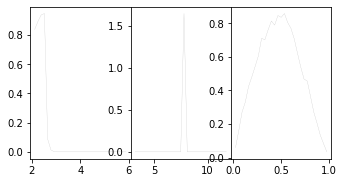

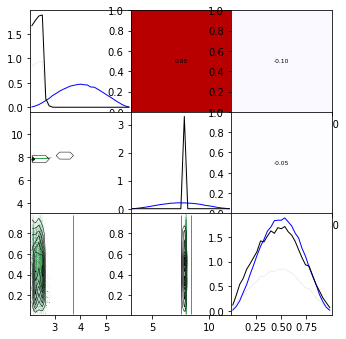

In [23]:
    X_std = X_P_std
    X_mean = X_P_mean
    frac = 1.0
    lw = 1
    color_prior = "b"
    X_list = []
    X_prior = (X_P_prior* X_P_std[-3::] .detach().cpu().numpy() + X_P_mean[-3::] .detach().cpu().numpy())
    keys_dict = {"f_ice": "$f_{\mathrm{ice}}$", "f_snow": "$f_{\mathrm{snoe}}$", "refreeze": "$r$"}
    p = Path(f"{emulator_dir}/posterior_samples/")
    print("Loading posterior samples\n")
    for m, m_file in enumerate(sorted(p.glob("X_posterior_model_*.csv.gz"))):
        print(f"  -- {m_file}")
        df = pd.read_csv(m_file).sample(frac=frac)
        if "Unnamed: 0" in df.columns:
            df.drop(columns=["Unnamed: 0"], inplace=True)
        model = m_file.name.split("_")[-1].split(".")[0]
        df["Model"] = int(model)
        X_list.append(df)

    print(f"Merging posteriors into dataframe")
    posterior_df = pd.concat(X_list)

    X_posterior = posterior_df.drop(columns=["Model"]).values
    C_0 = np.corrcoef((X_posterior - X_posterior.mean(axis=0)).T)
    Cn_0 = (np.sign(C_0) * C_0 ** 2 + 1) / 2.0

    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(5.4, 2.8))
    fig.subplots_adjust(hspace=0.0, wspace=0.0)
    for i in range(3):
        min_val = min(X_prior[:, i].min(), X_posterior[:, i].min())
        max_val = max(X_prior[:, i].max(), X_posterior[:, i].max())
        bins = np.linspace(min_val, max_val, 30)
        X_prior_hist, b = np.histogram(X_prior[:, i] , bins, density=True)
        X_posterior_hist, _ = np.histogram(X_posterior[:, i], bins, density=True)
        b = 0.5 * (b[1:] + b[:-1])
        axs[i].plot(
            b,
            X_posterior_hist * 0.5,
            color="0.5",
            linewidth=lw * 0.25,
            linestyle="solid",
            alpha=0.5,
        )

    figfile = f"{emulator_dir}/posterior.pdf"
    print(f"Saving figure to {figfile}")
    fig.savefig(figfile)

    fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(5.4, 5.6))
    fig.subplots_adjust(hspace=0.0, wspace=0.0)
    for i in range(3):
        for j in range(3):
            if i > j:

                axs[i, j].scatter(
                    X_posterior[:, j],
                    X_posterior[:, i],
                    c="#31a354",
                    s=0.05,
                    alpha=0.01,
                    label="Posterior",
                    rasterized=True,
                )

                min_val = min(X_prior[:, i].min(), X_posterior[:, i].min())
                max_val = max(X_prior[:, i].max(), X_posterior[:, i].max())
                bins_y = np.linspace(min_val, max_val, 30)

                min_val = min(X_prior[:, j].min(), X_posterior[:, j].min())
                max_val = max(X_prior[:, j].max(), X_posterior[:, j].max())
                bins_x = np.linspace(min_val, max_val, 30)

                v = gaussian_kde(X_posterior[:, [j, i]].T)
                bx = 0.5 * (bins_x[1:] + bins_x[:-1])
                by = 0.5 * (bins_y[1:] + bins_y[:-1])
                Bx, By = np.meshgrid(bx, by)

                axs[i, j].contour(
                    Bx,
                    By,
                    v(np.vstack((Bx.ravel(), By.ravel()))).reshape(Bx.shape),
                    7,
                    linewidths=0.5,
                    colors="black",
                )

                axs[i, j].set_xlim(X_prior[:, j].min(), X_prior[:, j].max())
                axs[i, j].set_ylim(X_prior[:, i].min(), X_prior[:, i].max())

            elif i < j:
                patch_upper = Polygon(
                    np.array([[0.0, 0.0], [0.0, 1.0], [1.0, 1.0], [1.0, 0.0]]),
                    facecolor=plt.cm.seismic(Cn_0[i, j]),
                )
                axs[i, j].add_patch(patch_upper)
                if C_0[i, j] > -0.5:
                    color = "black"
                else:
                    color = "white"
                axs[i, j].text(
                    0.5,
                    0.5,
                    "{0:.2f}".format(C_0[i, j]),
                    fontsize=6,
                    horizontalalignment="center",
                    verticalalignment="center",
                    transform=axs[i, j].transAxes,
                    color=color,
                )

            elif i == j:
                min_val = min(X_prior[:, i].min(), X_posterior[:, i].min())
                max_val = max(X_prior[:, i].max(), X_posterior[:, i].max())
                bins = np.linspace(min_val, max_val, 30)
                X_prior_hist, b = np.histogram(X_prior[:, i], bins, density=True)
                X_posterior_hist, _ = np.histogram(
                    X_posterior[:, i], bins, density=True
                )
                b = 0.5 * (b[1:] + b[:-1])

                axs[i, j].plot(
                    b,
                    X_prior_hist,
                    color=color_prior,
                    linewidth=lw,
                    label="Prior",
                    linestyle="solid",
                )

                all_models = posterior_df["Model"].unique()
                for k, m_model in enumerate(all_models):
                    m_df = posterior_df[posterior_df["Model"] == m_model].drop(
                        columns=["Model"]
                    )
                    X_model_posterior = m_df.values
                    X_model_posterior_hist, _ = np.histogram(
                        X_model_posterior[:, i], _, density=True
                    )
                    if k == 0:
                        axs[i, j].plot(
                            b,
                            X_model_posterior_hist * 0.5,
                            color="0.5",
                            linewidth=lw * 0.25,
                            linestyle="solid",
                            alpha=0.5,
                            label="Posterior (BayesBag)",
                        )
                    else:
                        axs[i, j].plot(
                            b,
                            X_model_posterior_hist * 0.5,
                            color="0.5",
                            linewidth=lw * 0.25,
                            linestyle="solid",
                            alpha=0.5,
                        )

                axs[i, j].plot(
                    b,
                    X_posterior_hist,
                    color="black",
                    linewidth=lw,
                    linestyle="solid",
                    label="Posterior",
                )

                axs[i, j].set_xlim(min_val, max_val)

            else:
                axs[i, j].remove()

    for i, ax in enumerate(axs[:, 0]):
        ax.set_ylabel(keys_dict[X_keys[i]])

    for j, ax in enumerate(axs[-1, :]):
        ax.set_xlabel(keys_dict[X_keys[j]])
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
        plt.setp(ax.xaxis.get_minorticklabels(), rotation=45)
        if j > 0:
            ax.tick_params(axis="y", which="both", length=0)
            ax.yaxis.set_minor_formatter(NullFormatter())
            ax.yaxis.set_major_formatter(NullFormatter())

    for ax in axs[:-1, 0].ravel():
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.xaxis.set_minor_formatter(NullFormatter())
        ax.tick_params(axis="x", which="both", length=0)

    for ax in axs[:-1, 1:].ravel():
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.xaxis.set_minor_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_minor_formatter(NullFormatter())
        ax.tick_params(axis="both", which="both", length=0)

    l_prior = Line2D([], [], c=color_prior, lw=lw, ls="solid", label="Prior")
    l_post = Line2D([], [], c="k", lw=lw, ls="solid", label="Posterior")
    l_post_b = Line2D(
        [], [], c="0.25", lw=lw * 0.25, ls="solid", label="Posterior (BayesBag)"
    )

    legend = fig.legend(
        handles=[l_prior, l_post, l_post_b], bbox_to_anchor=(0.3, 0.955)
    )
    legend.get_frame().set_linewidth(0.0)
    legend.get_frame().set_alpha(0.0)

    figfile = f"{emulator_dir}/emulator_posterior.pdf"
    print(f"Saving figure to {figfile}")
    fig.savefig(figfile)


In [ ]:
posterior_df.mean()

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir lightning_logs/

In [ ]:
X_test

In [ ]:
" ".join([f"-{k} {d[k]}" for k in d])

In [ ]:
x = np.linspace(0, 1, 100)
a = torch.distributions.Binomial(total_count=9,probs=torch.tensor(x)).log_prob(torch.tensor([6])).exp()

In [ ]:
import pylab as plt
plt.plot(x, a)